In [92]:
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import rcParams
from scipy.stats import linregress
import numpy as np
import os
from copy import deepcopy
from tqdm import tqdm
from datetime import datetime, date, timedelta
import datetime
from scipy.stats import ttest_ind, tukey_hsd, f_oneway, ttest_rel


rcParams['font.family'] = 'Inter'
rcParams['font.size'] = 12
rcParams['figure.figsize'] = [5.0, 5.0]
rcParams['figure.dpi'] = 300
rcParams['xtick.direction'] = 'in'
rcParams['ytick.direction'] = 'in'

In [59]:
BASE_DIR = "AVHRR/"
SITE_TWO_PERIODS = os.path.join(BASE_DIR,  "data/site_spanning_modis_and_avhrr_periods.csv")
meta_df = pd.read_csv(SITE_TWO_PERIODS).drop("Unnamed: 0", axis=1)
FLUXNET_DIR = os.path.join("data/FLUXNET_DAILY/")
LCSPP_DIR = os.path.join(BASE_DIR, "data/LCSPP_v3.2/")
LCREF_DIR = os.path.join (BASE_DIR, "data/LCREF_v3.2/")
def get_file_list(product_dir):
    filelist=[]
    for file in sorted(os.listdir(product_dir)):
        filelist.append(os.path.join(product_dir, file))
    return filelist

LCSPP_FILE_LIST = [f for f in get_file_list(LCSPP_DIR)][9*24:-9*24] # 1991-2014
LCREF_FILE_LIST = [f for f in get_file_list(LCREF_DIR)][9*24:-9*24] # 1991-2014

# TODO: move back to original location after done
FLUXCOM_XBASE_DIR = "data/FLUXCOM_XBASE_DATA"
FLUXCOM_DIR = os.path.join(BASE_DIR, "data/FLUXCOM")


MODIS_LCSPP_DIR= os.path.join(BASE_DIR, "data/MODIS_LCSPP_v3")
MODIS_LCREF_DIR= os.path.join(BASE_DIR, "data/MODIS_LCREF_v3")

MODIS_LCSPP_FILE_LIST = [f for f in get_file_list(MODIS_LCSPP_DIR)][:-9*24] # 2001-2014
MODIS_LCREF_FILE_LIST = [f for f in get_file_list(MODIS_LCREF_DIR)][:-9*24] # 2001-2014

LTDR_LCSPP_DIR= os.path.join(BASE_DIR, "data/LTDR_LCSPP")
LTDR_LCREF_DIR = os.path.join(BASE_DIR, "data/LTDR_LCREF")

LTDR_LCSPP_FILE_LIST=get_file_list(LTDR_LCSPP_DIR)[9*24:-9*24] # 1991-2014
LTDR_LCREF_FILE_LIST=get_file_list(LTDR_LCREF_DIR)[9*24:-9*24] # 1991-2014

ERA_5_CMG_LIST = np.array(sorted([os.path.join("data/ERA5", f) for f in os.listdir(os.path.join(BASE_DIR, "data/ERA5")) if "CMG_ssrd_biweekly_" in f])[0:-10])

In [17]:
extracted_lcspp = []
extracted_lcsppall = []
for file in tqdm(LCSPP_FILE_LIST):
    ds = xr.open_dataset(file)
    lcsppclear_daily = np.diag(ds.lcspp_clear_daily.sel(lat = meta_df.LAT.values, lon = meta_df.LON.values, method="nearest")[0].values)
    lcsppall_daily = np.diag(ds.lcspp_all_daily.sel(lat = meta_df.LAT.values, lon = meta_df.LON.values, method="nearest")[0].values)
    extracted_lcspp.append(lcsppclear_daily)
    extracted_lcsppall.append(lcsppall_daily)
    
    
modis_extracted_lcspp = []
modis_extracted_lcsppall = []
for file in tqdm(MODIS_LCSPP_FILE_LIST):
    ds = xr.open_dataset(file)
    lcsppclear_daily = np.diag(ds.lcspp_clear_daily.sel(lat = meta_df.LAT.values, lon = meta_df.LON.values, method="nearest")[0].values)
    lcsppall_daily = np.diag(ds.lcspp_all_daily.sel(lat = meta_df.LAT.values, lon = meta_df.LON.values, method="nearest")[0].values)
    modis_extracted_lcspp.append(lcsppclear_daily)
    modis_extracted_lcsppall.append(lcsppall_daily)
    
    
extracted_red = []
extracted_nir = []

for file in tqdm(LCREF_FILE_LIST):
    ds_red = xr.open_dataset(file).red
    ds_nir = xr.open_dataset(file).nir
    red_site = np.diag(ds_red.sel(lat = meta_df.LAT.values, lon = meta_df.LON.values, method="nearest")[0].values)
    nir_site = np.diag(ds_nir.sel(lat = meta_df.LAT.values, lon = meta_df.LON.values, method="nearest")[0].values)
    extracted_red.append(red_site)
    extracted_nir.append(nir_site)
    
modis_extracted_red = []
modis_extracted_nir = []

for file in tqdm(MODIS_LCREF_FILE_LIST):
    ds_red = xr.open_dataset(file).red
    ds_nir = xr.open_dataset(file).nir
    red_site = np.diag(ds_red.sel(lat = meta_df.LAT.values, lon = meta_df.LON.values, method="nearest")[0].values)
    nir_site = np.diag(ds_nir.sel(lat = meta_df.LAT.values, lon = meta_df.LON.values, method="nearest")[0].values)
    modis_extracted_red.append(red_site)
    modis_extracted_nir.append(nir_site)
    
extracted_ssrd = []
for file in tqdm(ERA_5_CMG_LIST[9*24:33*24]):
    ds_ssrd = np.flip(xr.open_dataset(file).Band1, axis=0)
    ssrd_site = np.diag(ds_ssrd.sel(lat = meta_df.LAT.values, lon = meta_df.LON.values, method="nearest").values)
    extracted_ssrd.append(ssrd_site)

100%|█████████████████████████████████████████| 576/576 [01:47<00:00,  5.34it/s]


In [60]:
ltdr_extracted_lcspp = []
ltdr_extracted_lcsppall = []
for file in tqdm(LTDR_LCSPP_FILE_LIST):
    ds = xr.open_dataset(file)
    lcsppclear_daily = np.diag(ds.lcspp_clear_daily.sel(lat = meta_df.LAT.values, lon = meta_df.LON.values, method="nearest")[0].values)
    lcsppall_daily = np.diag(ds.lcspp_all_daily.sel(lat = meta_df.LAT.values, lon = meta_df.LON.values, method="nearest")[0].values)
    ltdr_extracted_lcspp.append(lcsppclear_daily)
    ltdr_extracted_lcsppall.append(lcsppall_daily)
ltdr_extracted_red = []
ltdr_extracted_nir = []

for file in tqdm(LTDR_LCREF_FILE_LIST):
    ds_red = xr.open_dataset(file).red
    ds_nir = xr.open_dataset(file).nir
    red_site = np.diag(ds_red.sel(lat = meta_df.LAT.values, lon = meta_df.LON.values, method="nearest")[0].values)
    nir_site = np.diag(ds_nir.sel(lat = meta_df.LAT.values, lon = meta_df.LON.values, method="nearest")[0].values)
    ltdr_extracted_red.append(red_site)
    ltdr_extracted_nir.append(nir_site)

100%|███████████████████████████████████████| 576/576 [02:39<00:00,  3.62it/s]


In [61]:
ltdr_site_red = np.stack(ltdr_extracted_red)
ltdr_site_nir = np.stack(ltdr_extracted_nir)
ltdr_site_lcspp = np.stack(ltdr_extracted_lcspp)
ltdr_site_lcsppall = np.stack(ltdr_extracted_lcsppall)

ltdr_site_ndvi = (ltdr_site_nir - ltdr_site_red) / (ltdr_site_nir + ltdr_site_red)
ltdr_site_nirv = ltdr_site_ndvi * ltdr_site_nir
ltdr_site_ssrd = np.load("AVHRR/data/processed/avhrr_1991-2014_ssrd.npy")
ltdr_site_nirvp = ltdr_site_nirv * ltdr_site_ssrd
ltdr_site_sigma = 0.5 * (ltdr_site_red + ltdr_site_nir)
ltdr_site_kndvi = np.tanh(((ltdr_site_nir-ltdr_site_red) / (2 * ltdr_site_sigma))**2)

ltdr_site_sigma_temporal = np.mean(np.abs(ltdr_site_nir - ltdr_site_red), axis=0)
ltdr_site_kndvi_temporal = np.tanh(((ltdr_site_nir-ltdr_site_red) / (2 * ltdr_site_sigma_temporal))**2)

np.save("AVHRR/data/processed/ltdr_2001-2014_lcref_red.npy", ltdr_site_red)
np.save("AVHRR/data/processed/ltdr_2001-2014_lcref_nir.npy", ltdr_site_nir)
np.save("AVHRR/data/processed/ltdr_2001-2014_lcspp.npy", ltdr_site_lcspp)
np.save("AVHRR/data/processed/ltdr_2001-2014_lcspp_all.npy", ltdr_site_lcsppall)
np.save("AVHRR/data/processed/ltdr_2001-2014_ndvi.npy", ltdr_site_ndvi)
np.save("AVHRR/data/processed/ltdr_2001-2014_nirv.npy", ltdr_site_nirv)
np.save("AVHRR/data/processed/ltdr_2001-2014_ssrd.npy", ltdr_site_ssrd)
np.save("AVHRR/data/processed/ltdr_2001-2014_nirvp.npy", ltdr_site_nirvp)
np.save("AVHRR/data/processed/ltdr_2001-2014_kndvi.npy", ltdr_site_kndvi)

In [62]:
date_list = []
for year in np.arange(1991, 2015):
    for month in np.arange(1, 13):
        for day in [8, 22]:
            date_list.append(date(year, month, day))
dl = np.array(date_list)

In [22]:
site_red = np.stack(extracted_red)
site_nir = np.stack(extracted_nir)
site_lcspp = np.stack(extracted_lcspp)
site_lcsppall = np.stack(extracted_lcsppall)     

modis_site_red = np.stack(modis_extracted_red)
modis_site_nir = np.stack(modis_extracted_nir)
modis_site_lcspp = np.stack(modis_extracted_lcspp)
modis_site_lcsppall = np.stack(modis_extracted_lcsppall)

site_ssrd = np.stack(extracted_ssrd)
modis_site_ssrd = deepcopy(site_ssrd[-14*24:, :])

site_ndvi = (site_nir - site_red) / (site_nir + site_red)
site_nirv = site_ndvi * site_nir
site_nirvp = site_nirv * site_ssrd
site_sigma = 0.5 * (site_red + site_nir)
site_kndvi = np.tanh(((site_nir-site_red) / (2 * site_sigma))**2)
sigma_temporal = np.mean(np.abs(site_nir - site_red), axis=0)
site_kndvi_temporal =  np.tanh(((site_nir-site_red) / (2 * sigma_temporal))**2)


modis_site_ndvi = (modis_site_nir - modis_site_red) / (modis_site_nir + modis_site_red)
modis_site_nirv = modis_site_ndvi * modis_site_nir
modis_site_nirvp = modis_site_nirv * modis_site_ssrd
modis_site_sigma = 0.5 * (modis_site_red + modis_site_nir)
modis_site_kndvi = np.tanh(((modis_site_nir-modis_site_red) / (2 * modis_site_sigma))**2)
modis_site_sigma_temporal = np.mean(np.abs(modis_site_nir - modis_site_red), axis=0)
modis_site_kndvi_temporal = np.tanh(((modis_site_nir-modis_site_red) / (2 * modis_site_sigma_temporal))**2)

In [23]:
np.save("AVHRR/data/processed/avhrr_1991-2014_kndvi_temporal.npy", site_kndvi_temporal)
np.save("AVHRR/data/processed/modis_2001-2014_kndvi_temporal.npy", modis_site_kndvi_temporal)
np.save("AVHRR/data/processed/ltdr_2001-2014_kndvi_temporal.npy", ltdr_site_kndvi_temporal)

In [24]:
np.save("AVHRR/data/processed/avhrr_1991-2014_lcref_red.npy", site_red)
np.save("AVHRR/data/processed/avhrr_1991-2014_lcref_nir.npy", site_nir)
np.save("AVHRR/data/processed/avhrr_1991-2014_lcspp.npy", site_lcspp)
np.save("AVHRR/data/processed/avhrr_1991-2014_lcspp_all.npy", site_lcsppall)


np.save("AVHRR/data/processed/modis_2001-2014_lcref_red.npy", modis_site_red)
np.save("AVHRR/data/processed/modis_2001-2014_lcref_nir.npy", modis_site_nir)
np.save("AVHRR/data/processed/modis_2001-2014_lcspp.npy", modis_site_lcspp)
np.save("AVHRR/data/processed/modis_2001-2014_lcspp_all.npy", modis_site_lcsppall)

np.save("AVHRR/data/processed/avhrr_1991-2014_ssrd.npy", site_ssrd)
np.save("AVHRR/data/processed/modis_2001-2014_ssrd.npy", modis_site_ssrd)


np.save("AVHRR/data/processed/avhrr_1991-2014_ndvi.npy", site_ndvi)
np.save("AVHRR/data/processed/avhrr_1991-2014_nirv.npy", site_nirv)
np.save("AVHRR/data/processed/avhrr_1991-2014_nirvp.npy", site_nirvp)
np.save("AVHRR/data/processed/avhrr_1991-2014_kndvi.npy", site_kndvi)

np.save("AVHRR/data/processed/modis_2001-2014_ndvi.npy", modis_site_ndvi)
np.save("AVHRR/data/processed/modis_2001-2014_nirv.npy", modis_site_nirv)
np.save("AVHRR/data/processed/modis_2001-2014_nirvp.npy", modis_site_nirvp)
np.save("AVHRR/data/processed/modis_2001-2014_kndvi.npy", modis_site_kndvi)

In [69]:
site_red = np.load("AVHRR/data/processed/avhrr_1991-2014_lcref_red.npy")
site_nir = np.load("AVHRR/data/processed/avhrr_1991-2014_lcref_nir.npy")
site_lcspp = np.load("AVHRR/data/processed/avhrr_1991-2014_lcspp.npy")
site_lcsppall = np.load("AVHRR/data/processed/avhrr_1991-2014_lcsppall.npy")

modis_site_red = np.load("AVHRR/data/processed/modis_2001-2014_lcref_red.npy")
modis_site_nir = np.load("AVHRR/data/processed/modis_2001-2014_lcref_nir.npy")
modis_site_lcspp = np.load("AVHRR/data/processed/modis_2001-2014_lcspp.npy")
modis_site_lcsppall = np.load("AVHRR/data/processed/modis_2001-2014_lcspp_all.npy")

site_ssrd = np.load("AVHRR/data/processed/avhrr_1991-2014_ssrd.npy")
modis_site_ssrd = np.load("AVHRR/data/processed/modis_2001-2014_ssrd.npy")
ltdr_site_ssrd = np.load("AVHRR/data/processed/ltdr_2001-2014_ssrd.npy")


site_ndvi = np.load("AVHRR/data/processed/avhrr_1991-2014_ndvi.npy")
site_nirv = np.load("AVHRR/data/processed/avhrr_1991-2014_nirv.npy")
site_nirvp = np.load("AVHRR/data/processed/avhrr_1991-2014_nirvp.npy")
site_kndvi = np.load("AVHRR/data/processed/avhrr_1991-2014_kndvi.npy")
site_kndvi_temporal = np.load("AVHRR/data/processed/avhrr_1991-2014_kndvi_temporal.npy")


modis_site_ndvi = np.load("AVHRR/data/processed/modis_2001-2014_ndvi.npy")
modis_site_nirv = np.load("AVHRR/data/processed/modis_2001-2014_nirv.npy")
modis_site_nirvp = np.load("AVHRR/data/processed/modis_2001-2014_nirvp.npy")
modis_site_kndvi = np.load("AVHRR/data/processed/modis_2001-2014_kndvi.npy")
modis_site_kndvi_temporal = np.load("AVHRR/data/processed/modis_2001-2014_kndvi_temporal.npy")


ltdr_site_red = np.load("AVHRR/data/processed/ltdr_2001-2014_lcref_red.npy")
ltdr_site_nir = np.load("AVHRR/data/processed/ltdr_2001-2014_lcref_nir.npy")
ltdr_site_lcspp = np.load("AVHRR/data/processed/ltdr_2001-2014_lcspp.npy")
ltdr_site_lcsppall = np.load("AVHRR/data/processed/ltdr_2001-2014_lcspp_all.npy")
ltdr_site_ndvi = np.load("AVHRR/data/processed/ltdr_2001-2014_ndvi.npy")
ltdr_site_nirv = np.load("AVHRR/data/processed/ltdr_2001-2014_nirv.npy")
ltdr_site_nirvp = np.load("AVHRR/data/processed/ltdr_2001-2014_nirvp.npy")
ltdr_site_kndvi = np.load("AVHRR/data/processed/ltdr_2001-2014_kndvi.npy")
ltdr_site_kndvi_temporal = np.load("AVHRR/data/processed/ltdr_2001-2014_kndvi_temporal.npy")


In [70]:
def aggregate_biweekly(data_arr):
    value_sum = pd.DataFrame({"period_tuple":[(y, m, d) for y, m, d in zip(data_arr.index.year, data_arr.index.month, data_arr.index.day > 15)],
                  "data_arr":data_arr}).groupby("period_tuple").sum()
    value_count = pd.DataFrame({"period_tuple":[(y, m, d) for y, m, d in zip(data_arr.index.year, data_arr.index.month, data_arr.index.day > 15)],
                  "data_arr":np.invert(np.isnan(data_arr))}).groupby("period_tuple").sum()

    value_mean = value_sum/value_count
    return value_mean.values.squeeze()

In [71]:
result_list=[]
for i in range(len(meta_df)):
    sitename =  str(meta_df["SITE_ID"][i])
    site_dir = os.path.join(FLUXNET_DIR, sitename)
    flux_df = pd.read_csv(os.path.join(site_dir, os.listdir(site_dir)[0]))
    
    GPP = deepcopy(flux_df.GPP_NT_VUT_REF)
    GPP[GPP==-9999]=np.nan
    GPP = pd.Series(GPP.values, index = pd.to_datetime(flux_df.TIMESTAMP, format='%Y%m%d'))
    GPP = GPP.reindex(pd.date_range(str(meta_df.START[i])+"-01-01", str(np.minimum(meta_df.END[i], 2013))+"-12-31", freq="D"))
    
    FLUXCOM_XBASE_GPP = xr.open_dataset(os.path.join(FLUXCOM_XBASE_DIR, sitename + "_FLUXCOM_XBASE.nc")).GPP.to_dataframe()["GPP"]
    FLUXCOM_XBASE_GPP = FLUXCOM_XBASE_GPP.reindex(pd.date_range(str(meta_df.START[i])+"-01-01", str(np.minimum(meta_df.END[i], 2013))+"-12-31", freq="D")).interpolate(limit=7)
        
    FLUXCOM_GPP = xr.open_dataset(os.path.join(FLUXCOM_DIR, sitename + "_FLUXCOM_SUBSET.nc")).GPP.to_dataframe()["GPP"]
    FLUXCOM_GPP = FLUXCOM_GPP.reindex(pd.date_range(str(meta_df.START[i])+"-01-01", str(np.minimum(meta_df.END[i], 2013))+"-12-31", freq="D")).interpolate(limit=7)

    start_idx = np.argmax(dl > date(meta_df["START"][i], 1, 1))
    end_idx = np.argmax(dl > date(np.minimum(meta_df.END[i], 2013) + 1, 1, 1)) 
    if end_idx == 0:
        end_idx = len(dl)
    lcsppbiweekly = site_lcspp[start_idx:end_idx, i]
    lcsppALL_biweekly = site_lcsppall[start_idx:end_idx, i]
    NDVI_biweekly = site_ndvi[start_idx:end_idx, i]
    NIRV_biweekly = site_nirv[start_idx:end_idx, i]
    NIRVP_biweekly = site_nirvp[start_idx:end_idx, i]
    KNDVI_biweekly = site_kndvi[start_idx:end_idx, i]
    KNDVI_TEMPORAL_biweekly = site_kndvi_temporal[start_idx:end_idx, i]
    
    DL = pd.to_datetime(dl[start_idx:end_idx])
    GPP_biweekly = aggregate_biweekly(GPP)
    
    FLUXCOM_GPP_biweekly = aggregate_biweekly(FLUXCOM_GPP)
    FLUXCOM_XBASE_GPP_biweekly = aggregate_biweekly(FLUXCOM_XBASE_GPP)
    
    PRE2001 = DL < np.datetime64("2001-01-01")
    POST2001 = DL >= np.datetime64("2001-01-01")
    QC = deepcopy(flux_df.NEE_VUT_REF_QC)
    QC[QC==-9999]=np.nan
    QC = pd.Series(QC.values, index = pd.to_datetime(flux_df.TIMESTAMP, format='%Y%m%d'))
    QC = QC.reindex(pd.date_range(str(meta_df.START[i])+"-01-01", str(np.minimum(meta_df.END[i], 2013))+"-12-31", freq="D")).interpolate(limit=7)
    QC_biweekly = aggregate_biweekly(QC)
    not_nan_sel_avhrr = np.invert(np.isnan(lcsppbiweekly[PRE2001]) | np.isnan(GPP_biweekly[PRE2001])) & (QC_biweekly[PRE2001] > 0.7)
    not_nan_sel_modis = np.invert(np.isnan(lcsppbiweekly[POST2001]) | np.isnan(GPP_biweekly[POST2001])) & (QC_biweekly[POST2001] > 0.7)

    PRE2001_lcsppreg = linregress((lcsppbiweekly[PRE2001])[not_nan_sel_avhrr], (GPP_biweekly[PRE2001])[not_nan_sel_avhrr])
    POST2001_lcsppreg = linregress((lcsppbiweekly[POST2001])[not_nan_sel_modis], (GPP_biweekly[POST2001])[not_nan_sel_modis])
    result_list.append({"SITE_ID":sitename, "period":"PRE2001", "type":"SIF", "R^2":PRE2001_lcsppreg.rvalue**2,
                       "slope":PRE2001_lcsppreg.slope, "intercept":PRE2001_lcsppreg.intercept})
    result_list.append({"SITE_ID":sitename, "period":"POST2001", "type":"SIF", "R^2":POST2001_lcsppreg.rvalue**2,
                       "slope":POST2001_lcsppreg.slope, "intercept":POST2001_lcsppreg.intercept})
    
    PRE2001_lcsppALL_reg = linregress((lcsppALL_biweekly[PRE2001])[not_nan_sel_avhrr], (GPP_biweekly[PRE2001])[not_nan_sel_avhrr])
    POST2001_lcsppALL_reg = linregress((lcsppALL_biweekly[POST2001])[not_nan_sel_modis], (GPP_biweekly[POST2001])[not_nan_sel_modis])
    result_list.append({"SITE_ID":sitename, "period":"PRE2001", "type":"SIFALL", "R^2":PRE2001_lcsppALL_reg.rvalue**2,
                       "slope":PRE2001_lcsppALL_reg.slope, "intercept":PRE2001_lcsppALL_reg.intercept})
    result_list.append({"SITE_ID":sitename, "period":"POST2001", "type":"SIFALL", "R^2":POST2001_lcsppALL_reg.rvalue**2,
                       "slope":POST2001_lcsppALL_reg.slope, "intercept":POST2001_lcsppALL_reg.intercept})

    PRE2001_NDVI_reg = linregress((NDVI_biweekly[PRE2001])[not_nan_sel_avhrr], (GPP_biweekly[PRE2001])[not_nan_sel_avhrr])
    POST2001_NDVI_reg = linregress((NDVI_biweekly[POST2001])[not_nan_sel_modis], (GPP_biweekly[POST2001])[not_nan_sel_modis]) 
    result_list.append({"SITE_ID":sitename, "period":"PRE2001", "type":"NDVI", "R^2":PRE2001_NDVI_reg.rvalue**2,
                       "slope":PRE2001_NDVI_reg.slope, "intercept":PRE2001_NDVI_reg.intercept})
    result_list.append({"SITE_ID":sitename, "period":"POST2001", "type":"NDVI", "R^2":POST2001_NDVI_reg.rvalue**2,
                       "slope":POST2001_NDVI_reg.slope, "intercept":POST2001_NDVI_reg.intercept})
    
    PRE2001_NIRV_reg = linregress((NIRV_biweekly[PRE2001])[not_nan_sel_avhrr], (GPP_biweekly[PRE2001])[not_nan_sel_avhrr])
    POST2001_NIRV_reg = linregress((NIRV_biweekly[POST2001])[not_nan_sel_modis], (GPP_biweekly[POST2001])[not_nan_sel_modis]) 
    result_list.append({"SITE_ID":sitename, "period":"PRE2001", "type":"NIRV", "R^2":PRE2001_NIRV_reg.rvalue**2,
                       "slope":PRE2001_NIRV_reg.slope, "intercept":PRE2001_NIRV_reg.intercept})
    result_list.append({"SITE_ID":sitename, "period":"POST2001", "type":"NIRV", "R^2":POST2001_NIRV_reg.rvalue**2,
                       "slope":POST2001_NIRV_reg.slope, "intercept":POST2001_NIRV_reg.intercept})
    
    PRE2001_NIRVP_reg = linregress((NIRVP_biweekly[PRE2001])[not_nan_sel_avhrr], (GPP_biweekly[PRE2001])[not_nan_sel_avhrr])
    POST2001_NIRVP_reg = linregress((NIRVP_biweekly[POST2001])[not_nan_sel_modis], (GPP_biweekly[POST2001])[not_nan_sel_modis]) 
    result_list.append({"SITE_ID":sitename, "period":"PRE2001", "type":"NIRVP", "R^2":PRE2001_NIRVP_reg.rvalue**2,
                       "slope":PRE2001_NIRVP_reg.slope, "intercept":PRE2001_NIRVP_reg.intercept})
    result_list.append({"SITE_ID":sitename, "period":"POST2001", "type":"NIRVP", "R^2":POST2001_NIRVP_reg.rvalue**2,
                       "slope":POST2001_NIRVP_reg.slope, "intercept":POST2001_NIRVP_reg.intercept})
    
    PRE2001_KNDVI_reg = linregress((KNDVI_biweekly[PRE2001])[not_nan_sel_avhrr], (GPP_biweekly[PRE2001])[not_nan_sel_avhrr])
    POST2001_KNDVI_reg = linregress((KNDVI_biweekly[POST2001])[not_nan_sel_modis], (GPP_biweekly[POST2001])[not_nan_sel_modis]) 
    result_list.append({"SITE_ID":sitename, "period":"PRE2001", "type":"KNDVI", "R^2":PRE2001_KNDVI_reg.rvalue**2,
                       "slope":PRE2001_KNDVI_reg.slope, "intercept":PRE2001_KNDVI_reg.intercept})
    result_list.append({"SITE_ID":sitename, "period":"POST2001", "type":"KNDVI", "R^2":POST2001_KNDVI_reg.rvalue**2,
                       "slope":POST2001_KNDVI_reg.slope, "intercept":POST2001_KNDVI_reg.intercept})
    
    PRE2001_KNDVI_TEMPORAL_reg = linregress((KNDVI_TEMPORAL_biweekly[PRE2001])[not_nan_sel_avhrr], (GPP_biweekly[PRE2001])[not_nan_sel_avhrr])
    POST2001_KNDVI_TEMPORAL_reg = linregress((KNDVI_TEMPORAL_biweekly[POST2001])[not_nan_sel_modis], (GPP_biweekly[POST2001])[not_nan_sel_modis]) 
    result_list.append({"SITE_ID":sitename, "period":"PRE2001", "type":"KNDVI_TEMPORAL", "R^2":PRE2001_KNDVI_TEMPORAL_reg.rvalue**2,
                       "slope":PRE2001_KNDVI_TEMPORAL_reg.slope, "intercept":PRE2001_KNDVI_TEMPORAL_reg.intercept})
    result_list.append({"SITE_ID":sitename, "period":"POST2001", "type":"KNDVI_TEMPORAL", "R^2":POST2001_KNDVI_TEMPORAL_reg.rvalue**2,
                       "slope":POST2001_KNDVI_TEMPORAL_reg.slope, "intercept":POST2001_KNDVI_TEMPORAL_reg.intercept})

    FLUXCOM_PRE2001_reg = linregress((FLUXCOM_GPP_biweekly[PRE2001])[not_nan_sel_avhrr], (GPP_biweekly[PRE2001])[not_nan_sel_avhrr])
    FLUXCOM_POST2001_reg = linregress((FLUXCOM_GPP_biweekly[POST2001])[not_nan_sel_modis], (GPP_biweekly[POST2001])[not_nan_sel_modis])
    
    result_list.append({"SITE_ID":sitename, "period":"PRE2001", "type":"FLUXCOM", "R^2":FLUXCOM_PRE2001_reg.rvalue**2,
                        "slope":FLUXCOM_PRE2001_reg.slope, "intercept":FLUXCOM_PRE2001_reg.intercept})
    result_list.append({"SITE_ID":sitename, "period":"POST2001", "type":"FLUXCOM", "R^2":FLUXCOM_POST2001_reg.rvalue**2,
                        "slope":FLUXCOM_POST2001_reg.slope, "intercept":FLUXCOM_POST2001_reg.intercept})
    
    FLUXCOM_XBASE_PRE2001_reg = linregress((FLUXCOM_XBASE_GPP_biweekly[PRE2001])[not_nan_sel_avhrr], (GPP_biweekly[PRE2001])[not_nan_sel_avhrr])
    FLUXCOM_XBASE_POST2001_reg = linregress((FLUXCOM_XBASE_GPP_biweekly[POST2001])[not_nan_sel_modis], (GPP_biweekly[POST2001])[not_nan_sel_modis])
    result_list.append({"SITE_ID":sitename, "period":"PRE2001", "type":"FLUXCOM_XBASE", "R^2":FLUXCOM_XBASE_PRE2001_reg.rvalue**2,
                        "slope":FLUXCOM_XBASE_PRE2001_reg.slope, "intercept":FLUXCOM_XBASE_PRE2001_reg.intercept})
    result_list.append({"SITE_ID":sitename, "period":"POST2001", "type":"FLUXCOM_XBASE", "R^2":FLUXCOM_XBASE_POST2001_reg.rvalue**2,
                        "slope":FLUXCOM_XBASE_POST2001_reg.slope, "intercept":FLUXCOM_XBASE_POST2001_reg.intercept})


In [72]:
result_df = pd.DataFrame(result_list)
result_df = pd.merge(result_df, meta_df, on="SITE_ID")

result_df_mean = result_df.groupby(["IGBP","period", "type"]).mean({'numeric_column': 'mean'})["R^2"]
result_df_std = result_df.groupby(["IGBP","period", "type"]).mean({'numeric_column': 'mean'})["R^2"]

result_df.to_csv("r_avhrr_pre-post_2001_fluxnet.csv", index=False)

In [73]:
meta_df["AVHRR_YEARS"] = 2001 - meta_df["START"] 
meta_df["MODIS_YEARS"] = np.minimum(meta_df["END"], 2013) - 2000
siteyear_df = meta_df.groupby("IGBP").sum()[["AVHRR_YEARS", "MODIS_YEARS"]]
print(siteyear_df.loc["DBF"]["AVHRR_YEARS"])
print(siteyear_df.loc["DBF"]["MODIS_YEARS"])

25
48


In [74]:
t_test_rest_list = []
for IGBP in ["ENF", "DBF", "MF"]:        
    for data_type in np.unique(result_df["type"].values):
        v1=result_df[(result_df["period"] == "PRE2001") & (result_df["IGBP"] == IGBP) & (result_df["type"] == data_type)]["R^2"].values
        v2=result_df[(result_df["period"] == "POST2001") & (result_df["IGBP"] == IGBP) & (result_df["type"] == data_type)]["R^2"].values
        t_res = ttest_rel(v1, v2, alternative="less")
        t_test_rest_list.append({"IGBP":IGBP, "type":data_type, "df": len(v1) - 1, "t":t_res.statistic, "p":t_res.pvalue })
t_test_df = pd.DataFrame(t_test_rest_list)
t_test_df.to_csv("avhrr_pre_post_2001_t_test.csv", index=False)

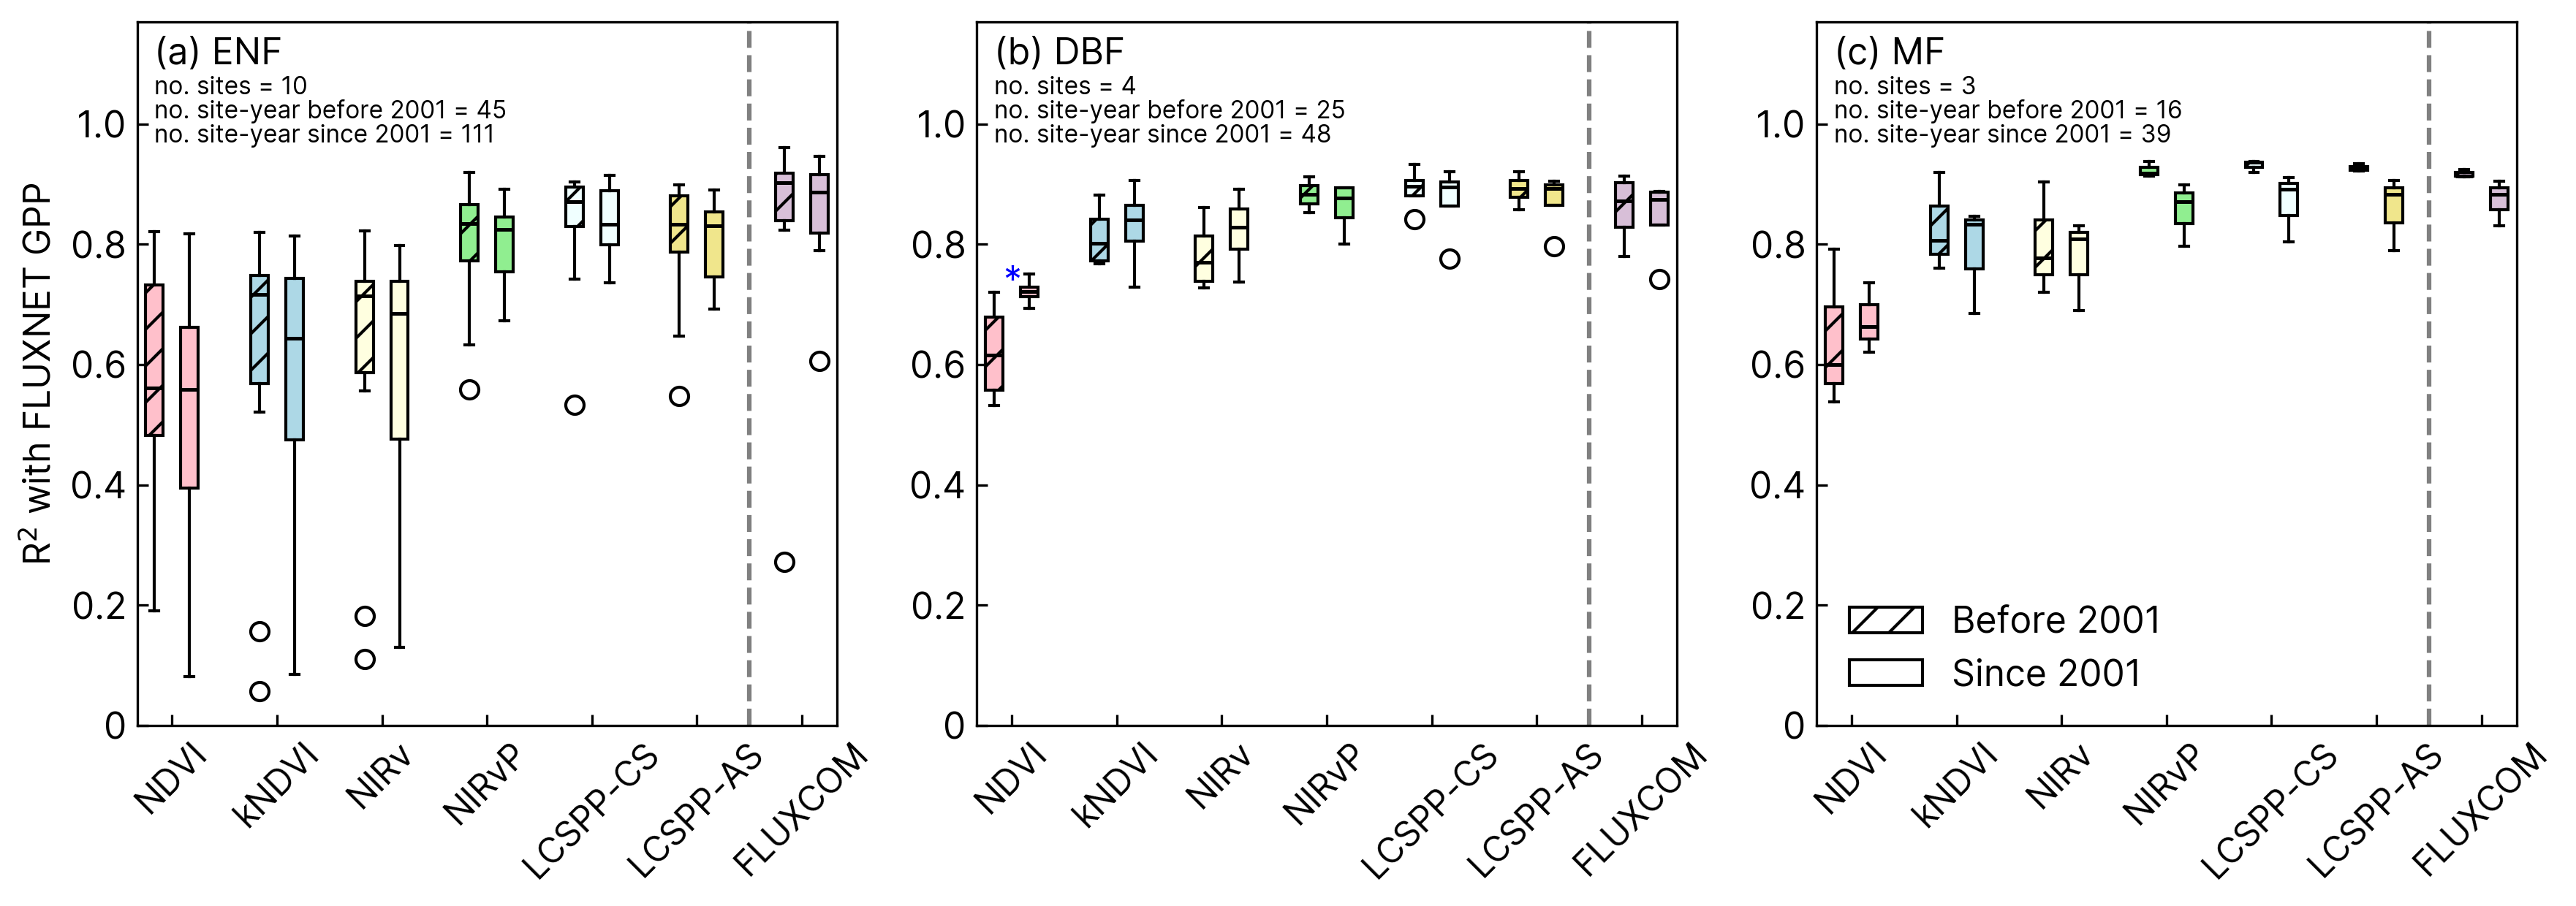

In [75]:
from matplotlib.patches import Patch
fig, axs = plt.subplots(1,3, figsize=(14,4.17), dpi=300)
ax = axs.flatten()
IGBP_types = ["ENF", "DBF", "MF"]
fig_labels = ["(a)", "(b)", "(c)"]
alpha = 0.05
for i in range(3):
    data=np.vstack([[result_df[(result_df["IGBP"]==IGBP_types[i]) 
                             & (result_df["period"] == period) 
                             & (result_df["type"]=="NDVI")]["R^2"] for period in ["PRE2001", "POST2001"]],
                    [result_df[(result_df["IGBP"]==IGBP_types[i]) 
                             & (result_df["period"] == period) 
                             & (result_df["type"]=="KNDVI_TEMPORAL")]["R^2"] for period in ["PRE2001", "POST2001"]],
                  [result_df[(result_df["IGBP"]==IGBP_types[i]) 
                             & (result_df["period"] == period) 
                             & (result_df["type"]=="NIRV")]["R^2"] for period in ["PRE2001", "POST2001"]],
                    [result_df[(result_df["IGBP"]==IGBP_types[i]) 
                             & (result_df["period"] == period) 
                             & (result_df["type"]=="NIRVP")]["R^2"] for period in ["PRE2001", "POST2001"]],
                    [result_df[(result_df["IGBP"]==IGBP_types[i]) 
                             & (result_df["period"] == period) 
                             & (result_df["type"]=="SIF")]["R^2"] for period in ["PRE2001", "POST2001"]],
                    [result_df[(result_df["IGBP"]==IGBP_types[i]) 
                             & (result_df["period"] == period) 
                             & (result_df["type"]=="SIFALL")]["R^2"] for period in ["PRE2001", "POST2001"]],
                   [result_df[(result_df["IGBP"]==IGBP_types[i]) 
                             & (result_df["period"] == period) 
                             & (result_df["type"]=="FLUXCOM")]["R^2"] for period in ["PRE2001", "POST2001"]]]).T
    bplot = ax[i].boxplot(data, positions=[1,2,4,5,7,8,10,11,13,14,16,17,19,20], patch_artist=True)
    ax[i].set_ylim(0,1.17)
    colors = ['pink', 'pink', 'lightblue', 'lightblue', 'lightyellow', 'lightyellow', 'lightgreen', 'lightgreen', 'azure', 'azure', 'khaki', 'khaki', 'thistle', 'thistle']
    hatchs = ['//', '', '//', '', '//', '', '//', '', '//', '', '//', '', '//', '']
    ax[i].set_xticks([1.5, 4.5, 7.5, 10.5, 13.5, 16.5, 19.5], labels=["NDVI", "kNDVI", "NIRv", "NIRvP", "LCSPP-CS", "LCSPP-AS", "FLUXCOM"], fontsize=11.5, rotation=45)
    ax[i].text(1, 0.9+0.15, "no. sites = " + str(len(meta_df[meta_df["IGBP"]==IGBP_types[i]])), fontsize=8)
    ax[i].text(1, 0.86+0.15, "no. site-year before 2001 = " + str(siteyear_df.loc[IGBP_types[i]]["AVHRR_YEARS"]), fontsize=8)
    ax[i].text(1, 0.82+0.15, "no. site-year since 2001 = " + str(siteyear_df.loc[IGBP_types[i]]["MODIS_YEARS"]), fontsize=8)
    ax[i].text(1,0.95+0.15, fig_labels[i] + " " + IGBP_types[i])
    ax[i].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0], ["0", "0.2", "0.4", "0.6", "0.8", "1.0"])
    data_types = ["NDVI", "KNDVI_TEMPORAL", "NIRV", "NIRVP", "SIF", "SIFALL", "FLUXCOM"]
    xloc=[1.25, 4.25, 7.25, 10.25, 13.25, 16.25, 19.25]
    for j in range(7):
        if t_test_df[(t_test_df["IGBP"]==IGBP_types[i]) & (t_test_df["type"]==data_types[j])]["p"].item() < alpha:
            yloc = np.median(result_df[(result_df["IGBP"]==IGBP_types[i]) & (result_df["period"] == "POST2001") & (result_df["type"]==data_types[j])]["R^2"])
            ax[i].text(xloc[j], yloc, "*", color="blue")

    for patch, color, hatch in zip(bplot['boxes'], colors, hatchs):
        patch.set_facecolor(color)
        patch.set_hatch(hatch)
    
    for median in bplot['medians']:
        median.set(color ='black',
                   linewidth = 1.2)
    if i == 0:
        ax[i].set_ylabel("R$^2$ with FLUXNET GPP")
        
    if i == 2:
        legend_elements = [Patch(facecolor='white', edgecolor='black', hatch="//",
                             label='Before 2001'),
                       Patch(facecolor='white', edgecolor='black', hatch="",
                             label='Since 2001')]
        ax[i].legend(handles=legend_elements, loc='lower left', frameon=False)
        
    ax[i].plot([18,18], [0, 1.2], "--", c="grey")
    

plt.savefig("./figs/FLUXNET_PRE-POST-2001.png", dpi=300)

In [80]:
ltdr_result_list=[]
for i in range(len(meta_df)):
    sitename =  str(meta_df["SITE_ID"][i])
    site_dir = os.path.join(FLUXNET_DIR, sitename)
    flux_df = pd.read_csv(os.path.join(site_dir, os.listdir(site_dir)[0]))
    
    GPP = deepcopy(flux_df.GPP_NT_VUT_REF)
    GPP[GPP==-9999]=np.nan
    GPP = pd.Series(GPP.values, index = pd.to_datetime(flux_df.TIMESTAMP, format='%Y%m%d'))
    GPP = GPP.reindex(pd.date_range(str(meta_df.START[i])+"-01-01", str(np.minimum(meta_df.END[i], 2013))+"-12-31", freq="D"))
    
    FLUXCOM_XBASE_GPP = xr.open_dataset(os.path.join(FLUXCOM_XBASE_DIR, sitename + "_FLUXCOM_XBASE.nc")).GPP.to_dataframe()["GPP"]
    FLUXCOM_XBASE_GPP = FLUXCOM_XBASE_GPP.reindex(pd.date_range(str(meta_df.START[i])+"-01-01", str(np.minimum(meta_df.END[i], 2013))+"-12-31", freq="D")).interpolate(limit=7)
        
    FLUXCOM_GPP = xr.open_dataset(os.path.join(FLUXCOM_DIR, sitename + "_FLUXCOM_SUBSET.nc")).GPP.to_dataframe()["GPP"]
    FLUXCOM_GPP = FLUXCOM_GPP.reindex(pd.date_range(str(meta_df.START[i])+"-01-01", str(np.minimum(meta_df.END[i], 2013))+"-12-31", freq="D")).interpolate(limit=7)

    start_idx = np.argmax(dl > date(meta_df["START"][i], 1, 1))
    end_idx = np.argmax(dl > date(np.minimum(meta_df.END[i], 2013) + 1, 1, 1)) 
    if end_idx == 0:
        end_idx = len(dl)
    lcsppbiweekly = ltdr_site_lcspp[start_idx:end_idx, i]
    lcsppALL_biweekly = ltdr_site_lcsppall[start_idx:end_idx, i]
    NDVI_biweekly = ltdr_site_ndvi[start_idx:end_idx, i]
    NIRV_biweekly = ltdr_site_nirv[start_idx:end_idx, i]
    NIRVP_biweekly = ltdr_site_nirvp[start_idx:end_idx, i]
    KNDVI_biweekly = ltdr_site_kndvi[start_idx:end_idx, i]
    KNDVI_TEMPORAL_biweekly = ltdr_site_kndvi_temporal[start_idx:end_idx, i]
    
    DL = pd.to_datetime(dl[start_idx:end_idx])
    GPP_biweekly = aggregate_biweekly(GPP)
    FLUXCOM_GPP_biweekly = aggregate_biweekly(FLUXCOM_GPP)
    FLUXCOM_XBASE_GPP_biweekly = aggregate_biweekly(FLUXCOM_XBASE_GPP)
    
    PRE2001 = DL < np.datetime64("2001-01-01")
    POST2001 = DL >= np.datetime64("2001-01-01")
    
    QC = deepcopy(flux_df.NEE_VUT_REF_QC)
    QC[QC==-9999]=np.nan
    QC = pd.Series(QC.values, index = pd.to_datetime(flux_df.TIMESTAMP, format='%Y%m%d'))
    QC = QC.reindex(pd.date_range(str(meta_df.START[i])+"-01-01", str(np.minimum(meta_df.END[i], 2013))+"-12-31", freq="D")).interpolate(limit=7)
    QC_biweekly = aggregate_biweekly(QC)
    not_nan_sel_avhrr = np.invert(np.isnan(lcsppbiweekly[PRE2001]) | np.isnan(GPP_biweekly[PRE2001])) & (QC_biweekly[PRE2001] > 0.7)
    not_nan_sel_modis = np.invert(np.isnan(lcsppbiweekly[POST2001]) | np.isnan(GPP_biweekly[POST2001])) & (QC_biweekly[POST2001] > 0.7)

    PRE2001_lcsppreg = linregress((lcsppbiweekly[PRE2001])[not_nan_sel_avhrr], (GPP_biweekly[PRE2001])[not_nan_sel_avhrr])
    POST2001_lcsppreg = linregress((lcsppbiweekly[POST2001])[not_nan_sel_modis], (GPP_biweekly[POST2001])[not_nan_sel_modis])
    ltdr_result_list.append({"SITE_ID":sitename, "period":"PRE2001", "type":"SIF", "R^2":PRE2001_lcsppreg.rvalue**2,
                       "slope":PRE2001_lcsppreg.slope, "intercept":PRE2001_lcsppreg.intercept})
    ltdr_result_list.append({"SITE_ID":sitename, "period":"POST2001", "type":"SIF", "R^2":POST2001_lcsppreg.rvalue**2,
                       "slope":POST2001_lcsppreg.slope, "intercept":POST2001_lcsppreg.intercept})
    
    PRE2001_lcsppALL_reg = linregress((lcsppALL_biweekly[PRE2001])[not_nan_sel_avhrr], (GPP_biweekly[PRE2001])[not_nan_sel_avhrr])
    POST2001_lcsppALL_reg = linregress((lcsppALL_biweekly[POST2001])[not_nan_sel_modis], (GPP_biweekly[POST2001])[not_nan_sel_modis])
    ltdr_result_list.append({"SITE_ID":sitename, "period":"PRE2001", "type":"SIFALL", "R^2":PRE2001_lcsppALL_reg.rvalue**2,
                       "slope":PRE2001_lcsppALL_reg.slope, "intercept":PRE2001_lcsppALL_reg.intercept})
    ltdr_result_list.append({"SITE_ID":sitename, "period":"POST2001", "type":"SIFALL", "R^2":POST2001_lcsppALL_reg.rvalue**2,
                       "slope":POST2001_lcsppALL_reg.slope, "intercept":POST2001_lcsppALL_reg.intercept})

    PRE2001_NDVI_reg = linregress((NDVI_biweekly[PRE2001])[not_nan_sel_avhrr], (GPP_biweekly[PRE2001])[not_nan_sel_avhrr])
    POST2001_NDVI_reg = linregress((NDVI_biweekly[POST2001])[not_nan_sel_modis], (GPP_biweekly[POST2001])[not_nan_sel_modis]) 
    ltdr_result_list.append({"SITE_ID":sitename, "period":"PRE2001", "type":"NDVI", "R^2":PRE2001_NDVI_reg.rvalue**2,
                       "slope":PRE2001_NDVI_reg.slope, "intercept":PRE2001_NDVI_reg.intercept})
    ltdr_result_list.append({"SITE_ID":sitename, "period":"POST2001", "type":"NDVI", "R^2":POST2001_NDVI_reg.rvalue**2,
                       "slope":POST2001_NDVI_reg.slope, "intercept":POST2001_NDVI_reg.intercept})
    
    PRE2001_NIRV_reg = linregress((NIRV_biweekly[PRE2001])[not_nan_sel_avhrr], (GPP_biweekly[PRE2001])[not_nan_sel_avhrr])
    POST2001_NIRV_reg = linregress((NIRV_biweekly[POST2001])[not_nan_sel_modis], (GPP_biweekly[POST2001])[not_nan_sel_modis]) 
    ltdr_result_list.append({"SITE_ID":sitename, "period":"PRE2001", "type":"NIRV", "R^2":PRE2001_NIRV_reg.rvalue**2,
                       "slope":PRE2001_NIRV_reg.slope, "intercept":PRE2001_NIRV_reg.intercept})
    ltdr_result_list.append({"SITE_ID":sitename, "period":"POST2001", "type":"NIRV", "R^2":POST2001_NIRV_reg.rvalue**2,
                       "slope":POST2001_NIRV_reg.slope, "intercept":POST2001_NIRV_reg.intercept})
    
    PRE2001_NIRVP_reg = linregress((NIRVP_biweekly[PRE2001])[not_nan_sel_avhrr], (GPP_biweekly[PRE2001])[not_nan_sel_avhrr])
    POST2001_NIRVP_reg = linregress((NIRVP_biweekly[POST2001])[not_nan_sel_modis], (GPP_biweekly[POST2001])[not_nan_sel_modis]) 
    ltdr_result_list.append({"SITE_ID":sitename, "period":"PRE2001", "type":"NIRVP", "R^2":PRE2001_NIRVP_reg.rvalue**2,
                       "slope":PRE2001_NIRVP_reg.slope, "intercept":PRE2001_NIRVP_reg.intercept})
    ltdr_result_list.append({"SITE_ID":sitename, "period":"POST2001", "type":"NIRVP", "R^2":POST2001_NIRVP_reg.rvalue**2,
                       "slope":POST2001_NIRVP_reg.slope, "intercept":POST2001_NIRVP_reg.intercept})
    
    PRE2001_KNDVI_reg = linregress((KNDVI_biweekly[PRE2001])[not_nan_sel_avhrr], (GPP_biweekly[PRE2001])[not_nan_sel_avhrr])
    POST2001_KNDVI_reg = linregress((KNDVI_biweekly[POST2001])[not_nan_sel_modis], (GPP_biweekly[POST2001])[not_nan_sel_modis]) 
    ltdr_result_list.append({"SITE_ID":sitename, "period":"PRE2001", "type":"KNDVI", "R^2":PRE2001_KNDVI_reg.rvalue**2,
                       "slope":PRE2001_KNDVI_reg.slope, "intercept":PRE2001_KNDVI_reg.intercept})
    ltdr_result_list.append({"SITE_ID":sitename, "period":"POST2001", "type":"KNDVI", "R^2":POST2001_KNDVI_reg.rvalue**2,
                       "slope":POST2001_KNDVI_reg.slope, "intercept":POST2001_KNDVI_reg.intercept})
    
    PRE2001_KNDVI_TEMPORAL_reg = linregress((KNDVI_TEMPORAL_biweekly[PRE2001])[not_nan_sel_avhrr], (GPP_biweekly[PRE2001])[not_nan_sel_avhrr])
    POST2001_KNDVI_TEMPORAL_reg = linregress((KNDVI_TEMPORAL_biweekly[POST2001])[not_nan_sel_modis], (GPP_biweekly[POST2001])[not_nan_sel_modis]) 
    ltdr_result_list.append({"SITE_ID":sitename, "period":"PRE2001", "type":"KNDVI_TEMPORAL", "R^2":PRE2001_KNDVI_TEMPORAL_reg.rvalue**2,
                       "slope":PRE2001_KNDVI_TEMPORAL_reg.slope, "intercept":PRE2001_KNDVI_TEMPORAL_reg.intercept})
    ltdr_result_list.append({"SITE_ID":sitename, "period":"POST2001", "type":"KNDVI_TEMPORAL", "R^2":POST2001_KNDVI_TEMPORAL_reg.rvalue**2,
                       "slope":POST2001_KNDVI_TEMPORAL_reg.slope, "intercept":POST2001_KNDVI_TEMPORAL_reg.intercept})
    FLUXCOM_PRE2001_reg = linregress((FLUXCOM_GPP_biweekly[PRE2001])[not_nan_sel_avhrr], (GPP_biweekly[PRE2001])[not_nan_sel_avhrr])
    FLUXCOM_POST2001_reg = linregress((FLUXCOM_GPP_biweekly[POST2001])[not_nan_sel_modis], (GPP_biweekly[POST2001])[not_nan_sel_modis])
    ltdr_result_list.append({"SITE_ID":sitename, "period":"PRE2001", "type":"FLUXCOM", "R^2":FLUXCOM_PRE2001_reg.rvalue**2,
                        "slope":FLUXCOM_PRE2001_reg.slope, "intercept":FLUXCOM_PRE2001_reg.intercept})
    ltdr_result_list.append({"SITE_ID":sitename, "period":"POST2001", "type":"FLUXCOM", "R^2":FLUXCOM_POST2001_reg.rvalue**2,
                        "slope":FLUXCOM_POST2001_reg.slope, "intercept":FLUXCOM_POST2001_reg.intercept})
    
    FLUXCOM_XBASE_PRE2001_reg = linregress((FLUXCOM_XBASE_GPP_biweekly[PRE2001])[not_nan_sel_avhrr], (GPP_biweekly[PRE2001])[not_nan_sel_avhrr])
    FLUXCOM_XBASE_POST2001_reg = linregress((FLUXCOM_XBASE_GPP_biweekly[POST2001])[not_nan_sel_modis], (GPP_biweekly[POST2001])[not_nan_sel_modis])
    ltdr_result_list.append({"SITE_ID":sitename, "period":"PRE2001", "type":"FLUXCOM_XBASE", "R^2":FLUXCOM_XBASE_PRE2001_reg.rvalue**2,
                        "slope":FLUXCOM_XBASE_PRE2001_reg.slope, "intercept":FLUXCOM_XBASE_PRE2001_reg.intercept})
    ltdr_result_list.append({"SITE_ID":sitename, "period":"POST2001", "type":"FLUXCOM_XBASE", "R^2":FLUXCOM_XBASE_POST2001_reg.rvalue**2,
                        "slope":FLUXCOM_XBASE_POST2001_reg.slope, "intercept":FLUXCOM_XBASE_POST2001_reg.intercept})


In [81]:
ltdr_result_df = pd.DataFrame(ltdr_result_list)
ltdr_result_df = pd.merge(ltdr_result_df, meta_df, on="SITE_ID")

ltdr_result_df_mean = ltdr_result_df.groupby(["IGBP","period", "type"]).mean({'numeric_column': 'mean'})["R^2"]
ltdr_result_df_std = ltdr_result_df.groupby(["IGBP","period", "type"]).mean({'numeric_column': 'mean'})["R^2"]

ltdr_result_df.to_csv("r_ltdr_pre-post_2001_fluxnet.csv", index=False)

In [82]:
ltdr_t_test_rest_list = []
for IGBP in ["ENF", "DBF", "MF"]:        
    for data_type in np.unique(ltdr_result_df["type"].values):
        v1=ltdr_result_df[(ltdr_result_df["period"] == "PRE2001") & (ltdr_result_df["IGBP"] == IGBP) & (ltdr_result_df["type"] == data_type)]["R^2"].values
        v2=ltdr_result_df[(ltdr_result_df["period"] == "POST2001") & (ltdr_result_df["IGBP"] == IGBP) & (ltdr_result_df["type"] == data_type)]["R^2"].values
        t_res = ttest_rel(v1, v2, alternative="less")
        ltdr_t_test_rest_list.append({"IGBP":IGBP, "type":data_type, "df": len(v1) - 1, "t":t_res.statistic, "p":t_res.pvalue })
ltdr_t_test_df = pd.DataFrame(ltdr_t_test_rest_list)
ltdr_t_test_df.to_csv("ltdr_pre_post_2001_t_test.csv", index=False)

In [83]:
ltdr_avhrr_t_test_rest_list = []
for IGBP in ["ENF", "DBF", "MF"]:        
    for data_type in np.unique(ltdr_result_df["type"].values):
        v1=ltdr_result_df[(ltdr_result_df["period"] == "PRE2001") & (ltdr_result_df["IGBP"] == IGBP) & (ltdr_result_df["type"] == data_type)]["R^2"].values
        v2=result_df[(result_df["period"] == "PRE2001") & (result_df["IGBP"] == IGBP) & (result_df["type"] == data_type)]["R^2"].values
        t_res = ttest_rel(v1, v2, alternative="less")
        ltdr_avhrr_t_test_rest_list.append({"IGBP":IGBP, "type":data_type, "df": len(v1) - 1, "t":t_res.statistic, "p":t_res.pvalue })
ltdr_avhrr_t_test_df = pd.DataFrame(ltdr_avhrr_t_test_rest_list)
ltdr_avhrr_t_test_df.to_csv("ltdr_avhrr_pre_post_2001_t_test.csv", index=False)

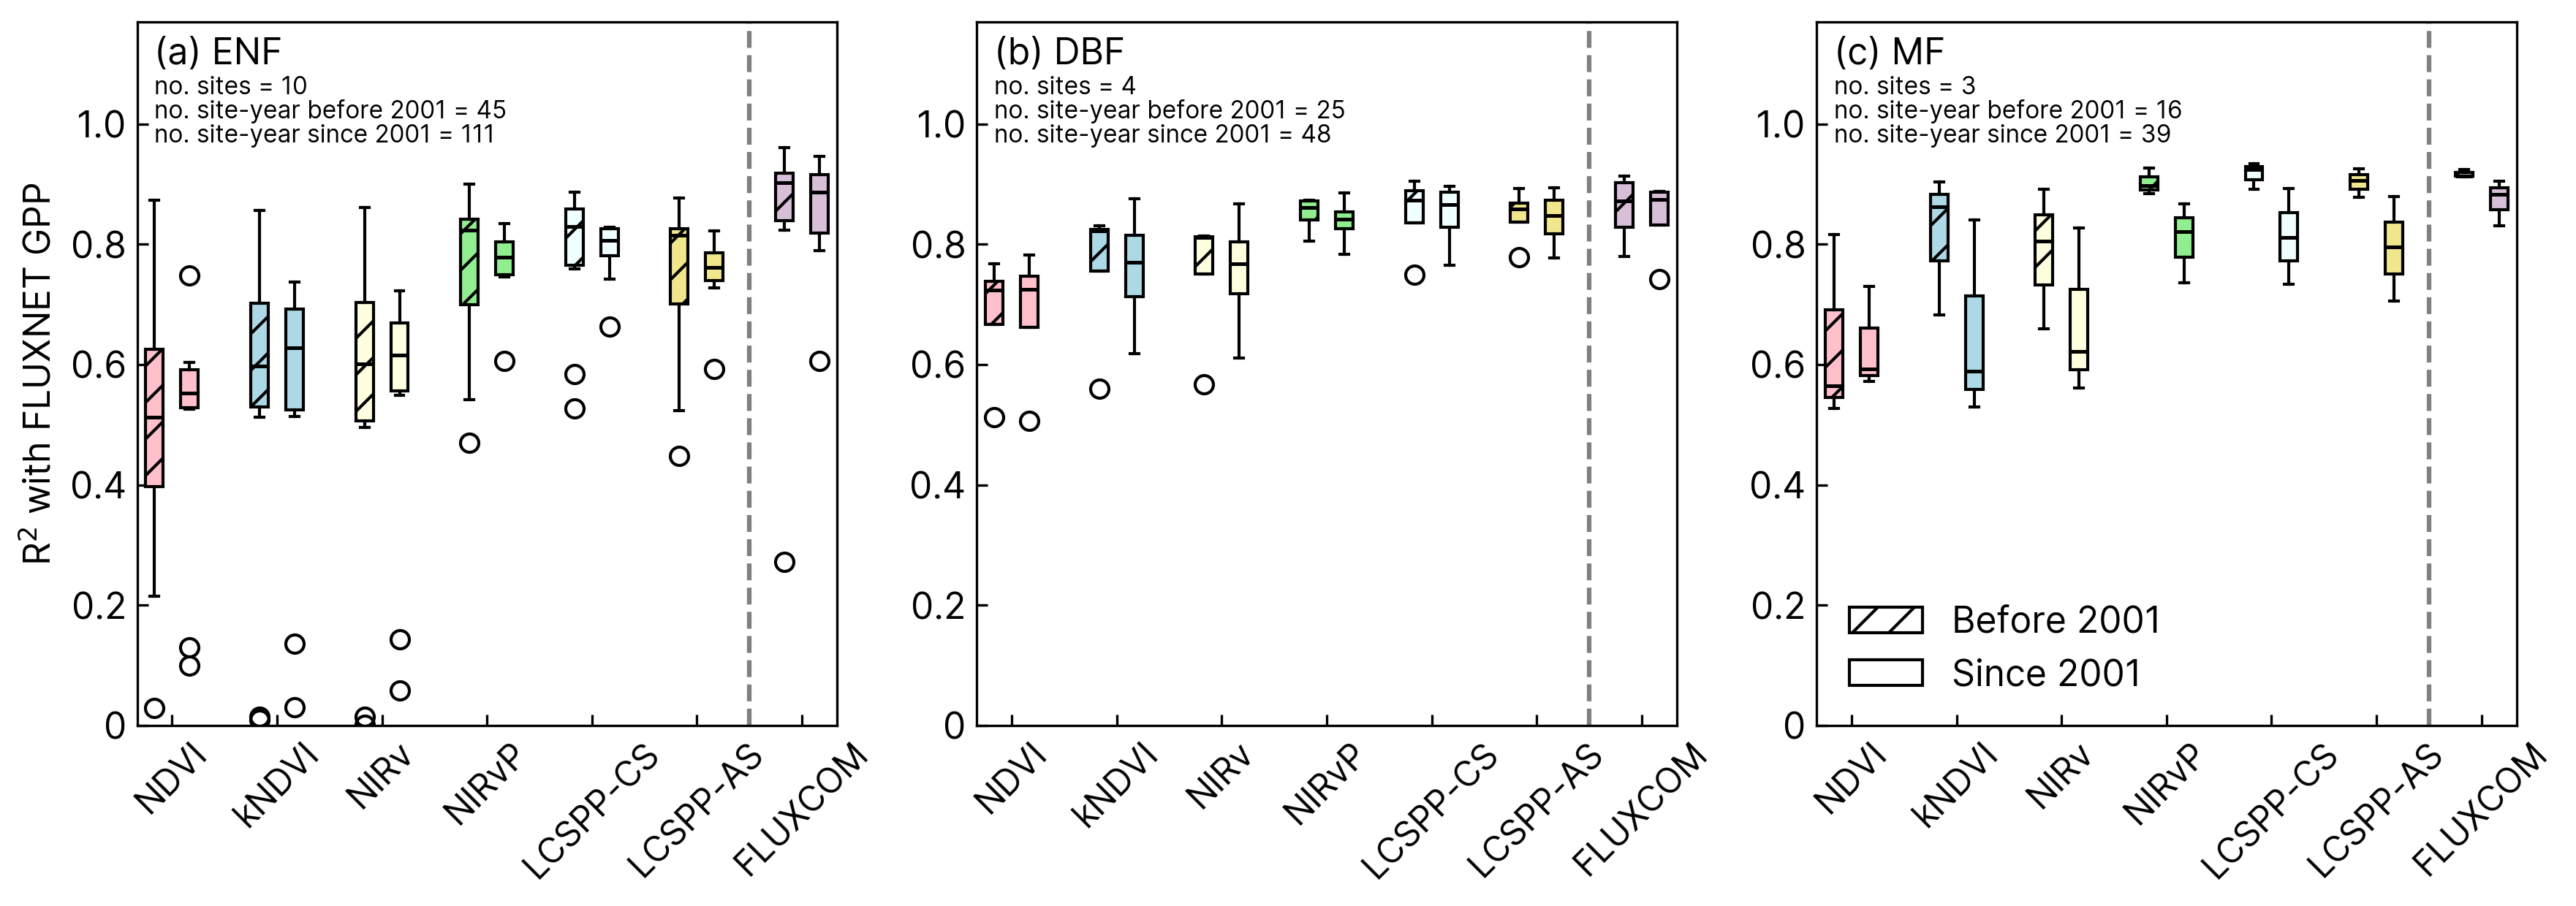

In [84]:
from matplotlib.patches import Patch
fig, axs = plt.subplots(1,3, figsize=(14,4.17), dpi=300)
ax = axs.flatten()
IGBP_types = ["ENF", "DBF", "MF"]
fig_labels = ["(a)", "(b)", "(c)"]
alpha = 0.05
for i in range(3):
    data=np.vstack([[ltdr_result_df[(ltdr_result_df["IGBP"]==IGBP_types[i]) 
                             & (ltdr_result_df["period"] == period) 
                             & (ltdr_result_df["type"]=="NDVI")]["R^2"] for period in ["PRE2001", "POST2001"]],
                    [ltdr_result_df[(ltdr_result_df["IGBP"]==IGBP_types[i]) 
                             & (ltdr_result_df["period"] == period) 
                             & (ltdr_result_df["type"]=="KNDVI_TEMPORAL")]["R^2"] for period in ["PRE2001", "POST2001"]],
                  [ltdr_result_df[(ltdr_result_df["IGBP"]==IGBP_types[i]) 
                             & (ltdr_result_df["period"] == period) 
                             & (ltdr_result_df["type"]=="NIRV")]["R^2"] for period in ["PRE2001", "POST2001"]],
                    [ltdr_result_df[(ltdr_result_df["IGBP"]==IGBP_types[i]) 
                             & (ltdr_result_df["period"] == period) 
                             & (ltdr_result_df["type"]=="NIRVP")]["R^2"] for period in ["PRE2001", "POST2001"]],
                    [ltdr_result_df[(ltdr_result_df["IGBP"]==IGBP_types[i]) 
                             & (ltdr_result_df["period"] == period) 
                             & (ltdr_result_df["type"]=="SIF")]["R^2"] for period in ["PRE2001", "POST2001"]],
                    [ltdr_result_df[(ltdr_result_df["IGBP"]==IGBP_types[i]) 
                             & (ltdr_result_df["period"] == period) 
                             & (ltdr_result_df["type"]=="SIFALL")]["R^2"] for period in ["PRE2001", "POST2001"]],
                   [ltdr_result_df[(ltdr_result_df["IGBP"]==IGBP_types[i]) 
                             & (ltdr_result_df["period"] == period) 
                             & (ltdr_result_df["type"]=="FLUXCOM")]["R^2"] for period in ["PRE2001", "POST2001"]]]).T
    bplot = ax[i].boxplot(data, positions=[1,2,4,5,7,8,10,11,13,14,16,17,19,20], patch_artist=True)
    ax[i].set_ylim(0,1.17)
    colors = ['pink', 'pink', 'lightblue', 'lightblue', 'lightyellow', 'lightyellow', 'lightgreen', 'lightgreen', 'azure', 'azure', 'khaki', 'khaki', 'thistle', 'thistle']
    hatchs = ['//', '', '//', '', '//', '', '//', '', '//', '', '//', '', '//', '']
    ax[i].set_xticks([1.5, 4.5, 7.5, 10.5, 13.5, 16.5, 19.5], labels=["NDVI", "kNDVI", "NIRv", "NIRvP", "LCSPP-CS", "LCSPP-AS", "FLUXCOM"], fontsize=11.5, rotation=45)
    ax[i].text(1, 0.9+0.15, "no. sites = " + str(len(meta_df[meta_df["IGBP"]==IGBP_types[i]])), fontsize=8)
    ax[i].text(1, 0.86+0.15, "no. site-year before 2001 = " + str(siteyear_df.loc[IGBP_types[i]]["AVHRR_YEARS"]), fontsize=8)
    ax[i].text(1, 0.82+0.15, "no. site-year since 2001 = " + str(siteyear_df.loc[IGBP_types[i]]["MODIS_YEARS"]), fontsize=8)
    ax[i].text(1,0.95+0.15, fig_labels[i] + " " + IGBP_types[i])
    ax[i].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0], ["0", "0.2", "0.4", "0.6", "0.8", "1.0"])
    data_types = ["NDVI", "KNDVI_TEMPORAL", "NIRV", "NIRVP", "SIF", "SIFALL", "FLUXCOM"]
    xloc=[1.25, 4.25, 7.25, 10.25, 13.25, 16.25, 19.25]
    for j in range(7):
        if ltdr_t_test_df[(ltdr_t_test_df["IGBP"]==IGBP_types[i]) & (ltdr_t_test_df["type"]==data_types[j])]["p"].item() < alpha:
            yloc = np.median(ltdr_result_df[(ltdr_result_df["IGBP"]==IGBP_types[i]) & (ltdr_result_df["period"] == "POST2001") & (ltdr_result_df["type"]==data_types[j])]["R^2"])
            ax[i].text(xloc[j], yloc, "*", color="blue")

    for patch, color, hatch in zip(bplot['boxes'], colors, hatchs):
        patch.set_facecolor(color)
        patch.set_hatch(hatch)
    
    for median in bplot['medians']:
        median.set(color ='black',
                   linewidth = 1.2)
    if i == 0:
        ax[i].set_ylabel("R$^2$ with FLUXNET GPP")
        
    if i == 2:
        legend_elements = [Patch(facecolor='white', edgecolor='black', hatch="//",
                             label='Before 2001'),
                       Patch(facecolor='white', edgecolor='black', hatch="",
                             label='Since 2001')]
        ax[i].legend(handles=legend_elements, loc='lower left', frameon=False)
        
    ax[i].plot([18,18], [0, 1.2], "--", c="grey")
    

#plt.savefig("./figs/FLUXNET_PRE-POST-2001.png", dpi=300)

In [86]:
t_test_lcsppclear_vs_vi = []
for IGBP in ["ENF", "DBF", "MF"]:        
    for period in ["PRE2001", "POST2001"]:
        for data_type in ["NDVI", "KNDVI","NIRV", "NIRVP", "SIFALL", "FLUXCOM"]:
            v1=result_df[(result_df["period"] == period) & (result_df["IGBP"] == IGBP) & (result_df["type"] == data_type)]["R^2"].values
            v2=result_df[(result_df["period"] == period) & (result_df["IGBP"] == IGBP) & (result_df["type"] == "SIF")]["R^2"].values
            if data_type == "FLUXCOM" or data_type == "NIRVP" or data_type == "SIFALL":
                t_res = ttest_rel(v1, v2)
            else:
                t_res = ttest_rel(v1, v2, alternative="less")
            if data_type == "SIFALL":
                t_test_lcsppclear_vs_vi.append({"IGBP":IGBP, "LCSPP_clear vs.": "LCSPP_all", "period":period, "df": len(v1) - 1, "t":t_res.statistic, "p":t_res.pvalue })
            else:
                 t_test_lcsppclear_vs_vi.append({"IGBP":IGBP, "LCSPP_clear vs.": data_type, "period":period, "df": len(v1) - 1, "t":t_res.statistic, "p":t_res.pvalue })
t_test_lcsppclear_vs_vi_df = pd.DataFrame(t_test_lcsppclear_vs_vi)

In [87]:
t_test_lcsppclear_vs_vi_df

,IGBP,LCSPP_clear vs.,period,df,t,p
0,ENF,NDVI,PRE2001,9,-5.666538,0.000154
1,ENF,KNDVI,PRE2001,9,-5.322932,0.000240
2,ENF,NIRV,PRE2001,9,-4.488609,0.000757
3,ENF,NIRVP,PRE2001,9,-2.162721,0.058806
4,ENF,LCSPP_all,PRE2001,9,-2.796906,0.020818
5,ENF,FLUXCOM,PRE2001,9,0.076379,0.940789
6,ENF,NDVI,POST2001,9,-4.996058,0.000371
7,ENF,KNDVI,POST2001,9,-4.665647,0.000588
8,ENF,NIRV,POST2001,9,-3.652118,0.002650
9,ENF,NIRVP,POST2001,9,-2.240191,0.051827


In [88]:
t_test_lcsppclear_vs_vi_df.to_csv("lcspp_clear_to_vi_t_test_long_term_sites_only.csv", index=False)

In [89]:
t_test_lcsppall_vs_vi = []
for IGBP in ["ENF", "DBF", "MF"]:        
    for period in ["PRE2001", "POST2001"]:
        for data_type in ["NDVI", "KNDVI","NIRV", "NIRVP", "SIF", "FLUXCOM"]:
            v1=result_df[(result_df["period"] == period) & (result_df["IGBP"] == IGBP) & (result_df["type"] == data_type)]["R^2"].values
            v2=result_df[(result_df["period"] == period) & (result_df["IGBP"] == IGBP) & (result_df["type"] == "SIFALL")]["R^2"].values
            if data_type == "FLUXCOM" or data_type == "NIRVP" or data_type == "SIF":
                t_res = ttest_rel(v1, v2)
            else:
                t_res = ttest_rel(v1, v2, alternative="less")
            if data_type == "SIF":
                t_test_lcsppall_vs_vi.append({"IGBP":IGBP, "LCSPP_all vs.":"LCSPP_clear", "period":period, "df": len(v1) - 1, "t":t_res.statistic, "p":t_res.pvalue })
            else:
                t_test_lcsppall_vs_vi.append({"IGBP":IGBP, "LCSPP_all vs.":data_type, "period":period, "df": len(v1) - 1, "t":t_res.statistic, "p":t_res.pvalue })
t_test_lcsppall_vs_vi_df = pd.DataFrame(t_test_lcsppall_vs_vi)

In [90]:
t_test_lcsppall_vs_vi_df

,IGBP,LCSPP_all vs.,period,df,t,p
0,ENF,NDVI,PRE2001,9,-5.493643,0.000192
1,ENF,KNDVI,PRE2001,9,-5.118925,0.000314
2,ENF,NIRV,PRE2001,9,-4.144276,0.001253
3,ENF,NIRVP,PRE2001,9,-0.120746,0.906545
4,ENF,LCSPP_clear,PRE2001,9,2.796906,0.020818
5,ENF,FLUXCOM,PRE2001,9,0.812151,0.437658
6,ENF,NDVI,POST2001,9,-4.769667,0.000508
7,ENF,KNDVI,POST2001,9,-4.415250,0.000841
8,ENF,NIRV,POST2001,9,-3.326365,0.004425
9,ENF,NIRVP,POST2001,9,-0.895561,0.393809


In [91]:
t_test_lcsppall_vs_vi_df.to_csv("lccspp_all_to_vi_t_test_long_term_sites_only.csv", index=False)



## Now Look At All Sites

In [3]:
SITE_ALL = "AVHRR/data/all_modis_period_fluxnet_sites.csv"
meta_df = pd.read_csv(SITE_ALL)
meta_df.replace('WSA', 'SAV', inplace=True)
meta_df.replace('OSH', 'SH', inplace=True)
meta_df.replace('CSH', 'SH', inplace=True)
meta_df.replace('ENF', 'NF', inplace=True)
meta_df.replace('DNF', 'NF', inplace=True)


In [ ]:
extracted_allsite_lcspp = []
extracted_allsite_lcsppall = []
for file in tqdm(LCSPP_FILE_LIST[10*24:]):
    ds = xr.open_dataset(file)
    lcsppclear_daily = np.diag(ds.lcspp_clear_daily.sel(lat = meta_df.LAT.values, lon = meta_df.LON.values, method="nearest")[0].values)
    lcsppall_daily = np.diag(ds.lcspp_all_daily.sel(lat = meta_df.LAT.values, lon = meta_df.LON.values, method="nearest")[0].values)
    extracted_allsite_lcspp.append(lcsppclear_daily)
    extracted_allsite_lcsppall.append(lcsppall_daily)
    
    
modis_extracted_allsite_lcspp = []
modis_extracted_allsite_lcsppall = []
for file in tqdm(MODIS_LCSPP_FILE_LIST):
    ds = xr.open_dataset(file)
    lcsppclear_daily = np.diag(ds.lcspp_clear_daily.sel(lat = meta_df.LAT.values, lon = meta_df.LON.values, method="nearest")[0].values)
    lcsppall_daily = np.diag(ds.lcspp_all_daily.sel(lat = meta_df.LAT.values, lon = meta_df.LON.values, method="nearest")[0].values)
    modis_extracted_allsite_lcspp.append(lcsppclear_daily)
    modis_extracted_allsite_lcsppall.append(lcsppall_daily)
    
    
extracted_allsite_red = []
extracted_allsite_nir = []

for file in tqdm(LCREF_FILE_LIST[10*24:]):
    ds_red = xr.open_dataset(file).red
    ds_nir = xr.open_dataset(file).nir
    red_site = np.diag(ds_red.sel(lat = meta_df.LAT.values, lon = meta_df.LON.values, method="nearest")[0].values)
    nir_site = np.diag(ds_nir.sel(lat = meta_df.LAT.values, lon = meta_df.LON.values, method="nearest")[0].values)
    extracted_allsite_red.append(red_site)
    extracted_allsite_nir.append(nir_site)
    
modis_extracted_allsite_red = []
modis_extracted_allsite_nir = []

for file in tqdm(MODIS_LCREF_FILE_LIST):
    ds_red = xr.open_dataset(file).red
    ds_nir = xr.open_dataset(file).nir
    red_site = np.diag(ds_red.sel(lat = meta_df.LAT.values, lon = meta_df.LON.values, method="nearest")[0].values)
    nir_site = np.diag(ds_nir.sel(lat = meta_df.LAT.values, lon = meta_df.LON.values, method="nearest")[0].values)
    modis_extracted_allsite_red.append(red_site)
    modis_extracted_allsite_nir.append(nir_site)
    
extracted_allsite_ssrd = []
for file in tqdm(ERA_5_CMG_LIST[19*24:33*24]):
    ds_ssrd = np.flip(xr.open_dataset(file).Band1, axis=0)
    ssrd_site = np.diag(ds_ssrd.sel(lat = meta_df.LAT.values, lon = meta_df.LON.values, method="nearest").values)
    extracted_allsite_ssrd.append(ssrd_site)

In [6]:
ltdr_extracted_allsite_lcspp = []
ltdr_extracted_allsite_lcsppall = []
for file in tqdm(LTDR_LCSPP_FILE_LIST[10*24:]):
    ds = xr.open_dataset(file)
    lcsppclear_daily = np.diag(ds.lcspp_clear_daily.sel(lat = meta_df.LAT.values, lon = meta_df.LON.values, method="nearest")[0].values)
    lcsppall_daily = np.diag(ds.lcspp_all_daily.sel(lat = meta_df.LAT.values, lon = meta_df.LON.values, method="nearest")[0].values)
    ltdr_extracted_allsite_lcspp.append(lcsppclear_daily)
    ltdr_extracted_allsite_lcsppall.append(lcsppall_daily)
    
ltdr_extracted_allsite_red = []
ltdr_extracted_allsite_nir = []

for file in tqdm(LTDR_LCREF_FILE_LIST[10*24:]):
    ds_red = xr.open_dataset(file).red
    ds_nir = xr.open_dataset(file).nir
    red_site = np.diag(ds_red.sel(lat = meta_df.LAT.values, lon = meta_df.LON.values, method="nearest")[0].values)
    nir_site = np.diag(ds_nir.sel(lat = meta_df.LAT.values, lon = meta_df.LON.values, method="nearest")[0].values)
    ltdr_extracted_allsite_red.append(red_site)
    ltdr_extracted_allsite_nir.append(nir_site)

100%|███████████████████████████████████████| 336/336 [11:18<00:00,  2.02s/it]


In [9]:
ltdr_allsite_red = np.stack(ltdr_extracted_allsite_red)
ltdr_allsite_nir = np.stack(ltdr_extracted_allsite_nir)
ltdr_allsite_lcspp = np.stack(ltdr_extracted_allsite_lcspp)
ltdr_allsite_ssrd = np.stack(extracted_allsite_ssrd)

ltdr_allsite_lcsppall = np.stack(ltdr_extracted_allsite_lcsppall)
ltdr_allsite_ndvi = (ltdr_allsite_nir - ltdr_allsite_red) / (ltdr_allsite_nir + ltdr_allsite_red)
ltdr_allsite_nirv = ltdr_allsite_ndvi * ltdr_allsite_nir
ltdr_allsite_ssrd = deepcopy(ltdr_allsite_ssrd)
ltdr_allsite_nirvp = ltdr_allsite_nirv * ltdr_allsite_ssrd
ltdr_allsite_sigma = 0.5 * (ltdr_allsite_red + ltdr_allsite_nir)
ltdr_allsite_kndvi = np.tanh(((ltdr_allsite_nir-ltdr_allsite_red) / (2 * ltdr_allsite_sigma))**2)
ltdr_allsite_sigma_temporal = np.mean(np.abs(ltdr_allsite_nir - ltdr_allsite_red), axis=0)
ltdr_allsite_kndvi_temporal = np.tanh(((ltdr_allsite_nir-ltdr_allsite_red) / (2 * ltdr_allsite_sigma_temporal))**2)


In [53]:
allsite_red = np.stack(extracted_allsite_red)
allsite_nir = np.stack(extracted_allsite_nir)
allsite_lcspp = np.stack(extracted_allsite_lcspp)
allsite_lcsppall = np.stack(extracted_allsite_lcsppall)     

modis_allsite_red = np.stack(modis_extracted_allsite_red)
modis_allsite_nir = np.stack(modis_extracted_allsite_nir)
modis_allsite_lcspp = np.stack(modis_extracted_allsite_lcspp)
modis_allsite_lcsppall = np.stack(modis_extracted_allsite_lcsppall)

allsite_ssrd = np.stack(extracted_allsite_ssrd)
modis_allsite_ssrd = deepcopy(allsite_ssrd[-14*24:, :])

allsite_ndvi = (allsite_nir - allsite_red) / (allsite_nir + allsite_red)
allsite_nirv = allsite_ndvi * allsite_nir
allsite_nirvp = allsite_nirv * allsite_ssrd
allsite_sigma = 0.5 * (allsite_red + allsite_nir)
allsite_kndvi = np.tanh(((allsite_nir-allsite_red) / (2 * allsite_sigma))**2)
allsite_sigma_temporal = np.mean(np.abs(allsite_nir - allsite_red), axis=0)
allsite_kndvi_temporal = np.tanh(((allsite_nir-allsite_red) / (2 * allsite_sigma_temporal))**2)


modis_allsite_ndvi = (modis_allsite_nir - modis_allsite_red) / (modis_allsite_nir + modis_allsite_red)
modis_allsite_nirv = modis_allsite_ndvi * modis_allsite_nir
modis_allsite_nirvp = modis_allsite_nirv * modis_allsite_ssrd
modis_allsite_sigma = 0.5 * (modis_allsite_red + modis_allsite_nir)
modis_allsite_kndvi = np.tanh(((modis_allsite_nir-modis_allsite_red) / (2 * modis_allsite_sigma))**2)
modis_allsite_sigma_temporal = np.mean(np.abs(modis_allsite_nir - modis_allsite_red), axis=0)
modis_allsite_kndvi_temporal = np.tanh(((modis_allsite_nir-modis_allsite_red) / (2 * modis_allsite_sigma_temporal))**2)


In [58]:
np.save("AVHRR/data/processed/avhrr_allsite_2001-2014_lcref_red.npy", allsite_red)
np.save("AVHRR/data/processed/avhrr_allsite_2001-2014_lcref_nir.npy", allsite_nir)
np.save("AVHRR/data/processed/avhrr_allsite_2001-2014_lcspp.npy", allsite_lcspp)
np.save("AVHRR/data/processed/avhrr_allsite_2001-2014_lcspp_all.npy", allsite_lcsppall)


np.save("AVHRR/data/processed/modis_allsite_2001-2014_lcref_red.npy", modis_allsite_red)
np.save("AVHRR/data/processed/modis_allsite_2001-2014_lcref_nir.npy", modis_allsite_nir)
np.save("AVHRR/data/processed/modis_allsite_2001-2014_lcspp.npy", modis_allsite_lcspp)
np.save("AVHRR/data/processed/modis_allsite_2001-2014_lcspp_all.npy", modis_allsite_lcsppall)

np.save("AVHRR/data/processed/avhrr_allsite_2001-2014_ssrd.npy", allsite_ssrd)
np.save("AVHRR/data/processed/modis_allsite_2001-2014_ssrd.npy", modis_allsite_ssrd)


np.save("AVHRR/data/processed/avhrr_allsite_2001-2014_ndvi.npy", allsite_ndvi)
np.save("AVHRR/data/processed/avhrr_allsite_2001-2014_nirv.npy", allsite_nirv)
np.save("AVHRR/data/processed/avhrr_allsite_2001-2014_nirvp.npy", allsite_nirvp)
np.save("AVHRR/data/processed/avhrr_allsite_2001-2014_kndvi.npy", allsite_kndvi)
np.save("AVHRR/data/processed/allsite_2001-2014_kndvi_temporal.npy", allsite_kndvi)

np.save("AVHRR/data/processed/modis_allsite_2001-2014_ndvi.npy", modis_allsite_ndvi)
np.save("AVHRR/data/processed/modis_allsite_2001-2014_nirv.npy", modis_allsite_nirv)
np.save("AVHRR/data/processed/modis_allsite_2001-2014_nirvp.npy", modis_allsite_nirvp)
np.save("AVHRR/data/processed/modis_allsite_2001-2014_kndvi.npy", modis_allsite_kndvi)
np.save("AVHRR/data/processed/modis_allsite_2001-2014_kndvi_temporal.npy", modis_allsite_kndvi)

In [10]:
np.save("AVHRR/data/processed/ltdr_allsite_2001-2014_lcref_red.npy", ltdr_allsite_red)
np.save("AVHRR/data/processed/ltdr_allsite_2001-2014_lcref_nir.npy", ltdr_allsite_nir)
np.save("AVHRR/data/processed/ltdr_allsite_2001-2014_lcspp.npy", ltdr_allsite_lcspp)
np.save("AVHRR/data/processed/ltdr_allsite_2001-2014_lcspp_all.npy", ltdr_allsite_lcsppall)
np.save("AVHRR/data/processed/ltdr_allsite_2001-2014_ssrd.npy", ltdr_allsite_ssrd)
np.save("AVHRR/data/processed/ltdr_allsite_2001-2014_ndvi.npy", ltdr_allsite_ndvi)
np.save("AVHRR/data/processed/ltdr_allsite_2001-2014_nirv.npy", ltdr_allsite_nirv)
np.save("AVHRR/data/processed/ltdr_allsite_2001-2014_nirvp.npy", ltdr_allsite_nirvp)
np.save("AVHRR/data/processed/ltdr_allsite_2001-2014_kndvi.npy", ltdr_allsite_kndvi)
np.save("AVHRR/data/processed/ltdr_allsite_2001-2014_kndvi_temporal.npy", ltdr_allsite_kndvi)

In [11]:
allsite_red = np.load("AVHRR/data/processed/avhrr_allsite_2001-2014_lcref_red.npy")
allsite_nir = np.load("AVHRR/data/processed/avhrr_allsite_2001-2014_lcref_nir.npy")
allsite_lcspp = np.load("AVHRR/data/processed/avhrr_allsite_2001-2014_lcspp.npy")
allsite_lcsppall = np.load("AVHRR/data/processed/avhrr_allsite_2001-2014_lcspp_all.npy")

modis_allsite_red = np.load("AVHRR/data/processed/modis_allsite_2001-2014_lcref_red.npy")
modis_allsite_nir = np.load("AVHRR/data/processed/modis_allsite_2001-2014_lcref_nir.npy")
modis_allsite_lcspp = np.load("AVHRR/data/processed/modis_allsite_2001-2014_lcspp.npy")
modis_allsite_lcsppall = np.load("AVHRR/data/processed/modis_allsite_2001-2014_lcspp_all.npy")

allsite_ssrd = np.load("AVHRR/data/processed/avhrr_allsite_2001-2014_ssrd.npy")
modis_allsite_ssrd = np.load("AVHRR/data/processed/modis_allsite_2001-2014_ssrd.npy")

allsite_ndvi = np.load("AVHRR/data/processed/avhrr_allsite_2001-2014_ndvi.npy")
allsite_nirv = np.load("AVHRR/data/processed/avhrr_allsite_2001-2014_nirv.npy")
allsite_nirvp = np.load("AVHRR/data/processed/avhrr_allsite_2001-2014_nirvp.npy")
allsite_kndvi = np.load("AVHRR/data/processed/avhrr_allsite_2001-2014_kndvi.npy")
allsite_kndvi_temporal = np.load("AVHRR/data/processed/allsite_2001-2014_kndvi_temporal.npy")


modis_allsite_ndvi = np.load("AVHRR/data/processed/modis_allsite_2001-2014_ndvi.npy")
modis_allsite_nirv = np.load("AVHRR/data/processed/modis_allsite_2001-2014_nirv.npy")
modis_allsite_nirvp = np.load("AVHRR/data/processed/modis_allsite_2001-2014_nirvp.npy")
modis_allsite_kndvi = np.load("AVHRR/data/processed/modis_allsite_2001-2014_kndvi.npy")
modis_allsite_kndvi_temporal = np.load("AVHRR/data/processed/modis_allsite_2001-2014_kndvi_temporal.npy")
date_list = []
for year in np.arange(2001, 2015):
    for month in np.arange(1, 13):
        for day in [8, 22]:
            date_list.append(date(year, month, day))
dl = np.array(date_list)

In [12]:
ltdr_allsite_red = np.load("AVHRR/data/processed/ltdr_allsite_2001-2014_lcref_red.npy")
ltdr_allsite_nir = np.load("AVHRR/data/processed/ltdr_allsite_2001-2014_lcref_nir.npy")
ltdr_allsite_lcspp = np.load("AVHRR/data/processed/ltdr_allsite_2001-2014_lcspp.npy")
ltdr_allsite_lcsppall = np.load("AVHRR/data/processed/ltdr_allsite_2001-2014_lcspp_all.npy")
ltdr_allsite_ssrd = np.load("AVHRR/data/processed/ltdr_allsite_2001-2014_ssrd.npy")

ltdr_allsite_ndvi = np.load("AVHRR/data/processed/ltdr_allsite_2001-2014_ndvi.npy")
ltdr_allsite_nirv = np.load("AVHRR/data/processed/ltdr_allsite_2001-2014_nirv.npy")
ltdr_allsite_nirvp = np.load("AVHRR/data/processed/ltdr_allsite_2001-2014_nirvp.npy")
ltdr_allsite_kndvi = np.load("AVHRR/data/processed/ltdr_allsite_2001-2014_kndvi.npy")
ltdr_allsite_kndvi_temporal = np.load("AVHRR/data/processed/ltdr_allsite_2001-2014_kndvi_temporal.npy")

In [19]:
result_list=[]
for i in range(len(meta_df)):
    sitename =  meta_df["SITE_ID"][i]
    site_dir = os.path.join(FLUXNET_DIR, sitename)
    flux_df = pd.read_csv(os.path.join(site_dir, os.listdir(site_dir)[0]))

    GPP = deepcopy(flux_df.GPP_NT_VUT_REF)
    GPP[GPP==-9999]=np.nan
    GPP = pd.Series(GPP.values, index = pd.to_datetime(flux_df.TIMESTAMP, format='%Y%m%d'))
    GPP = GPP.reindex(pd.date_range(max(str(flux_df.TIMESTAMP.iloc[0])[0:4], "2001"+"-01-01"),min(str(flux_df.TIMESTAMP.iloc[-1])[0:4]+"-12-31", "2014-12-31"), freq="D"))

    FLUXCOM_XBASE_GPP = xr.open_dataset(os.path.join(FLUXCOM_XBASE_DIR, sitename + "_FLUXCOM_XBASE.nc")).GPP.to_dataframe()["GPP"]
    FLUXCOM_XBASE_GPP = FLUXCOM_XBASE_GPP.reindex(pd.date_range(max(str(flux_df.TIMESTAMP.iloc[0])[0:4], "2001"+"-01-01"),min(str(flux_df.TIMESTAMP.iloc[-1])[0:4]+"-12-31", "2014-12-31"), freq="D"))

    FLUXCOM_GPP = xr.open_dataset(os.path.join(FLUXCOM_DIR, sitename + "_FLUXCOM_SUBSET.nc")).GPP.to_dataframe()["GPP"]
    FLUXCOM_GPP = FLUXCOM_GPP.reindex(pd.date_range(max(str(flux_df.TIMESTAMP.iloc[0])[0:4], "2001"+"-01-01"),min(str(flux_df.TIMESTAMP.iloc[-1])[0:4]+"-12-31", "2014-12-31"), freq="D"))

    start_idx = np.argmax(dl > date(max(np.int64(str(flux_df.TIMESTAMP.iloc[0])[0:4]), 2001), 1, 1))
    end_idx = np.argmax(dl > date(min(np.int64(str(flux_df.TIMESTAMP.iloc[-1])[0:4])+1, 2015), 1, 1))
    if end_idx == 0:
        end_idx = len(dl)
    lcsppbiweekly = allsite_lcspp[start_idx:end_idx, i]
    lcsppALL_biweekly = allsite_lcsppall[start_idx:end_idx, i]
    NDVI_biweekly = allsite_ndvi[start_idx:end_idx, i]
    NIRV_biweekly = allsite_nirv[start_idx:end_idx, i]
    NIRVP_biweekly = allsite_nirvp[start_idx:end_idx, i]

    KNDVI_biweekly = allsite_kndvi[start_idx:end_idx, i]
    KNDVI_TEMPORAL_biweekly = allsite_kndvi_temporal[start_idx:end_idx, i]

    DL = pd.to_datetime(dl[start_idx:end_idx])

    GPP_biweekly = aggregate_biweekly(GPP)
    FLUXCOM_GPP_biweekly = aggregate_biweekly(FLUXCOM_GPP)
    FLUXCOM_XBASE_GPP_biweekly = aggregate_biweekly(FLUXCOM_XBASE_GPP)

    QC = deepcopy(flux_df.NEE_VUT_REF_QC)
    QC[QC==-9999]=np.nan
    QC = pd.Series(QC.values, index = pd.to_datetime(flux_df.TIMESTAMP, format='%Y%m%d'))
    QC = QC.reindex(pd.date_range(max(str(flux_df.TIMESTAMP.iloc[0])[0:4], "2001"+"-01-01"),
                        
                                  min(str(flux_df.TIMESTAMP.iloc[-1])[0:4]+"-12-31", "2014-12-31"), freq="D"))
    QC_biweekly = aggregate_biweekly(QC)
    not_nan_sel_modis = np.invert(np.isnan(lcsppbiweekly) | np.isnan(GPP_biweekly)) & (QC_biweekly > 0.7)

    if np.sum(not_nan_sel_modis) > 0:
        AVHRR_lcsppreg = linregress((lcsppbiweekly)[not_nan_sel_modis], (GPP_biweekly)[not_nan_sel_modis])
        result_list.append({"SITE_ID":sitename, "sensor":"AVHRR", "type":"LCSPP", "R^2":AVHRR_lcsppreg.rvalue**2, 
                            "slope":AVHRR_lcsppreg.slope, "intercept":AVHRR_lcsppreg.intercept})

        AVHRR_lcsppALL_reg = linregress((lcsppALL_biweekly)[not_nan_sel_modis], (GPP_biweekly)[not_nan_sel_modis])
        result_list.append({"SITE_ID":sitename, "sensor":"AVHRR", "type":"LCSPP_ALL", "R^2":AVHRR_lcsppALL_reg.rvalue**2,
                           "slope":AVHRR_lcsppALL_reg.slope, "intercept":AVHRR_lcsppALL_reg.intercept})

        AVHRR_NDVI_reg = linregress((NDVI_biweekly)[not_nan_sel_modis], (GPP_biweekly)[not_nan_sel_modis]) 
        result_list.append({"SITE_ID":sitename, "sensor":"AVHRR", "type":"LCREF_NDVI", "R^2":AVHRR_NDVI_reg.rvalue**2,
                           "slope":AVHRR_NDVI_reg.slope, "intercept":AVHRR_NDVI_reg.intercept})

        AVHRR_NIRV_reg = linregress((NIRV_biweekly)[not_nan_sel_modis], (GPP_biweekly)[not_nan_sel_modis]) 
        result_list.append({"SITE_ID":sitename, "sensor":"AVHRR", "type":"LCREF_NIRV", "R^2":AVHRR_NIRV_reg.rvalue**2,
                           "slope":AVHRR_NIRV_reg.slope, "intercept":AVHRR_NIRV_reg.intercept})

        AVHRR_NIRVP_reg = linregress((NIRVP_biweekly)[not_nan_sel_modis], (GPP_biweekly)[not_nan_sel_modis]) 
        result_list.append({"SITE_ID":sitename, "sensor":"AVHRR", "type":"LCREF_NIRVP", "R^2":AVHRR_NIRVP_reg.rvalue**2,
                           "slope":AVHRR_NIRVP_reg.slope, "intercept":AVHRR_NIRVP_reg.intercept})

        AVHRR_KNDVI_reg = linregress((KNDVI_biweekly)[not_nan_sel_modis], (GPP_biweekly)[not_nan_sel_modis]) 
        result_list.append({"SITE_ID":sitename, "sensor":"AVHRR", "type":"LCREF_KNDVI", "R^2":AVHRR_KNDVI_reg.rvalue**2,
                           "slope":AVHRR_KNDVI_reg.slope, "intercept":AVHRR_KNDVI_reg.intercept})

        AVHRR_KNDVI_TEMPORAL_reg = linregress((KNDVI_TEMPORAL_biweekly)[not_nan_sel_modis], (GPP_biweekly)[not_nan_sel_modis]) 
        result_list.append({"SITE_ID":sitename, "sensor":"AVHRR", "type":"LCREF_KNDVI_TEMPORAL", "R^2":AVHRR_KNDVI_TEMPORAL_reg.rvalue**2,
                           "slope":AVHRR_KNDVI_TEMPORAL_reg.slope, "intercept":AVHRR_KNDVI_TEMPORAL_reg.intercept})

        try:
            AVHRR_FLUXCOM_GPP_reg = linregress((FLUXCOM_GPP_biweekly)[not_nan_sel_modis], (GPP_biweekly)[not_nan_sel_modis]) 
            result_list.append({"SITE_ID":sitename, "sensor":"AVHRR", "type":"FLUXCOM", "R^2":AVHRR_FLUXCOM_GPP_reg.rvalue**2, 
                            "slope":AVHRR_FLUXCOM_GPP_reg.slope, "intercept":AVHRR_FLUXCOM_GPP_reg.intercept})
        except ValueError:
            result_list.append({"SITE_ID":sitename, "sensor":"AVHRR", "type":"FLUXCOM", "R^2":np.nan, "slope":np.nan, "incercept":np.nan})

        try:
            AVHRR_FLUXCOM_XBASE_GPP_reg = linregress((FLUXCOM_XBASE_GPP_biweekly)[not_nan_sel_modis], (GPP_biweekly)[not_nan_sel_modis]) 
            result_list.append({"SITE_ID":sitename, "sensor":"AVHRR", "type":"FLUXCOM_XBASE", "R^2":AVHRR_FLUXCOM_XBASE_GPP_reg.rvalue**2,
                             "slope":AVHRR_FLUXCOM_XBASE_GPP_reg.slope, "intercept":AVHRR_FLUXCOM_XBASE_GPP_reg.intercept})
        except ValueError:
            result_list.append({"SITE_ID":sitename, "sensor":"AVHRR", "type":"FLUXCOM_XBASE", "R^2":np.nan, "slope":np.nan, "incercept":np.nan})

In [20]:
modis_result_list=[]
for i in range(len(meta_df)):
    sitename =  meta_df["SITE_ID"][i]
    site_dir = os.path.join(FLUXNET_DIR, sitename)
    flux_df = pd.read_csv(os.path.join(site_dir, os.listdir(site_dir)[0]))

    GPP = deepcopy(flux_df.GPP_NT_VUT_REF)
    GPP[GPP==-9999]=np.nan
    GPP = pd.Series(GPP.values, index = pd.to_datetime(flux_df.TIMESTAMP, format='%Y%m%d'))
    GPP = GPP.reindex(pd.date_range(max(str(flux_df.TIMESTAMP.iloc[0])[0:4], "2001"+"-01-01"),min(str(flux_df.TIMESTAMP.iloc[-1])[0:4]+"-12-31", "2014-12-31"), freq="D"))

    FLUXCOM_XBASE_GPP = xr.open_dataset(os.path.join(FLUXCOM_XBASE_DIR, sitename + "_FLUXCOM_XBASE.nc")).GPP.to_dataframe()["GPP"]
    FLUXCOM_XBASE_GPP = FLUXCOM_XBASE_GPP.reindex(pd.date_range(max(str(flux_df.TIMESTAMP.iloc[0])[0:4], "2001"+"-01-01"),min(str(flux_df.TIMESTAMP.iloc[-1])[0:4]+"-12-31", "2014-12-31"), freq="D"))

    FLUXCOM_GPP = xr.open_dataset(os.path.join(FLUXCOM_DIR, sitename + "_FLUXCOM_SUBSET.nc")).GPP.to_dataframe()["GPP"]
    FLUXCOM_GPP = FLUXCOM_GPP.reindex(pd.date_range(max(str(flux_df.TIMESTAMP.iloc[0])[0:4], "2001"+"-01-01"),min(str(flux_df.TIMESTAMP.iloc[-1])[0:4]+"-12-31", "2014-12-31"), freq="D"))

    start_idx = np.argmax(dl > date(max(np.int64(str(flux_df.TIMESTAMP.iloc[0])[0:4]), 2001), 1, 1))
    end_idx = np.argmax(dl > date(min(np.int64(str(flux_df.TIMESTAMP.iloc[-1])[0:4])+1, 2015), 1, 1))
    if end_idx == 0:
        end_idx = len(dl)
    lcsppbiweekly =  modis_allsite_lcspp[start_idx:end_idx, i]
    lcsppALL_biweekly = modis_allsite_lcsppall[start_idx:end_idx, i]
    NDVI_biweekly = modis_allsite_ndvi[start_idx:end_idx, i]
    NIRV_biweekly = modis_allsite_nirv[start_idx:end_idx, i]
    NIRVP_biweekly = modis_allsite_nirvp[start_idx:end_idx, i]

    KNDVI_biweekly = modis_allsite_kndvi[start_idx:end_idx, i]
    KNDVI_TEMPORAL_biweekly = modis_allsite_kndvi_temporal[start_idx:end_idx, i]

    DL = pd.to_datetime(dl[start_idx:end_idx])

    GPP_biweekly = aggregate_biweekly(GPP)
    FLUXCOM_GPP_biweekly = aggregate_biweekly(FLUXCOM_GPP)
    FLUXCOM_XBASE_GPP_biweekly = aggregate_biweekly(FLUXCOM_XBASE_GPP)

    QC = deepcopy(flux_df.NEE_VUT_REF_QC)
    QC[QC==-9999]=np.nan
    QC = pd.Series(QC.values, index = pd.to_datetime(flux_df.TIMESTAMP, format='%Y%m%d'))
    QC = QC.reindex(pd.date_range(max(str(flux_df.TIMESTAMP.iloc[0])[0:4], "2001"+"-01-01"),min(str(flux_df.TIMESTAMP.iloc[-1])[0:4]+"-12-31", "2014-12-31"), freq="D"))
    QC_biweekly = aggregate_biweekly(QC)
    not_nan_sel_modis = np.invert(np.isnan(lcsppbiweekly) | np.isnan(GPP_biweekly)) & (QC_biweekly > 0.7)

    if np.sum(not_nan_sel_modis) > 0:
        MODIS_lcsppreg = linregress((lcsppbiweekly)[not_nan_sel_modis], (GPP_biweekly)[not_nan_sel_modis])
        modis_result_list.append({"SITE_ID":sitename, "sensor":"MODIS", "type":"LCSPP", "R^2":MODIS_lcsppreg.rvalue**2, 
                            "slope":MODIS_lcsppreg.slope, "intercept":MODIS_lcsppreg.intercept})

        MODIS_lcsppALL_reg = linregress((lcsppALL_biweekly)[not_nan_sel_modis], (GPP_biweekly)[not_nan_sel_modis])
        modis_result_list.append({"SITE_ID":sitename, "sensor":"MODIS", "type":"LCSPP_ALL", "R^2":MODIS_lcsppALL_reg.rvalue**2,
                           "slope":MODIS_lcsppALL_reg.slope, "intercept":MODIS_lcsppALL_reg.intercept})

        MODIS_NDVI_reg = linregress((NDVI_biweekly)[not_nan_sel_modis], (GPP_biweekly)[not_nan_sel_modis]) 
        modis_result_list.append({"SITE_ID":sitename, "sensor":"MODIS", "type":"LCREF_NDVI", "R^2":MODIS_NDVI_reg.rvalue**2,
                           "slope":MODIS_NDVI_reg.slope, "intercept":MODIS_NDVI_reg.intercept})

        MODIS_NIRV_reg = linregress((NIRV_biweekly)[not_nan_sel_modis], (GPP_biweekly)[not_nan_sel_modis]) 
        modis_result_list.append({"SITE_ID":sitename, "sensor":"MODIS", "type":"LCREF_NIRV", "R^2":MODIS_NIRV_reg.rvalue**2,
                           "slope":MODIS_NIRV_reg.slope, "intercept":MODIS_NIRV_reg.intercept})

        MODIS_NIRVP_reg = linregress((NIRVP_biweekly)[not_nan_sel_modis], (GPP_biweekly)[not_nan_sel_modis]) 
        modis_result_list.append({"SITE_ID":sitename, "sensor":"MODIS", "type":"LCREF_NIRVP", "R^2":MODIS_NIRVP_reg.rvalue**2,
                           "slope":MODIS_NIRVP_reg.slope, "intercept":MODIS_NIRVP_reg.intercept})

        MODIS_KNDVI_reg = linregress((KNDVI_biweekly)[not_nan_sel_modis], (GPP_biweekly)[not_nan_sel_modis]) 
        modis_result_list.append({"SITE_ID":sitename, "sensor":"MODIS", "type":"LCREF_KNDVI", "R^2":MODIS_KNDVI_reg.rvalue**2,
                           "slope":MODIS_KNDVI_reg.slope, "intercept":MODIS_KNDVI_reg.intercept})

        MODIS_KNDVI_TEMPORAL_reg = linregress((KNDVI_TEMPORAL_biweekly)[not_nan_sel_modis], (GPP_biweekly)[not_nan_sel_modis]) 
        modis_result_list.append({"SITE_ID":sitename, "sensor":"MODIS", "type":"LCREF_KNDVI_TEMPORAL", "R^2":MODIS_KNDVI_TEMPORAL_reg.rvalue**2,
                           "slope":MODIS_KNDVI_TEMPORAL_reg.slope, "intercept":MODIS_KNDVI_TEMPORAL_reg.intercept})

        try:
            MODIS_FLUXCOM_GPP_reg = linregress((FLUXCOM_GPP_biweekly)[not_nan_sel_modis], (GPP_biweekly)[not_nan_sel_modis]) 
            modis_result_list.append({"SITE_ID":sitename, "sensor":"MODIS", "type":"FLUXCOM", "R^2":MODIS_FLUXCOM_GPP_reg.rvalue**2, 
                            "slope":MODIS_FLUXCOM_GPP_reg.slope, "intercept":MODIS_FLUXCOM_GPP_reg.intercept})
        except ValueError:
            modis_result_list.append({"SITE_ID":sitename, "sensor":"MODIS", "type":"FLUXCOM", "R^2":np.nan, "slope":np.nan, "incercept":np.nan})

        try:
            MODIS_FLUXCOM_XBASE_GPP_reg = linregress((FLUXCOM_XBASE_GPP_biweekly)[not_nan_sel_modis], (GPP_biweekly)[not_nan_sel_modis]) 
            modis_result_list.append({"SITE_ID":sitename, "sensor":"MODIS", "type":"FLUXCOM_XBASE", "R^2":MODIS_FLUXCOM_XBASE_GPP_reg.rvalue**2,
                             "slope":MODIS_FLUXCOM_XBASE_GPP_reg.slope, "intercept":MODIS_FLUXCOM_XBASE_GPP_reg.intercept})
        except ValueError:
            modis_result_list.append({"SITE_ID":sitename, "sensor":"MODIS", "type":"FLUXCOM_XBASE", "R^2":np.nan, "slope":np.nan, "incercept":np.nan})

In [21]:
ltdr_result_list=[]
for i in range(len(meta_df)):
    sitename =  meta_df["SITE_ID"][i]
    site_dir = os.path.join(FLUXNET_DIR, sitename)
    flux_df = pd.read_csv(os.path.join(site_dir, os.listdir(site_dir)[0]))

    GPP = deepcopy(flux_df.GPP_NT_VUT_REF)
    GPP[GPP==-9999]=np.nan
    GPP = pd.Series(GPP.values, index = pd.to_datetime(flux_df.TIMESTAMP, format='%Y%m%d'))
    GPP = GPP.reindex(pd.date_range(max(str(flux_df.TIMESTAMP.iloc[0])[0:4], "2001"+"-01-01"),min(str(flux_df.TIMESTAMP.iloc[-1])[0:4]+"-12-31", "2014-12-31"), freq="D"))

    FLUXCOM_XBASE_GPP = xr.open_dataset(os.path.join(FLUXCOM_XBASE_DIR, sitename + "_FLUXCOM_XBASE.nc")).GPP.to_dataframe()["GPP"]
    FLUXCOM_XBASE_GPP = FLUXCOM_XBASE_GPP.reindex(pd.date_range(max(str(flux_df.TIMESTAMP.iloc[0])[0:4], "2001"+"-01-01"),min(str(flux_df.TIMESTAMP.iloc[-1])[0:4]+"-12-31", "2014-12-31"), freq="D"))

    FLUXCOM_GPP = xr.open_dataset(os.path.join(FLUXCOM_DIR, sitename + "_FLUXCOM_SUBSET.nc")).GPP.to_dataframe()["GPP"]
    FLUXCOM_GPP = FLUXCOM_GPP.reindex(pd.date_range(max(str(flux_df.TIMESTAMP.iloc[0])[0:4], "2001"+"-01-01"),min(str(flux_df.TIMESTAMP.iloc[-1])[0:4]+"-12-31", "2014-12-31"), freq="D"))

    start_idx = np.argmax(dl > date(max(np.int64(str(flux_df.TIMESTAMP.iloc[0])[0:4]), 2001), 1, 1))
    end_idx = np.argmax(dl > date(min(np.int64(str(flux_df.TIMESTAMP.iloc[-1])[0:4])+1, 2015), 1, 1))
    if end_idx == 0:
        end_idx = len(dl)
    lcsppbiweekly =  ltdr_allsite_lcspp[start_idx:end_idx, i]
    lcsppALL_biweekly = ltdr_allsite_lcsppall[start_idx:end_idx, i]
    NDVI_biweekly = ltdr_allsite_ndvi[start_idx:end_idx, i]
    NIRV_biweekly = ltdr_allsite_nirv[start_idx:end_idx, i]
    NIRVP_biweekly = ltdr_allsite_nirvp[start_idx:end_idx, i]

    KNDVI_biweekly = ltdr_allsite_kndvi[start_idx:end_idx, i]
    KNDVI_TEMPORAL_biweekly = ltdr_allsite_kndvi_temporal[start_idx:end_idx, i]

    DL = pd.to_datetime(dl[start_idx:end_idx])

    GPP_biweekly = aggregate_biweekly(GPP)
    FLUXCOM_GPP_biweekly = aggregate_biweekly(FLUXCOM_GPP)
    FLUXCOM_XBASE_GPP_biweekly = aggregate_biweekly(FLUXCOM_XBASE_GPP)

    QC = deepcopy(flux_df.NEE_VUT_REF_QC)
    QC[QC==-9999]=np.nan
    QC = pd.Series(QC.values, index = pd.to_datetime(flux_df.TIMESTAMP, format='%Y%m%d'))
    QC = QC.reindex(pd.date_range(max(str(flux_df.TIMESTAMP.iloc[0])[0:4], "2001"+"-01-01"),min(str(flux_df.TIMESTAMP.iloc[-1])[0:4]+"-12-31", "2014-12-31"), freq="D"))
    QC_biweekly = aggregate_biweekly(QC)
    not_nan_sel_ltdr = np.invert(np.isnan(lcsppbiweekly) | np.isnan(GPP_biweekly)) & (QC_biweekly > 0.7)

    if np.sum(not_nan_sel_ltdr) > 0:
        LTDR_lcsppreg = linregress((lcsppbiweekly)[not_nan_sel_ltdr], (GPP_biweekly)[not_nan_sel_ltdr])
        ltdr_result_list.append({"SITE_ID":sitename, "sensor":"LTDR", "type":"LCSPP", "R^2":LTDR_lcsppreg.rvalue**2, 
                            "slope":LTDR_lcsppreg.slope, "intercept":LTDR_lcsppreg.intercept})

        LTDR_lcsppALL_reg = linregress((lcsppALL_biweekly)[not_nan_sel_ltdr], (GPP_biweekly)[not_nan_sel_ltdr])
        ltdr_result_list.append({"SITE_ID":sitename, "sensor":"LTDR", "type":"LCSPP_ALL", "R^2":LTDR_lcsppALL_reg.rvalue**2,
                           "slope":LTDR_lcsppALL_reg.slope, "intercept":LTDR_lcsppALL_reg.intercept})

        LTDR_NDVI_reg = linregress((NDVI_biweekly)[not_nan_sel_ltdr], (GPP_biweekly)[not_nan_sel_ltdr]) 
        ltdr_result_list.append({"SITE_ID":sitename, "sensor":"LTDR", "type":"LCREF_NDVI", "R^2":LTDR_NDVI_reg.rvalue**2,
                           "slope":LTDR_NDVI_reg.slope, "intercept":LTDR_NDVI_reg.intercept})

        LTDR_NIRV_reg = linregress((NIRV_biweekly)[not_nan_sel_ltdr], (GPP_biweekly)[not_nan_sel_ltdr]) 
        ltdr_result_list.append({"SITE_ID":sitename, "sensor":"LTDR", "type":"LCREF_NIRV", "R^2":LTDR_NIRV_reg.rvalue**2,
                           "slope":LTDR_NIRV_reg.slope, "intercept":LTDR_NIRV_reg.intercept})

        LTDR_NIRVP_reg = linregress((NIRVP_biweekly)[not_nan_sel_ltdr], (GPP_biweekly)[not_nan_sel_ltdr]) 
        ltdr_result_list.append({"SITE_ID":sitename, "sensor":"LTDR", "type":"LCREF_NIRVP", "R^2":LTDR_NIRVP_reg.rvalue**2,
                           "slope":LTDR_NIRVP_reg.slope, "intercept":LTDR_NIRVP_reg.intercept})

        LTDR_KNDVI_reg = linregress((KNDVI_biweekly)[not_nan_sel_ltdr], (GPP_biweekly)[not_nan_sel_ltdr]) 
        ltdr_result_list.append({"SITE_ID":sitename, "sensor":"LTDR", "type":"LCREF_KNDVI", "R^2":LTDR_KNDVI_reg.rvalue**2,
                           "slope":LTDR_KNDVI_reg.slope, "intercept":LTDR_KNDVI_reg.intercept})

        LTDR_KNDVI_TEMPORAL_reg = linregress((KNDVI_TEMPORAL_biweekly)[not_nan_sel_ltdr], (GPP_biweekly)[not_nan_sel_ltdr]) 
        ltdr_result_list.append({"SITE_ID":sitename, "sensor":"LTDR", "type":"LCREF_KNDVI_TEMPORAL", "R^2":LTDR_KNDVI_TEMPORAL_reg.rvalue**2,
                           "slope":LTDR_KNDVI_TEMPORAL_reg.slope, "intercept":LTDR_KNDVI_TEMPORAL_reg.intercept})

        try:
            LTDR_FLUXCOM_GPP_reg = linregress((FLUXCOM_GPP_biweekly)[not_nan_sel_ltdr], (GPP_biweekly)[not_nan_sel_ltdr]) 
            ltdr_result_list.append({"SITE_ID":sitename, "sensor":"LTDR", "type":"FLUXCOM", "R^2":LTDR_FLUXCOM_GPP_reg.rvalue**2, 
                            "slope":LTDR_FLUXCOM_GPP_reg.slope, "intercept":LTDR_FLUXCOM_GPP_reg.intercept})
        except ValueError:
            ltdr_result_list.append({"SITE_ID":sitename, "sensor":"LTDR", "type":"FLUXCOM", "R^2":np.nan, "slope":np.nan, "incercept":np.nan})

        try:
            LTDR_FLUXCOM_XBASE_GPP_reg = linregress((FLUXCOM_XBASE_GPP_biweekly)[not_nan_sel_ltdr], (GPP_biweekly)[not_nan_sel_ltdr]) 
            ltdr_result_list.append({"SITE_ID":sitename, "sensor":"LTDR", "type":"FLUXCOM_XBASE", "R^2":LTDR_FLUXCOM_XBASE_GPP_reg.rvalue**2,
                             "slope":LTDR_FLUXCOM_XBASE_GPP_reg.slope, "intercept":LTDR_FLUXCOM_XBASE_GPP_reg.intercept})
        except ValueError:
            ltdr_result_list.append({"SITE_ID":sitename, "sensor":"LTDR", "type":"FLUXCOM_XBASE", "R^2":np.nan, "slope":np.nan, "incercept":np.nan})

In [27]:
result_all_df = pd.DataFrame(result_list)
result_all_df = pd.merge(result_all_df, meta_df, on="SITE_ID")
modis_result_all_df = pd.DataFrame(modis_result_list)
modis_result_all_df = pd.merge(modis_result_all_df, meta_df, on="SITE_ID")
ltdr_result_all_df = pd.DataFrame(ltdr_result_list)
ltdr_result_all_df = pd.merge(ltdr_result_all_df, meta_df, on="SITE_ID")
combined_all_df = pd.concat([result_all_df, modis_result_all_df])
avhrr_ltdr_all_df = pd.concat([ltdr_result_all_df, result_all_df])

In [28]:
combined_all_df_mean = combined_all_df[['type', 'R^2', 'slope', 'intercept', 'LAT', 'LON',
       'IGBP']].groupby(["IGBP", "type"]).mean({'numeric_column': 'mean'})
#combined_all_df_std= combined_all_df[['type', 'R^2', 'slope', 'intercept', 'LAT', 'LON',
#       'IGBP']].groupby(["IGBP", "type"]).std({'numeric_column': 'std'})

In [29]:
# drop to DBF sites with nan values
combined_all_df = combined_all_df[(combined_all_df["SITE_ID"] != "US-UMB")]
combined_all_df = combined_all_df[(combined_all_df["SITE_ID"] != "US-UMd")]
combined_all_df = combined_all_df[(combined_all_df["SITE_ID"] != "IT-SR2")]
combined_all_df = combined_all_df[(combined_all_df["SITE_ID"] != "IT-SRo")]
combined_all_df = combined_all_df[(combined_all_df["SITE_ID"] != "SJ-Blv")]
combined_all_df = combined_all_df[(combined_all_df["IGBP"] != "WET")]


modis_result_all_df = modis_result_all_df[(modis_result_all_df["SITE_ID"] != "US-UMB")]
modis_result_all_df = modis_result_all_df[(modis_result_all_df["SITE_ID"] != "US-UMd")]
modis_result_all_df = modis_result_all_df[(modis_result_all_df["SITE_ID"] != "IT-SR2")]
modis_result_all_df = modis_result_all_df[(modis_result_all_df["SITE_ID"] != "IT-SRo")]
modis_result_all_df = modis_result_all_df[(modis_result_all_df["SITE_ID"] != "SJ-Blv")]
modis_result_all_df = modis_result_all_df[(modis_result_all_df["IGBP"] != "WET")]


result_all_df = result_all_df[(result_all_df["SITE_ID"] != "US-UMB")]
result_all_df = result_all_df[(result_all_df["SITE_ID"] != "US-UMd")]
result_all_df = result_all_df[(result_all_df["SITE_ID"] != "IT-SR2")]
result_all_df = result_all_df[(result_all_df["SITE_ID"] != "IT-SRo")]
result_all_df = result_all_df[(result_all_df["SITE_ID"] != "SJ-Blv")]
result_all_df = result_all_df[(result_all_df["IGBP"] != "WET")]


ltdr_result_all_df = ltdr_result_all_df[(ltdr_result_all_df["SITE_ID"] != "US-UMB")]
ltdr_result_all_df = ltdr_result_all_df[(ltdr_result_all_df["SITE_ID"] != "US-UMd")]
ltdr_result_all_df = ltdr_result_all_df[(ltdr_result_all_df["SITE_ID"] != "IT-SR2")]
ltdr_result_all_df = ltdr_result_all_df[(ltdr_result_all_df["SITE_ID"] != "IT-SRo")]
ltdr_result_all_df = ltdr_result_all_df[(ltdr_result_all_df["SITE_ID"] != "SJ-Blv")]
ltdr_result_all_df = ltdr_result_all_df[(ltdr_result_all_df["IGBP"] != "WET")]


avhrr_ltdr_all_df = avhrr_ltdr_all_df[(avhrr_ltdr_all_df["SITE_ID"] != "US-UMB")]
avhrr_ltdr_all_df = avhrr_ltdr_all_df[(avhrr_ltdr_all_df["SITE_ID"] != "US-UMd")]
avhrr_ltdr_all_df = avhrr_ltdr_all_df[(avhrr_ltdr_all_df["SITE_ID"] != "IT-SR2")]
avhrr_ltdr_all_df = avhrr_ltdr_all_df[(avhrr_ltdr_all_df["SITE_ID"] != "IT-SRo")]
avhrr_ltdr_all_df = avhrr_ltdr_all_df[(avhrr_ltdr_all_df["SITE_ID"] != "SJ-Blv")]
avhrr_ltdr_all_df = avhrr_ltdr_all_df[(avhrr_ltdr_all_df["IGBP"] != "WET")]


In [30]:
ltdr_result_all_df

,SITE_ID,sensor,type,R^2,slope,intercept,LAT,LON,IGBP
0,AR-SLu,LTDR,LCSPP,0.648521,40.033635,4.096481,-33.4648,-66.4598,MF
1,AR-SLu,LTDR,LCSPP_ALL,0.711087,50.500612,3.810725,-33.4648,-66.4598,MF
2,AR-SLu,LTDR,LCREF_NDVI,0.310633,17.207610,-0.306787,-33.4648,-66.4598,MF
3,AR-SLu,LTDR,LCREF_NIRV,0.273707,59.356416,2.401851,-33.4648,-66.4598,MF
4,AR-SLu,LTDR,LCREF_NIRVP,0.789345,0.253579,2.286326,-33.4648,-66.4598,MF
...,...,...,...,...,...,...,...,...,...
1678,ZM-Mon,LTDR,LCREF_NIRVP,0.081746,0.130262,1.317227,-15.4391,23.2525,DBF
1679,ZM-Mon,LTDR,LCREF_KNDVI,0.554724,36.196911,-3.362082,-15.4391,23.2525,DBF
1680,ZM-Mon,LTDR,LCREF_KNDVI_TEMPORAL,0.554724,36.196911,-3.362082,-15.4391,23.2525,DBF
1681,ZM-Mon,LTDR,FLUXCOM,0.837988,1.170440,1.401980,-15.4391,23.2525,DBF


In [41]:
t_test_lcspp_clear_vs_vi_all = []
for IGBP in np.unique(result_all_df["IGBP"].values):        
        for data_type in ["LCREF_NDVI", "LCREF_KNDVI_TEMPORAL", "LCREF_NIRV", "LCREF_NIRVP", "LCSPP_ALL", "FLUXCOM_XBASE"]:
            v1=result_all_df[(result_all_df["IGBP"] == IGBP) & (result_all_df["type"] == data_type)]["R^2"].values
            v2=result_all_df[(result_all_df["IGBP"] == IGBP) & (result_all_df["type"] == "LCSPP")]["R^2"].values
            if data_type == "FLUXCOM_XBASE" or data_type == "LCREF_NIRVP" or data_type == "LCSPP_ALL":
                t_res = ttest_rel(v1, v2)
            else:
                t_res = ttest_rel(v1, v2, alternative="less")
            t_test_lcspp_clear_vs_vi_all.append({"IGBP":IGBP, "LCSPP_clear vs.":data_type, "df": len(v1) - 1, "t":t_res.statistic, "p":t_res.pvalue })
t_test_lcspp_clear_vs_vi_all_df = pd.DataFrame(t_test_lcspp_clear_vs_vi_all)




modis_t_test_lcspp_clear_vs_vi_all = []
for IGBP in np.unique(modis_result_all_df["IGBP"].values):        
        for data_type in ["LCREF_NDVI", "LCREF_KNDVI_TEMPORAL", "LCREF_NIRV", "LCREF_NIRVP", "LCSPP_ALL", "FLUXCOM_XBASE"]:
            v1=modis_result_all_df[(modis_result_all_df["IGBP"] == IGBP) & (modis_result_all_df["type"] == data_type)]["R^2"].values
            v2=modis_result_all_df[(modis_result_all_df["IGBP"] == IGBP) & (modis_result_all_df["type"] == "LCSPP")]["R^2"].values
            if data_type == "FLUXCOM_XBASE" or data_type == "LCREF_NIRVP" or data_type == "LCSPP_ALL":
                t_res = ttest_rel(v1, v2)
            else:
                t_res = ttest_rel(v1, v2, alternative="less")
            modis_t_test_lcspp_clear_vs_vi_all.append({"IGBP":IGBP, "LCSPP_clear vs.":data_type, "df": len(v1) - 1, "t":t_res.statistic, "p":t_res.pvalue })
modis_t_test_lcspp_clear_vs_vi_all_df = pd.DataFrame(modis_t_test_lcspp_clear_vs_vi_all)


ltdr_t_test_lcspp_clear_vs_vi_all = []
for IGBP in np.unique(ltdr_result_all_df["IGBP"].values):        
        for data_type in ["LCREF_NDVI", "LCREF_KNDVI_TEMPORAL", "LCREF_NIRV", "LCREF_NIRVP", "LCSPP_ALL", "FLUXCOM_XBASE"]:
            v1=ltdr_result_all_df[(ltdr_result_all_df["IGBP"] == IGBP) & (ltdr_result_all_df["type"] == data_type)]["R^2"].values
            v2=ltdr_result_all_df[(ltdr_result_all_df["IGBP"] == IGBP) & (ltdr_result_all_df["type"] == "LCSPP")]["R^2"].values
            if data_type == "FLUXCOM_XBASE" or data_type == "LCREF_NIRVP" or data_type == "LCSPP_ALL":
                t_res = ttest_rel(v1, v2)
            else:
                t_res = ttest_rel(v1, v2, alternative="less")
            ltdr_t_test_lcspp_clear_vs_vi_all.append({"IGBP":IGBP, "LCSPP_clear vs.":data_type, "df": len(v1) - 1, "t":t_res.statistic, "p":t_res.pvalue })
ltdr_t_test_lcspp_clear_vs_vi_all_df = pd.DataFrame(ltdr_t_test_lcspp_clear_vs_vi_all)


avhrr_modis_t_test_all = []
for IGBP in np.unique(combined_all_df["IGBP"].values):        
        for data_type in ["LCREF_NDVI", "LCREF_KNDVI_TEMPORAL", "LCREF_NIRV", "LCREF_NIRVP", "LCSPP", "LCSPP_ALL", "FLUXCOM_XBASE"]:
            v1=combined_all_df[(combined_all_df["IGBP"] == IGBP) & (combined_all_df["type"] == data_type) & (combined_all_df["sensor"] == "AVHRR")]["R^2"].values
            v2=combined_all_df[(combined_all_df["IGBP"] == IGBP) & (combined_all_df["type"] == data_type) & (combined_all_df["sensor"] == "MODIS")]["R^2"].values
            t_res = ttest_rel(v1, v2, alternative="less")
            avhrr_modis_t_test_all.append({"IGBP":IGBP, "variable":data_type, "df": len(v1) - 1, "t":t_res.statistic, "p":t_res.pvalue })
avhrr_modis_t_test_all_df = pd.DataFrame(avhrr_modis_t_test_all)

avhrr_ltdr_t_test_all = []
for IGBP in np.unique(avhrr_ltdr_all_df["IGBP"].values):        
        for data_type in ["LCREF_NDVI", "LCREF_KNDVI_TEMPORAL", "LCREF_NIRV", "LCREF_NIRVP", "LCSPP", "LCSPP_ALL", "FLUXCOM_XBASE"]:
            #t1 = avhrr_ltdr_all_df[(avhrr_ltdr_all_df["IGBP"] == IGBP) & (avhrr_ltdr_all_df["type"] == data_type) & (avhrr_ltdr_all_df["sensor"] == "LTDR")]
            #t2 = avhrr_ltdr_all_df[(avhrr_ltdr_all_df["IGBP"] == IGBP) & (avhrr_ltdr_all_df["type"] == data_type) & (avhrr_ltdr_all_df["sensor"] == "AVHRR")]
            #v1=pd.merge(t1, t2, on="SITE_ID")["R^2_x"].values
            #v2=pd.merge(t1, t2, on="SITE_ID")["R^2_y"].values
            v1=avhrr_ltdr_all_df[(avhrr_ltdr_all_df["IGBP"] == IGBP) & (avhrr_ltdr_all_df["type"] == data_type) & (avhrr_ltdr_all_df["sensor"] == "LTDR")]["R^2"].values
            v2=avhrr_ltdr_all_df[(avhrr_ltdr_all_df["IGBP"] == IGBP) & (avhrr_ltdr_all_df["type"] == data_type) & (avhrr_ltdr_all_df["sensor"] == "AVHRR")]["R^2"].values
            t_res = ttest_rel(v1, v2, alternative="less")
            avhrr_ltdr_t_test_all.append({"IGBP":IGBP, "variable":data_type, "df": len(v1) - 1, "t":t_res.statistic, "p":t_res.pvalue })
avhrr_ltdr_t_test_all_df = pd.DataFrame(avhrr_ltdr_t_test_all)

t_test_lcspp_clear_vs_vi_all_df.to_csv("all_sites_lcspp_clear_tovi_ttest.csv", index=False)
modis_t_test_lcspp_clear_vs_vi_all_df.to_csv("modis_all_sites_lcspp_clear_tovi_ttest.csv", index=False)
ltdr_t_test_lcspp_clear_vs_vi_all_df.to_csv("ltdr_all_sites_lcspp_clear_tovi_ttest.csv", index=False)
avhrr_modis_t_test_all_df.to_csv("avhrr_modis_t_test_all_df_ttest.csv", index=False)
avhrr_ltdr_t_test_all_df.to_csv("avhrr_ltdr_all_df_ttest.csv", index=False)


In [42]:
avhrr_ltdr_t_test_all_df

,IGBP,variable,df,t,p
0,CRO,LCREF_NDVI,15,-0.348614,0.366112
1,CRO,LCREF_KNDVI_TEMPORAL,15,0.029629,0.511623
2,CRO,LCREF_NIRV,15,-1.815373,0.044755
3,CRO,LCREF_NIRVP,15,-1.775474,0.048053
4,CRO,LCSPP,15,-1.799597,0.046034
5,CRO,LCSPP_ALL,15,-2.014567,0.031121
6,CRO,FLUXCOM_XBASE,15,NaN,NaN
7,DBF,LCREF_NDVI,21,-0.764855,0.226434
8,DBF,LCREF_KNDVI_TEMPORAL,21,0.033356,0.513147
9,DBF,LCREF_NIRV,21,-1.615810,0.060530


In [43]:
avhrr_modis_t_test_all_df

,IGBP,variable,df,t,p
0,CRO,LCREF_NDVI,15,0.413179,0.657339
1,CRO,LCREF_KNDVI_TEMPORAL,15,0.384886,0.647138
2,CRO,LCREF_NIRV,15,0.952540,0.822039
3,CRO,LCREF_NIRVP,15,-1.137535,0.136580
4,CRO,LCSPP,15,-0.434717,0.334979
5,CRO,LCSPP_ALL,15,-1.135923,0.136906
6,CRO,FLUXCOM_XBASE,15,NaN,NaN
7,DBF,LCREF_NDVI,21,-0.960819,0.173788
8,DBF,LCREF_KNDVI_TEMPORAL,21,-1.003216,0.163589
9,DBF,LCREF_NIRV,21,-0.892512,0.191116


In [44]:
t_test_lcspp_all_vs_vi_all = []
for IGBP in np.unique(result_all_df["IGBP"].values):        
        for data_type in ["LCREF_NDVI", "LCREF_KNDVI_TEMPORAL", "LCREF_NIRV", "LCREF_NIRVP", "LCSPP", "FLUXCOM_XBASE", "FLUXCOM"]:
            v1=result_all_df[(result_all_df["IGBP"] == IGBP) & (result_all_df["type"] == data_type)]["R^2"].values
            v2=result_all_df[(result_all_df["IGBP"] == IGBP) & (result_all_df["type"] == "LCSPP_ALL")]["R^2"].values
            if data_type == "FLUXCOM_XBASE" or data_type == "FLUXCOM" or data_type == "LCREF_NIRVP" or data_type =="LCSPP":
                t_res = ttest_rel(v1, v2)
            else:
                t_res = ttest_rel(v1, v2, alternative="less")
            if data_type == "LCSPP":
                t_test_lcspp_all_vs_vi_all.append({"IGBP":IGBP, "LCSPP_all vs.":"LCSPP_clear", "df": len(v1) - 1, "t":t_res.statistic, "p":t_res.pvalue })
            else:
                t_test_lcspp_all_vs_vi_all.append({"IGBP":IGBP, "LCSPP_all vs.":data_type, "df": len(v1) - 1, "t":t_res.statistic, "p":t_res.pvalue })
t_test_lcspp_all_vs_vi_all_df = pd.DataFrame(t_test_lcspp_all_vs_vi_all)



modis_t_test_lcspp_all_vs_vi_all = []
for IGBP in np.unique(modis_result_all_df["IGBP"].values):        
        for data_type in ["LCREF_NDVI", "LCREF_KNDVI_TEMPORAL", "LCREF_NIRV", "LCREF_NIRVP", "LCSPP", "FLUXCOM_XBASE", "FLUXCOM"]:
            v1=modis_result_all_df[(modis_result_all_df["IGBP"] == IGBP) & (modis_result_all_df["type"] == data_type)]["R^2"].values
            v2=modis_result_all_df[(modis_result_all_df["IGBP"] == IGBP) & (modis_result_all_df["type"] == "LCSPP_ALL")]["R^2"].values
            if data_type == "FLUXCOM_XBASE" or data_type == "FLUXCOM" or data_type == "LCREF_NIRVP" or data_type =="LCSPP":
                t_res = ttest_rel(v1, v2)
            else:
                t_res = ttest_rel(v1, v2, alternative="less")
            if data_type == "LCSPP":
                modis_t_test_lcspp_all_vs_vi_all.append({"IGBP":IGBP, "LCSPP_all vs.":"LCSPP_clear", "df": len(v1) - 1, "t":t_res.statistic, "p":t_res.pvalue })
            else:
                modis_t_test_lcspp_all_vs_vi_all.append({"IGBP":IGBP, "LCSPP_all vs.":data_type, "df": len(v1) - 1, "t":t_res.statistic, "p":t_res.pvalue })
modis_t_test_lcspp_all_vs_vi_all_df = pd.DataFrame(modis_t_test_lcspp_all_vs_vi_all)


ltdr_t_test_lcspp_all_vs_vi_all = []
for IGBP in np.unique(ltdr_result_all_df["IGBP"].values):        
        for data_type in ["LCREF_NDVI", "LCREF_KNDVI_TEMPORAL", "LCREF_NIRV", "LCREF_NIRVP", "LCSPP", "FLUXCOM_XBASE", "FLUXCOM"]:
            v1=ltdr_result_all_df[(ltdr_result_all_df["IGBP"] == IGBP) & (ltdr_result_all_df["type"] == data_type)]["R^2"].values
            v2=ltdr_result_all_df[(ltdr_result_all_df["IGBP"] == IGBP) & (ltdr_result_all_df["type"] == "LCSPP_ALL")]["R^2"].values
            if data_type == "FLUXCOM_XBASE" or data_type == "FLUXCOM" or data_type == "LCREF_NIRVP" or data_type =="LCSPP":
                t_res = ttest_rel(v1, v2)
            else:
                t_res = ttest_rel(v1, v2, alternative="less")
            if data_type == "LCSPP":
                ltdr_t_test_lcspp_all_vs_vi_all.append({"IGBP":IGBP, "LCSPP_all vs.":"LCSPP_clear", "df": len(v1) - 1, "t":t_res.statistic, "p":t_res.pvalue })
            else:
                ltdr_t_test_lcspp_all_vs_vi_all.append({"IGBP":IGBP, "LCSPP_all vs.":data_type, "df": len(v1) - 1, "t":t_res.statistic, "p":t_res.pvalue })
ltdr_t_test_lcspp_all_vs_vi_all_df = pd.DataFrame(ltdr_t_test_lcspp_all_vs_vi_all)

t_test_lcspp_all_vs_vi_all_df.to_csv("all_sites_lcspp_all_tovi_ttest.csv", index=False)
modis_t_test_lcspp_all_vs_vi_all_df.to_csv("modis_all_sites_lcspp_all_tovi_ttest.csv", index=False)
ltdr_t_test_lcspp_all_vs_vi_all_df.to_csv("ltdr_all_sites_lcspp_all_tovi_ttest.csv", index=False)

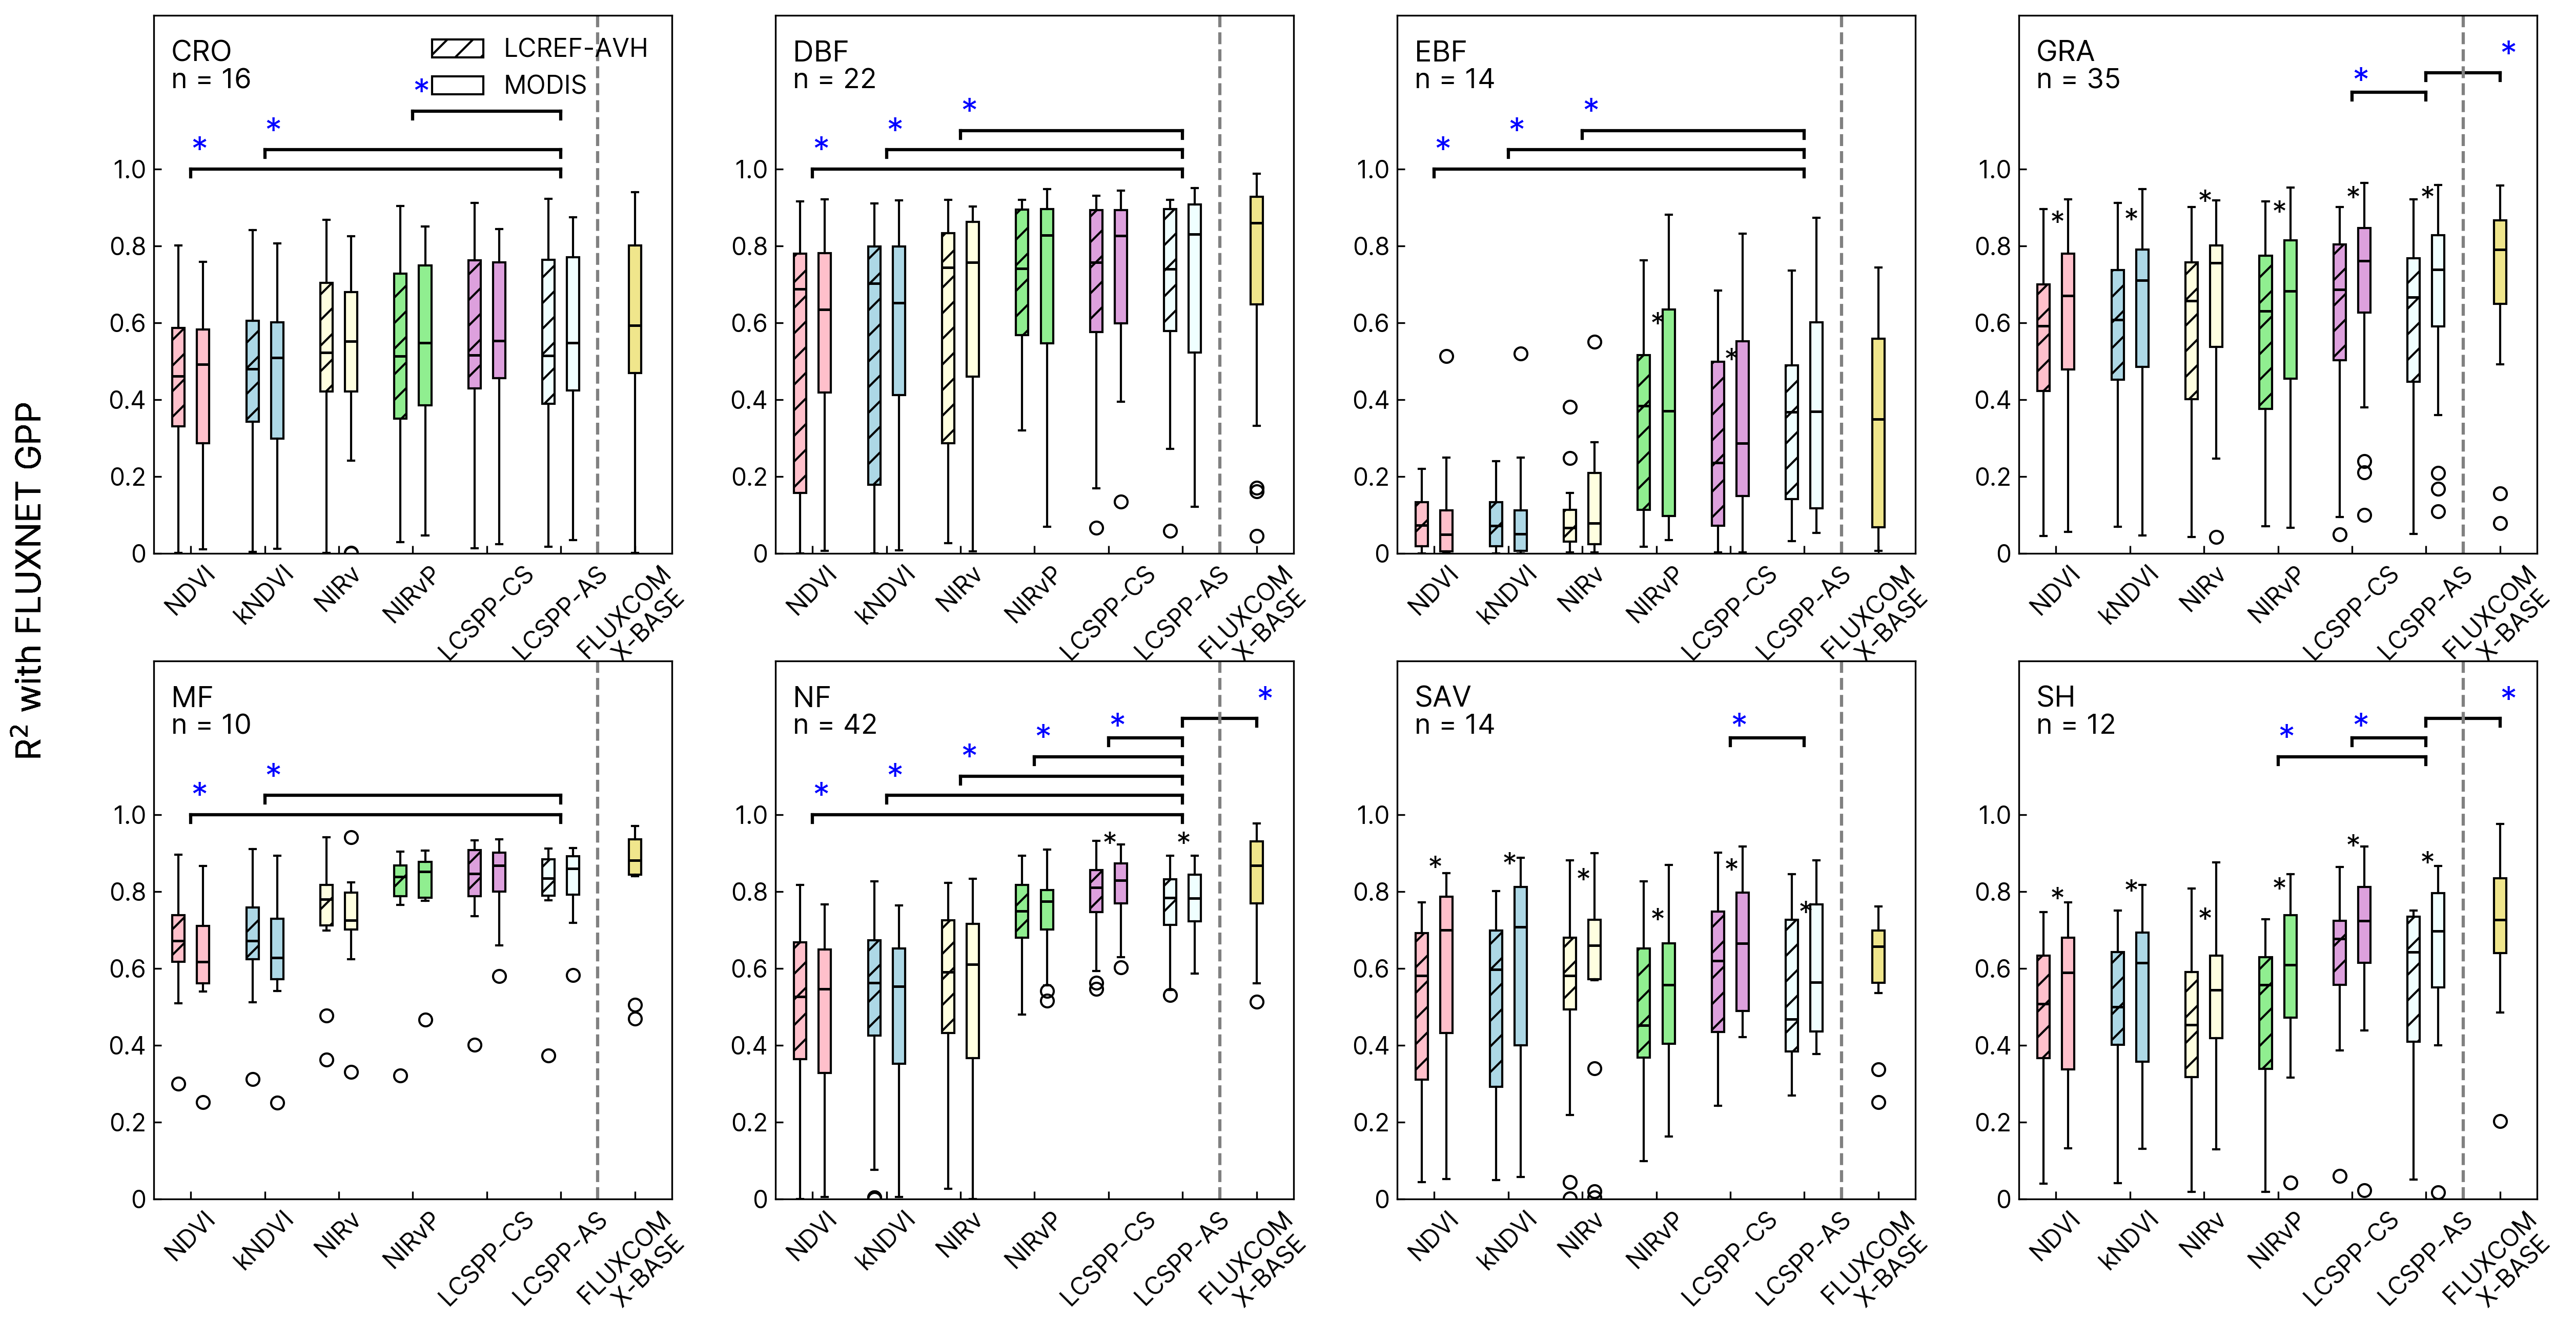

In [48]:
def plot_bar(axis, x1, x2, y_loc):
    axis.plot([x1,x2], [y_loc, y_loc], c="k")
    axis.plot([x1,x1], [y_loc, y_loc-0.02], c="k")
    axis.plot([x2,x2], [y_loc, y_loc-0.02], c="k")
        

from matplotlib.patches import Patch
fig, axs = plt.subplots(2,4, figsize=(20,10), dpi=300)
ax = axs.flatten()
IGBP_types = np.unique(combined_all_df["IGBP"])
for i in range(len(IGBP_types)):
    p = [1,2,4,5,7,8,10,11,13,14,16,17,19.5,30]
    data=np.vstack([[combined_all_df[(combined_all_df["IGBP"]==IGBP_types[i]) 
                             & (combined_all_df["type"]==t)]["R^2"] for t in ["LCREF_NDVI", "LCREF_KNDVI_TEMPORAL", "LCREF_NIRV", "LCREF_NIRVP", "LCSPP", "LCSPP_ALL", "FLUXCOM_XBASE"]]]).T
    data_rearrange = np.zeros((data.shape[0] // 2, data.shape[1]*2))
    data_rearrange[:, np.arange(data.shape[1]) * 2] = data[:(data.shape[0]// 2), :]
    data_rearrange[:, np.arange(data.shape[1]) * 2 + 1] = data[(data.shape[0]// 2):, :]

    bplot = ax[i].boxplot(data_rearrange, positions=p, patch_artist=True)
    ax[i].set_xlim(0, 21)
    colors = ['pink','pink', 'lightblue','lightblue', 'lightyellow', 'lightyellow',
              'lightgreen',  'lightgreen', 'plum', 'plum', 'azure', 'azure',
              'khaki','khaki']
    hatchs = ['//', '', '//', '','//', '','//', '','//', '','//', '', '', '',]
    xticks_location = [1.5, 4.5, 7.5, 10.5, 13.5, 16.5, 19.5]
    ax[i].set_xticks(xticks_location, labels=["NDVI", "kNDVI", "NIRv", "NIRvP", "LCSPP-CS", "LCSPP-AS", "FLUXCOM\n  X-BASE"], fontsize=13.5, rotation=45)
    ax[i].tick_params(axis='both', which='major', labelsize=11.5)

    ax[i].text(0.7, 0.93+0.35, IGBP_types[i], fontsize=13.5)
    ax[i].text(0.7, 0.86+0.35, "n = " + str(len(np.unique(combined_all_df[combined_all_df["IGBP"]==IGBP_types[i]]["SITE_ID"]))), fontsize=13)
    ax[i].set_ylim(0, 1.4)
    ax[i].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0], ["0", "0.2", "0.4", "0.6", "0.8", "1.0"])
    
    alpha = 0.05
    if t_test_lcspp_all_vs_vi_all_df[(t_test_lcspp_all_vs_vi_all_df["IGBP"]==IGBP_types[i]) & (t_test_lcspp_all_vs_vi_all_df["LCSPP_all vs."]=="LCREF_NDVI")]["p"].values.item() < alpha:
        plot_bar(ax[i], xticks_location[0], xticks_location[5], 1.0)
        ax[i].text(xticks_location[0], 1.02, "*", c="blue", fontsize=16)
    if t_test_lcspp_all_vs_vi_all_df[(t_test_lcspp_all_vs_vi_all_df["IGBP"]==IGBP_types[i]) & (t_test_lcspp_all_vs_vi_all_df["LCSPP_all vs."]=="LCREF_KNDVI_TEMPORAL")]["p"].values.item() < alpha:
        plot_bar(ax[i], xticks_location[1], xticks_location[5], 1.05)
        ax[i].text(xticks_location[1], 1.05+0.02, "*", c="blue", fontsize=16)
    if t_test_lcspp_all_vs_vi_all_df[(t_test_lcspp_all_vs_vi_all_df["IGBP"]==IGBP_types[i]) & (t_test_lcspp_all_vs_vi_all_df["LCSPP_all vs."]=="LCREF_NIRV")]["p"].values.item() < alpha:
        plot_bar(ax[i], xticks_location[2], xticks_location[5], 1.1)
        ax[i].text(xticks_location[2], 1.1+0.02, "*", c="blue", fontsize=16)
    if t_test_lcspp_all_vs_vi_all_df[(t_test_lcspp_all_vs_vi_all_df["IGBP"]==IGBP_types[i]) & (t_test_lcspp_all_vs_vi_all_df["LCSPP_all vs."]=="LCREF_NIRVP")]["p"].values.item() < alpha:
        plot_bar(ax[i], xticks_location[3], xticks_location[5], 1.15)
        ax[i].text(xticks_location[3], 1.15+0.02, "*", c="blue", fontsize=16)
        
    if t_test_lcspp_all_vs_vi_all_df[(t_test_lcspp_all_vs_vi_all_df["IGBP"]==IGBP_types[i]) & (t_test_lcspp_all_vs_vi_all_df["LCSPP_all vs."]=="LCSPP_clear")]["p"].values.item() < alpha:
        plot_bar(ax[i], xticks_location[4], xticks_location[5], 1.2)
        ax[i].text(xticks_location[4], 1.2, "*", c="blue", fontsize=16)
    if t_test_lcspp_all_vs_vi_all_df[(t_test_lcspp_all_vs_vi_all_df["IGBP"]==IGBP_types[i]) & (t_test_lcspp_all_vs_vi_all_df["LCSPP_all vs."]=="FLUXCOM_XBASE")]["p"].values.item() < alpha:
        plot_bar(ax[i], xticks_location[6], xticks_location[5], 1.25)
        ax[i].text(xticks_location[6], 1.25+0.02, "*", c="blue", fontsize=16)
    
    dd_types = ["LCREF_NDVI", "LCREF_KNDVI_TEMPORAL", "LCREF_NIRV", "LCREF_NIRVP", "LCSPP", "LCSPP_ALL", "FLUXCOM_XBASE"]
    for j in range(7):
        if avhrr_modis_t_test_all_df[(avhrr_modis_t_test_all_df["IGBP"]==IGBP_types[i]) & (avhrr_modis_t_test_all_df["variable"]==dd_types[j])]["p"].item() < alpha:
            yloc = np.median(combined_all_df[(combined_all_df["IGBP"]==IGBP_types[i]) * (combined_all_df["type"]==dd_types[j])]["R^2"])
            ax[i].text(xticks_location[j]-0.25, min(yloc + 0.2, 0.9), "*", color="k", fontsize=14)
    
    fig.text(0.08,0.4, "R$^2$ with FLUXNET GPP", rotation=90, fontsize=16)
    
    for median in bplot['medians']:
        median.set(color ='black',
                   linewidth = 1.2)
    
    for patch, color, hatch in zip(bplot['boxes'], colors, hatchs):
        patch.set_facecolor(color)
        patch.set_hatch(hatch)
        
    if i == 0:
        legend_elements = [Patch(facecolor='white', edgecolor='black', hatch="//",
                             label='LCREF-AVH'),
                       Patch(facecolor='white', edgecolor='black', hatch=None,
                             label='MODIS')]
        ax[i].legend(handles=legend_elements, loc='upper right', ncol=1, frameon=False)
        
    ax[i].plot([18,18], [0,2], "--", c="grey")
#plt.savefig("./figs/FLUXNET_MODIS_PERIOD_ALL_nirvp_all_compared_with_all_sky.png", dpi=300)

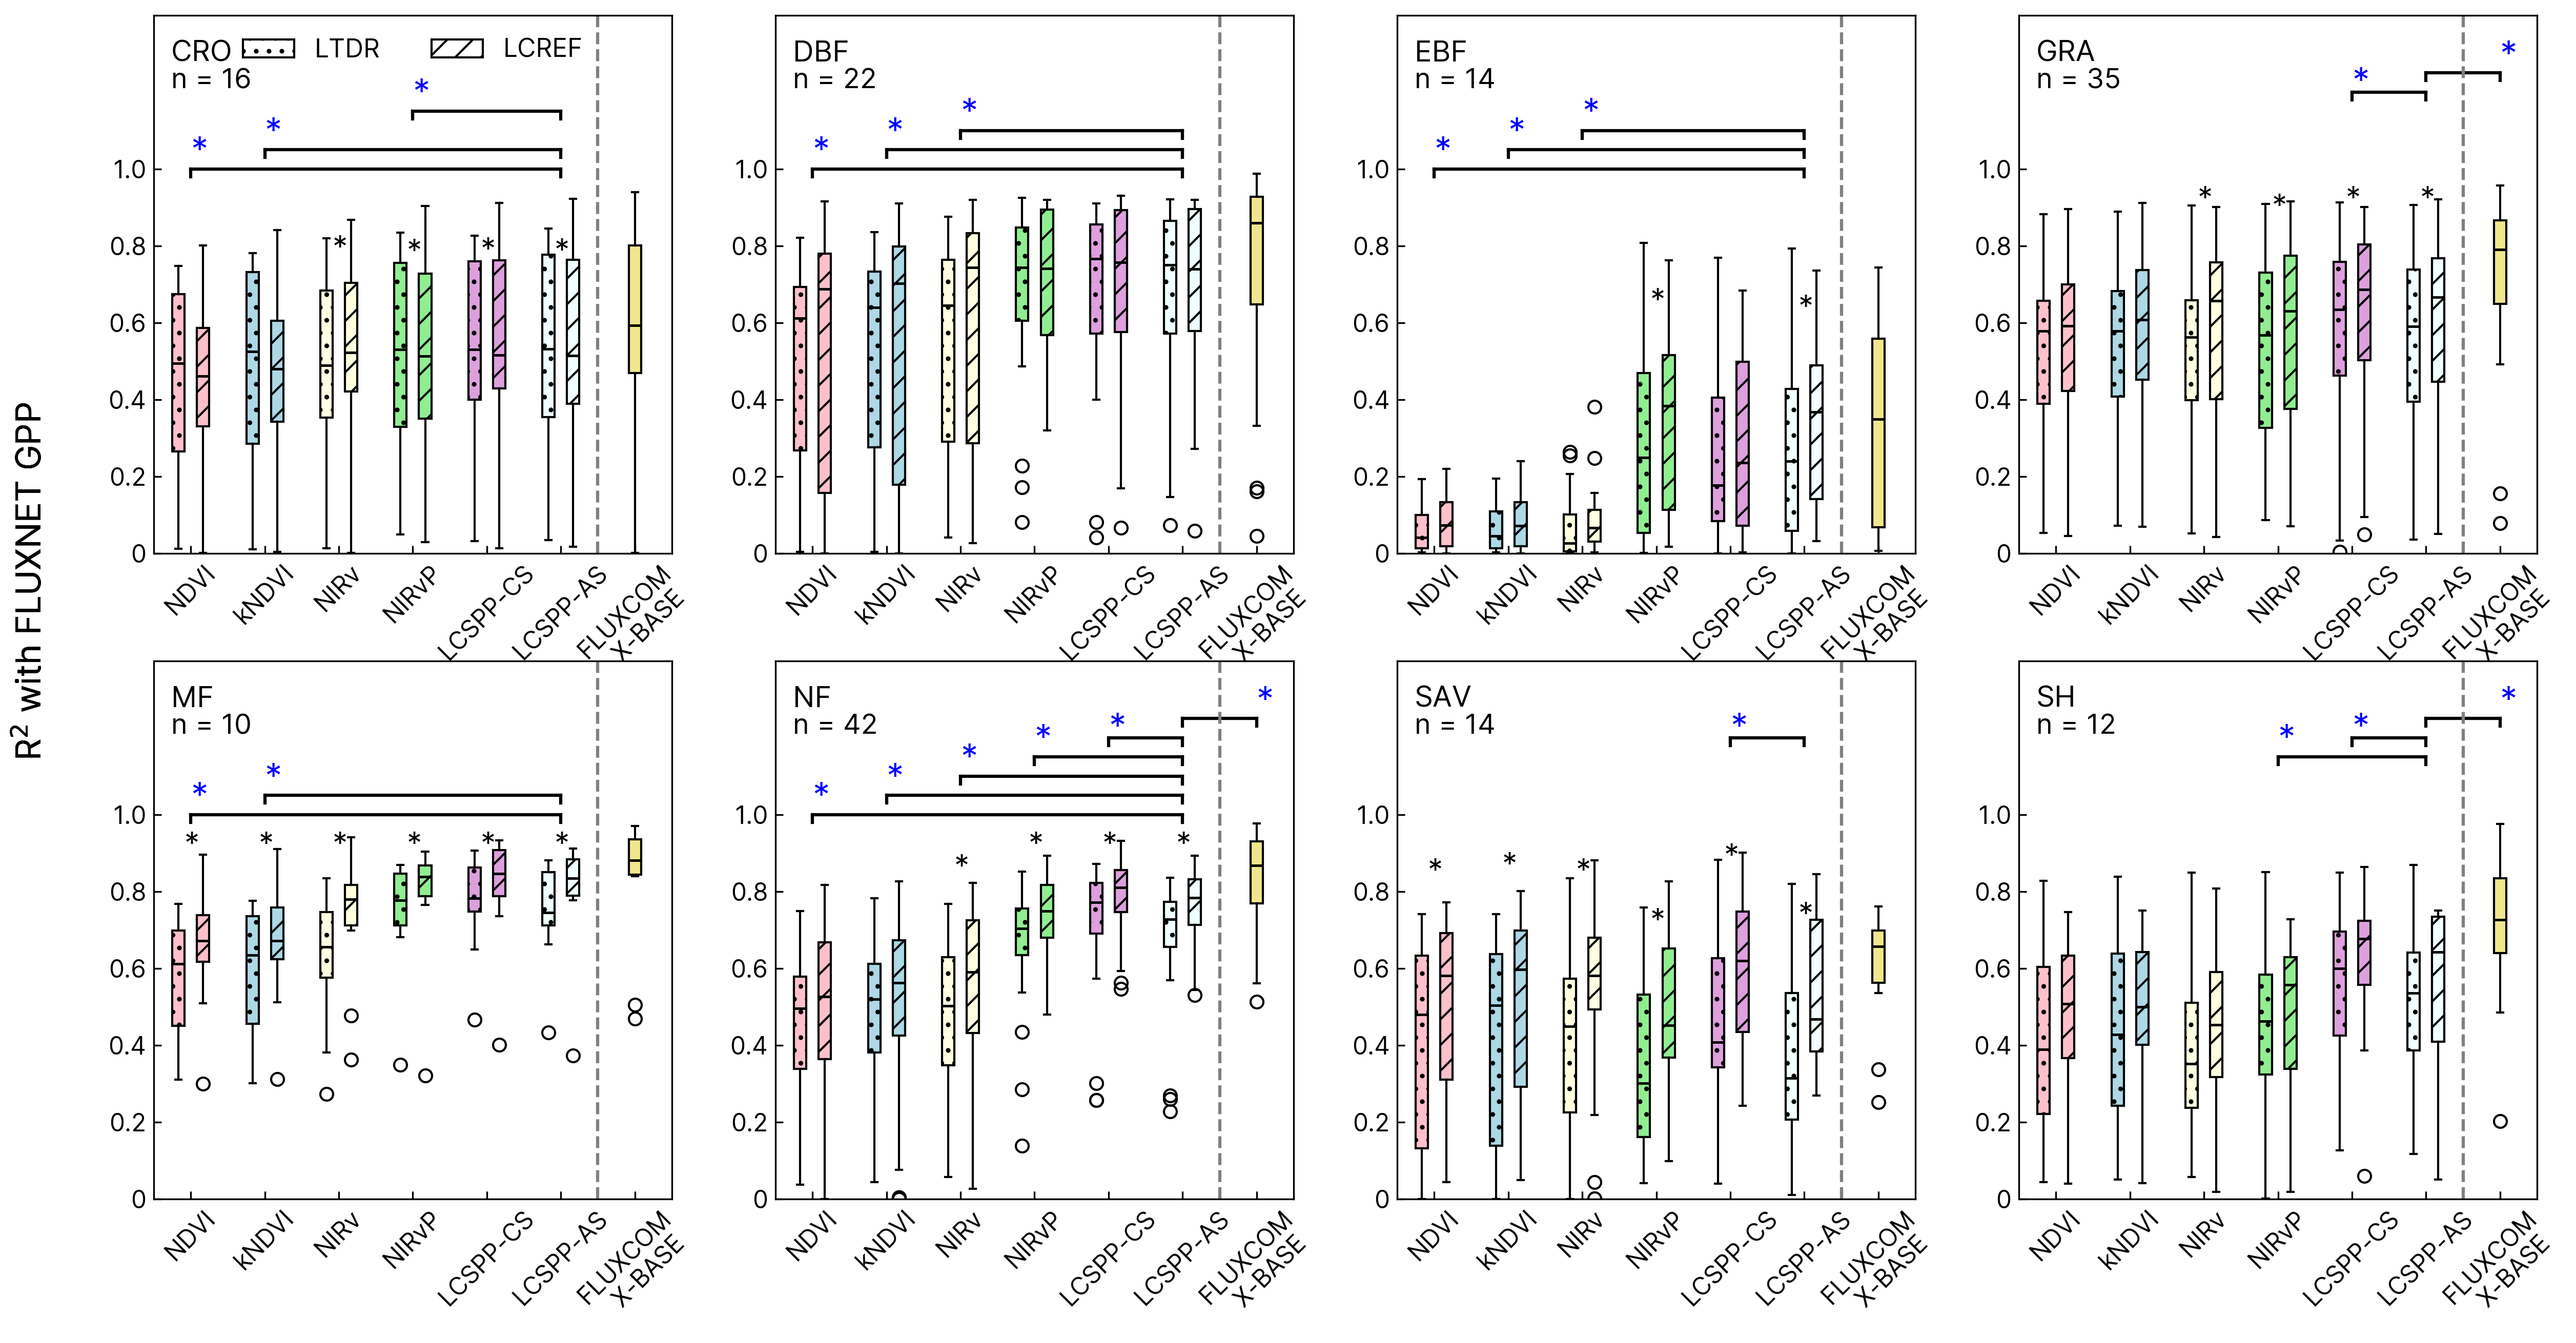

In [49]:
def plot_bar(axis, x1, x2, y_loc):
    axis.plot([x1,x2], [y_loc, y_loc], c="k")
    axis.plot([x1,x1], [y_loc, y_loc-0.02], c="k")
    axis.plot([x2,x2], [y_loc, y_loc-0.02], c="k")
        

from matplotlib.patches import Patch
fig, axs = plt.subplots(2,4, figsize=(20,10), dpi=300)
ax = axs.flatten()
IGBP_types = np.unique(avhrr_ltdr_all_df["IGBP"])
for i in range(len(IGBP_types)):
    p = [1,2,4,5,7,8,10,11,13,14,16,17,19.5,30]
    data=np.vstack([[avhrr_ltdr_all_df[(avhrr_ltdr_all_df["IGBP"]==IGBP_types[i]) 
                             & (avhrr_ltdr_all_df["type"]==t)]["R^2"] for t in ["LCREF_NDVI", "LCREF_KNDVI_TEMPORAL", "LCREF_NIRV", "LCREF_NIRVP", "LCSPP", "LCSPP_ALL", "FLUXCOM_XBASE"]]]).T
    data_rearrange = np.zeros((data.shape[0] // 2, data.shape[1]*2))
    data_rearrange[:, np.arange(data.shape[1]) * 2] = data[:(data.shape[0]// 2), :]
    data_rearrange[:, np.arange(data.shape[1]) * 2 + 1] = data[(data.shape[0]// 2):, :]

    bplot = ax[i].boxplot(data_rearrange, positions=p, patch_artist=True)
    ax[i].set_xlim(0, 21)
    colors = ['pink','pink', 'lightblue','lightblue', 'lightyellow', 'lightyellow',
              'lightgreen',  'lightgreen', 'plum', 'plum', 'azure', 'azure',
              'khaki','khaki']
    hatchs = ['..', '//', '..', '//','..', '//','..', '//','..', '//','..', '//', '', '',]
    xticks_location = [1.5, 4.5, 7.5, 10.5, 13.5, 16.5, 19.5]
    ax[i].set_xticks(xticks_location, labels=["NDVI", "kNDVI", "NIRv", "NIRvP", "LCSPP-CS", "LCSPP-AS", "FLUXCOM\n  X-BASE"], fontsize=13.5, rotation=45)
    ax[i].tick_params(axis='both', which='major', labelsize=11.5)

    ax[i].text(0.7, 0.93+0.35, IGBP_types[i], fontsize=13.5)
    ax[i].text(0.7, 0.86+0.35, "n = " + str(len(np.unique(avhrr_ltdr_all_df[avhrr_ltdr_all_df["IGBP"]==IGBP_types[i]]["SITE_ID"]))), fontsize=13)
    ax[i].set_ylim(0, 1.4)
    ax[i].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0], ["0", "0.2", "0.4", "0.6", "0.8", "1.0"])
    
    alpha = 0.05
    if t_test_lcspp_all_vs_vi_all_df[(t_test_lcspp_all_vs_vi_all_df["IGBP"]==IGBP_types[i]) & (t_test_lcspp_all_vs_vi_all_df["LCSPP_all vs."]=="LCREF_NDVI")]["p"].values.item() < alpha:
        plot_bar(ax[i], xticks_location[0], xticks_location[5], 1.0)
        ax[i].text(xticks_location[0], 1.02, "*", c="blue", fontsize=16)
    if t_test_lcspp_all_vs_vi_all_df[(t_test_lcspp_all_vs_vi_all_df["IGBP"]==IGBP_types[i]) & (t_test_lcspp_all_vs_vi_all_df["LCSPP_all vs."]=="LCREF_KNDVI_TEMPORAL")]["p"].values.item() < alpha:
        plot_bar(ax[i], xticks_location[1], xticks_location[5], 1.05)
        ax[i].text(xticks_location[1], 1.05+0.02, "*", c="blue", fontsize=16)
    if t_test_lcspp_all_vs_vi_all_df[(t_test_lcspp_all_vs_vi_all_df["IGBP"]==IGBP_types[i]) & (t_test_lcspp_all_vs_vi_all_df["LCSPP_all vs."]=="LCREF_NIRV")]["p"].values.item() < alpha:
        plot_bar(ax[i], xticks_location[2], xticks_location[5], 1.1)
        ax[i].text(xticks_location[2], 1.1+0.02, "*", c="blue", fontsize=16)
    if t_test_lcspp_all_vs_vi_all_df[(t_test_lcspp_all_vs_vi_all_df["IGBP"]==IGBP_types[i]) & (t_test_lcspp_all_vs_vi_all_df["LCSPP_all vs."]=="LCREF_NIRVP")]["p"].values.item() < alpha:
        plot_bar(ax[i], xticks_location[3], xticks_location[5], 1.15)
        ax[i].text(xticks_location[3], 1.15+0.02, "*", c="blue", fontsize=16)
        
    if t_test_lcspp_all_vs_vi_all_df[(t_test_lcspp_all_vs_vi_all_df["IGBP"]==IGBP_types[i]) & (t_test_lcspp_all_vs_vi_all_df["LCSPP_all vs."]=="LCSPP_clear")]["p"].values.item() < alpha:
        plot_bar(ax[i], xticks_location[4], xticks_location[5], 1.2)
        ax[i].text(xticks_location[4], 1.2, "*", c="blue", fontsize=16)
    if t_test_lcspp_all_vs_vi_all_df[(t_test_lcspp_all_vs_vi_all_df["IGBP"]==IGBP_types[i]) & (t_test_lcspp_all_vs_vi_all_df["LCSPP_all vs."]=="FLUXCOM_XBASE")]["p"].values.item() < alpha:
        plot_bar(ax[i], xticks_location[6], xticks_location[5], 1.25)
        ax[i].text(xticks_location[6], 1.25+0.02, "*", c="blue", fontsize=16)
    
    dd_types = ["LCREF_NDVI", "LCREF_KNDVI_TEMPORAL", "LCREF_NIRV", "LCREF_NIRVP", "LCSPP", "LCSPP_ALL", "FLUXCOM_XBASE"]
    for j in range(7):
        if avhrr_ltdr_t_test_all_df[(avhrr_ltdr_t_test_all_df["IGBP"]==IGBP_types[i]) & (avhrr_ltdr_t_test_all_df["variable"]==dd_types[j])]["p"].item() < alpha:
            yloc = np.median(avhrr_ltdr_all_df[(avhrr_ltdr_all_df["IGBP"]==IGBP_types[i]) * (avhrr_ltdr_all_df["type"]==dd_types[j]) * (avhrr_ltdr_all_df["sensor"]=="AVHRR")]["R^2"])
            ax[i].text(xticks_location[j]-0.25, min(yloc + 0.25, 0.9), "*", color="k", fontsize=14)

    fig.text(0.08,0.4, "R$^2$ with FLUXNET GPP", rotation=90, fontsize=16)
    
    for median in bplot['medians']:
        median.set(color ='black',
                   linewidth = 1.2)
    
    for patch, color, hatch in zip(bplot['boxes'], colors, hatchs):
        patch.set_facecolor(color)
        patch.set_hatch(hatch)
        
    ax[i].plot([18,18], [0,2], "--", c="grey")
    
    if i == 0:
        legend_elements = [Patch(facecolor='white', edgecolor='black', hatch="..",
                             label='LTDR'),
                       Patch(facecolor='white', edgecolor='black', hatch="//",
                             label='LCREF')]
        ax[i].legend(handles=legend_elements, loc='upper center', ncol=2, frameon=False)
#plt.savefig("./figs/FLUXNET_MODIS_PERIOD_ALL_nirvp_all_compared_with_all_sky.png", dpi=300)

In [50]:
t_test_lcspp_all_vs_vi_all_df

,IGBP,LCSPP_all vs.,df,t,p
0,CRO,LCREF_NDVI,15,-3.179197,3.111643e-03
1,CRO,LCREF_KNDVI_TEMPORAL,15,-2.613511,9.782677e-03
2,CRO,LCREF_NIRV,15,-0.902594,1.905037e-01
3,CRO,LCREF_NIRVP,15,-2.249412,3.993305e-02
4,CRO,LCSPP_clear,15,-0.597576,5.590368e-01
5,CRO,FLUXCOM_XBASE,15,1.645249,1.207060e-01
6,CRO,FLUXCOM,15,NaN,NaN
7,DBF,LCREF_NDVI,21,-4.497920,9.879918e-05
8,DBF,LCREF_KNDVI_TEMPORAL,21,-4.237968,1.839016e-04
9,DBF,LCREF_NIRV,21,-3.473374,1.135228e-03


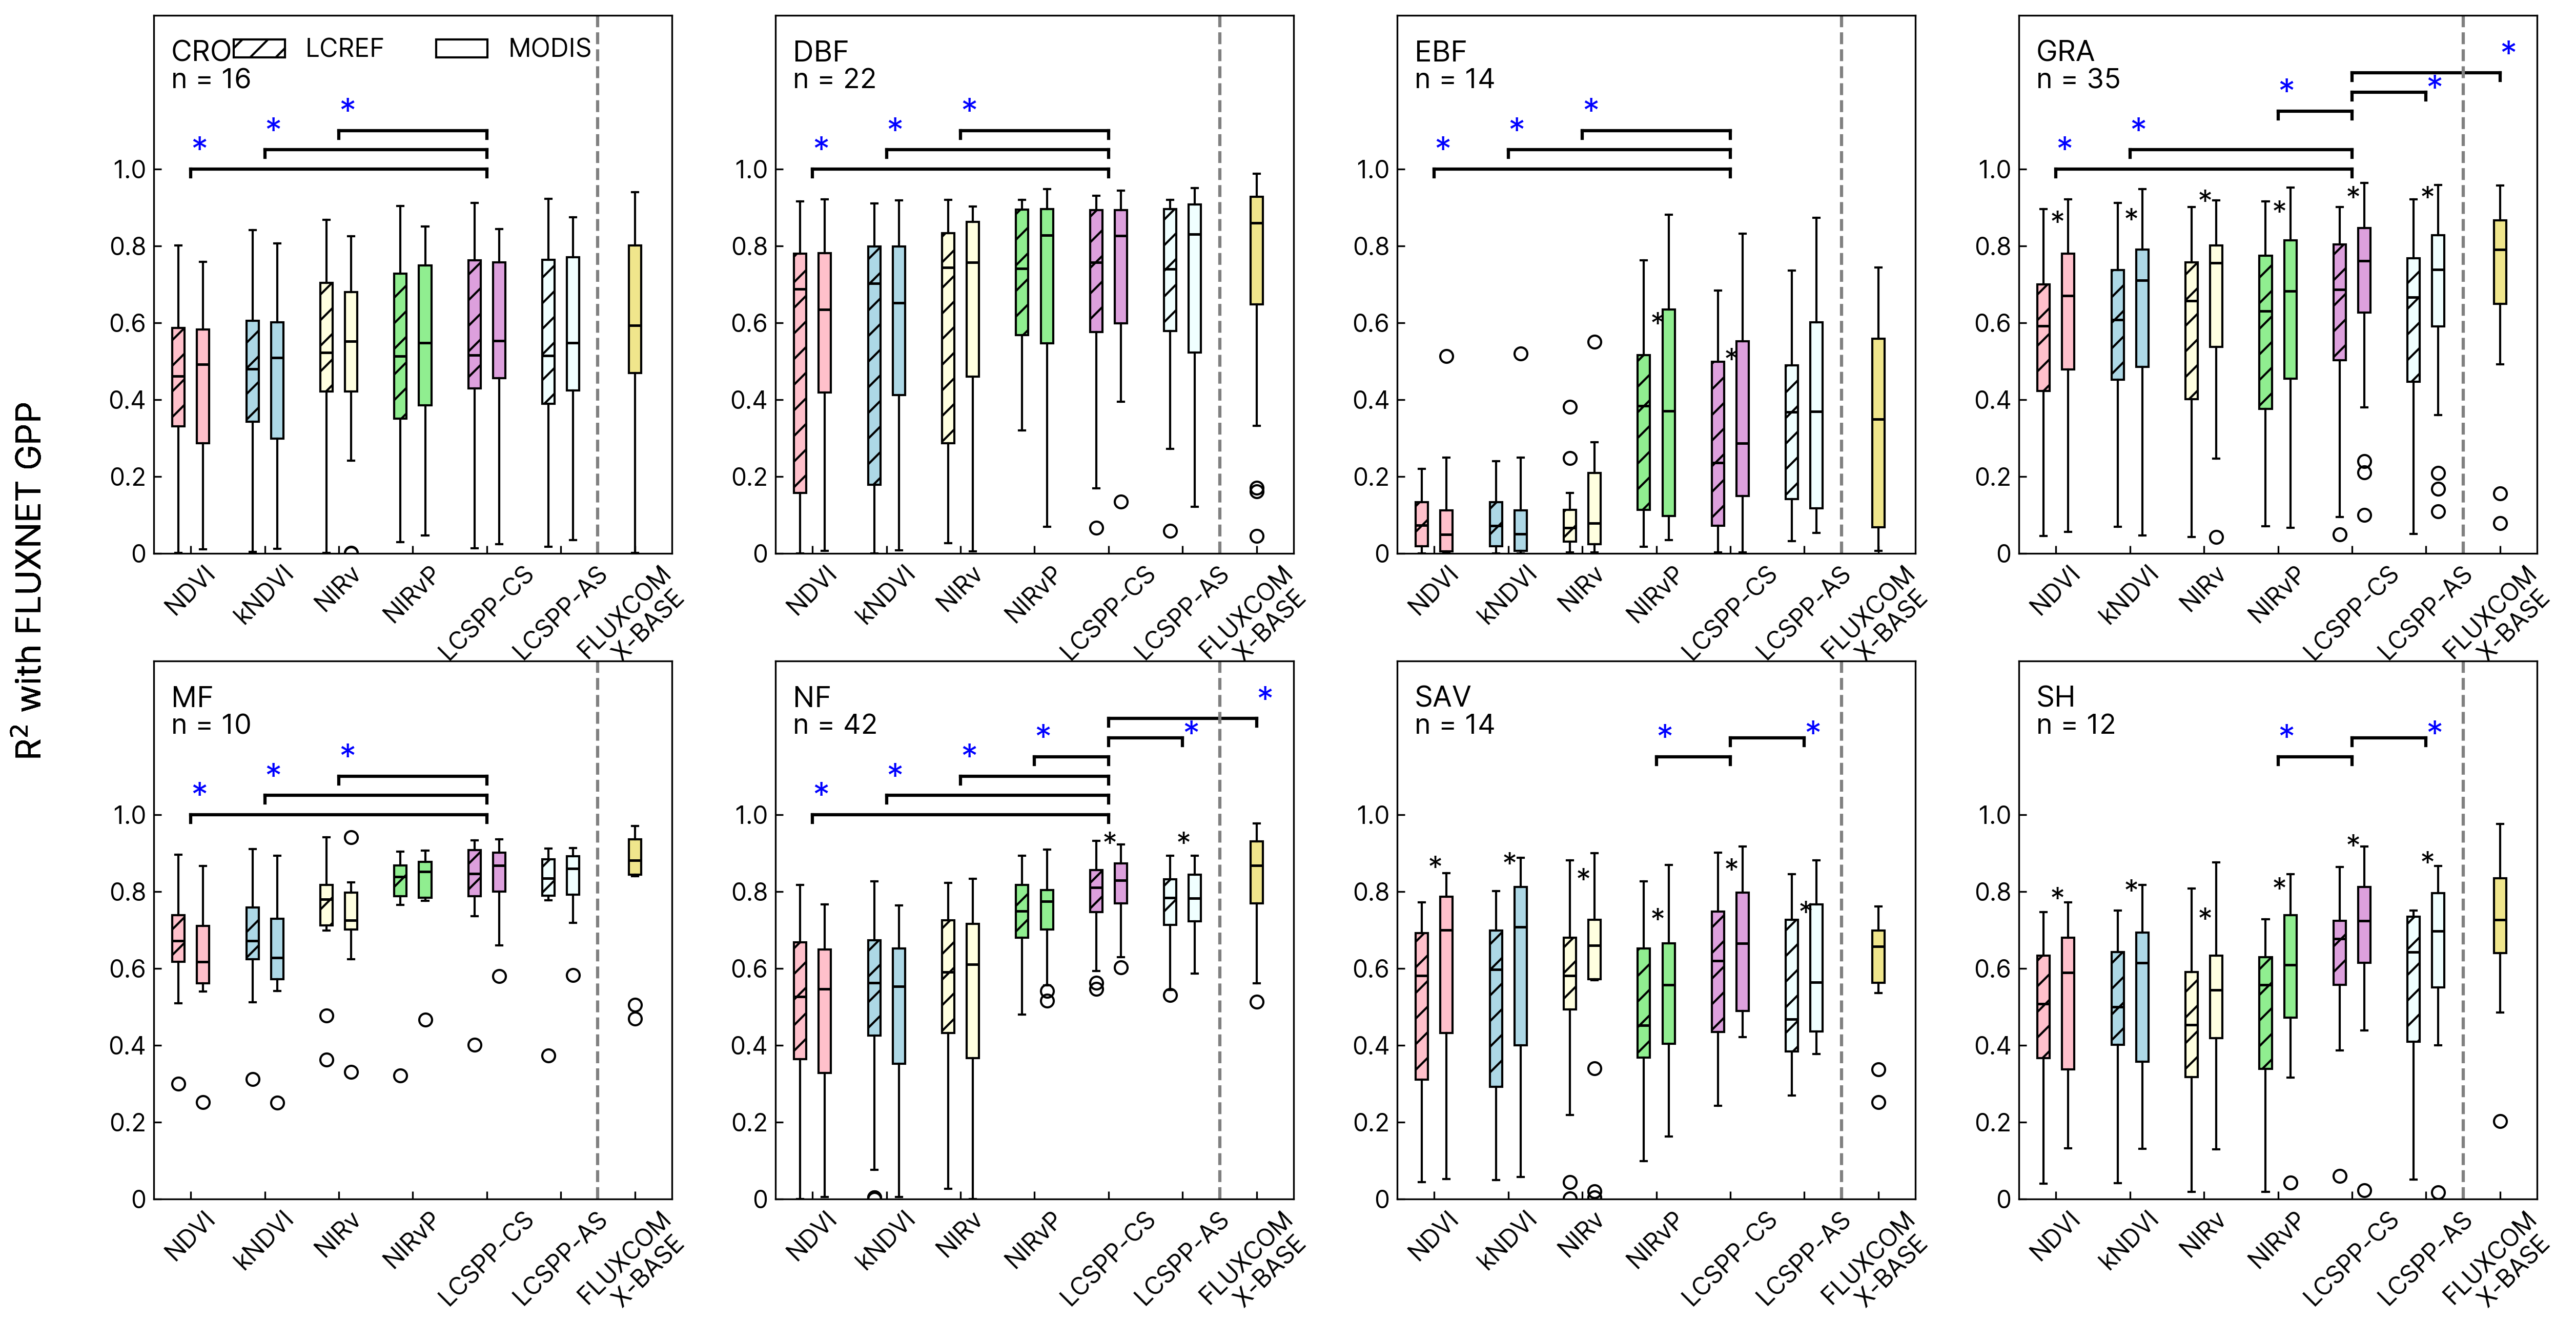

In [51]:
def plot_bar(axis, x1, x2, y_loc):
    axis.plot([x1,x2], [y_loc, y_loc], c="k")
    axis.plot([x1,x1], [y_loc, y_loc-0.02], c="k")
    axis.plot([x2,x2], [y_loc, y_loc-0.02], c="k")
        

from matplotlib.patches import Patch
fig, axs = plt.subplots(2,4, figsize=(20,10), dpi=300)
ax = axs.flatten()
IGBP_types = np.unique(combined_all_df["IGBP"])
for i in range(len(IGBP_types)):
    p = [1,2,4,5,7,8,10,11,13,14,16,17,19.5,30]
    data=np.vstack([[combined_all_df[(combined_all_df["IGBP"]==IGBP_types[i]) 
                             & (combined_all_df["type"]==t)]["R^2"] for t in ["LCREF_NDVI", "LCREF_KNDVI_TEMPORAL", "LCREF_NIRV", "LCREF_NIRVP", "LCSPP", "LCSPP_ALL", "FLUXCOM_XBASE"]]]).T
    data_rearrange = np.zeros((data.shape[0] // 2, data.shape[1]*2))
    data_rearrange[:, np.arange(data.shape[1]) * 2] = data[:(data.shape[0]// 2), :]
    data_rearrange[:, np.arange(data.shape[1]) * 2 + 1] = data[(data.shape[0]// 2):, :]

    bplot = ax[i].boxplot(data_rearrange, positions=p, patch_artist=True)
    ax[i].set_xlim(0, 21)
    colors = ['pink','pink', 'lightblue','lightblue', 'lightyellow', 'lightyellow',
              'lightgreen',  'lightgreen', 'plum', 'plum', 'azure', 'azure',
              'khaki','khaki']
    hatchs = ['//', '', '//', '','//', '','//', '','//', '','//', '', '', '',]
    xticks_location = [1.5, 4.5, 7.5,10.5, 13.5, 16.5, 19.5]
    ax[i].set_xticks(xticks_location, labels=["NDVI", "kNDVI", "NIRv", "NIRvP", "LCSPP-CS", "LCSPP-AS", "FLUXCOM\n  X-BASE"], fontsize=13.5, rotation=45)
    ax[i].tick_params(axis='both', which='major', labelsize=11.5)

    ax[i].text(0.7, 0.93+0.35, IGBP_types[i], fontsize=13.5)
    ax[i].text(0.7, 0.86+0.35, "n = " + str(len(np.unique(combined_all_df[combined_all_df["IGBP"]==IGBP_types[i]]["SITE_ID"]))), fontsize=13)
    ax[i].set_ylim(0, 1.4)
    ax[i].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0], ["0", "0.2", "0.4", "0.6", "0.8", "1.0"])
    
    alpha = 0.05
    if modis_t_test_lcspp_clear_vs_vi_all_df[(modis_t_test_lcspp_clear_vs_vi_all_df["IGBP"]==IGBP_types[i]) & (modis_t_test_lcspp_clear_vs_vi_all_df["LCSPP_clear vs."]=="LCREF_NDVI")]["p"].values.item() < alpha:
        plot_bar(ax[i], xticks_location[0], xticks_location[4], 1.0)
        ax[i].text(xticks_location[0], 1.02, "*", c="blue", fontsize=16)
    if modis_t_test_lcspp_clear_vs_vi_all_df[(modis_t_test_lcspp_clear_vs_vi_all_df["IGBP"]==IGBP_types[i]) & (modis_t_test_lcspp_clear_vs_vi_all_df["LCSPP_clear vs."]=="LCREF_KNDVI_TEMPORAL")]["p"].values.item() < alpha:
        plot_bar(ax[i], xticks_location[1], xticks_location[4], 1.05)
        ax[i].text(xticks_location[1], 1.05+0.02, "*", c="blue", fontsize=16)
    if modis_t_test_lcspp_clear_vs_vi_all_df[(modis_t_test_lcspp_clear_vs_vi_all_df["IGBP"]==IGBP_types[i]) & (modis_t_test_lcspp_clear_vs_vi_all_df["LCSPP_clear vs."]=="LCREF_NIRV")]["p"].values.item() < alpha:
        plot_bar(ax[i], xticks_location[2], xticks_location[4], 1.1)
        ax[i].text(xticks_location[2], 1.1+0.02, "*", c="blue", fontsize=16)
    if modis_t_test_lcspp_clear_vs_vi_all_df[(modis_t_test_lcspp_clear_vs_vi_all_df["IGBP"]==IGBP_types[i]) & (modis_t_test_lcspp_clear_vs_vi_all_df["LCSPP_clear vs."]=="LCREF_NIRVP")]["p"].values.item() < alpha:
        plot_bar(ax[i], xticks_location[3], xticks_location[4], 1.15)
        ax[i].text(xticks_location[3], 1.15+0.02, "*", c="blue", fontsize=16)
    if modis_t_test_lcspp_clear_vs_vi_all_df[(modis_t_test_lcspp_clear_vs_vi_all_df["IGBP"]==IGBP_types[i]) & (modis_t_test_lcspp_clear_vs_vi_all_df["LCSPP_clear vs."]=="LCSPP_ALL")]["p"].values.item() < alpha:
        plot_bar(ax[i], xticks_location[5], xticks_location[4], 1.2)
        ax[i].text(xticks_location[5], 1.18, "*", c="blue", fontsize=16)
    if modis_t_test_lcspp_clear_vs_vi_all_df[(modis_t_test_lcspp_clear_vs_vi_all_df["IGBP"]==IGBP_types[i]) & (modis_t_test_lcspp_clear_vs_vi_all_df["LCSPP_clear vs."]=="FLUXCOM_XBASE")]["p"].values.item() < alpha:
        plot_bar(ax[i], xticks_location[6], xticks_location[4], 1.25)
        ax[i].text(xticks_location[6], 1.25+0.02, "*", c="blue", fontsize=16)
        
    dd_types = ["LCREF_NDVI", "LCREF_KNDVI_TEMPORAL", "LCREF_NIRV", "LCREF_NIRVP", "LCSPP", "LCSPP_ALL", "FLUXCOM_XBASE"]
    for j in range(7):
        if avhrr_modis_t_test_all_df[(avhrr_modis_t_test_all_df["IGBP"]==IGBP_types[i]) & (avhrr_modis_t_test_all_df["variable"]==dd_types[j])]["p"].item() < alpha:
            yloc = np.median(combined_all_df[(combined_all_df["IGBP"]==IGBP_types[i]) * (combined_all_df["type"]==dd_types[j])]["R^2"])
            ax[i].text(xticks_location[j]-0.25, min(yloc + 0.2, 0.9), "*", color="k", fontsize=14)
            
    fig.text(0.08,0.4, "R$^2$ with FLUXNET GPP", rotation=90, fontsize=16)

    for median in bplot['medians']:
        median.set(color ='black',
                   linewidth = 1.2)
    
    for patch, color, hatch in zip(bplot['boxes'], colors, hatchs):
        patch.set_facecolor(color)
        patch.set_hatch(hatch)
        
    if i == 0:
        legend_elements = [Patch(facecolor='white', edgecolor='black', hatch="//",
                             label='LCREF'),
                       Patch(facecolor='white', edgecolor='black', hatch=None,
                             label='MODIS')]
        ax[i].legend(handles=legend_elements, loc='upper center', ncol=2, frameon=False)
        
        
    ax[i].plot([18,18], [0,2], "--", c="grey")
#plt.savefig("./figs/FLUXNET_MODIS_PERIOD_ALL_nirvp_all_compared_with_all_sky.png", dpi=300)

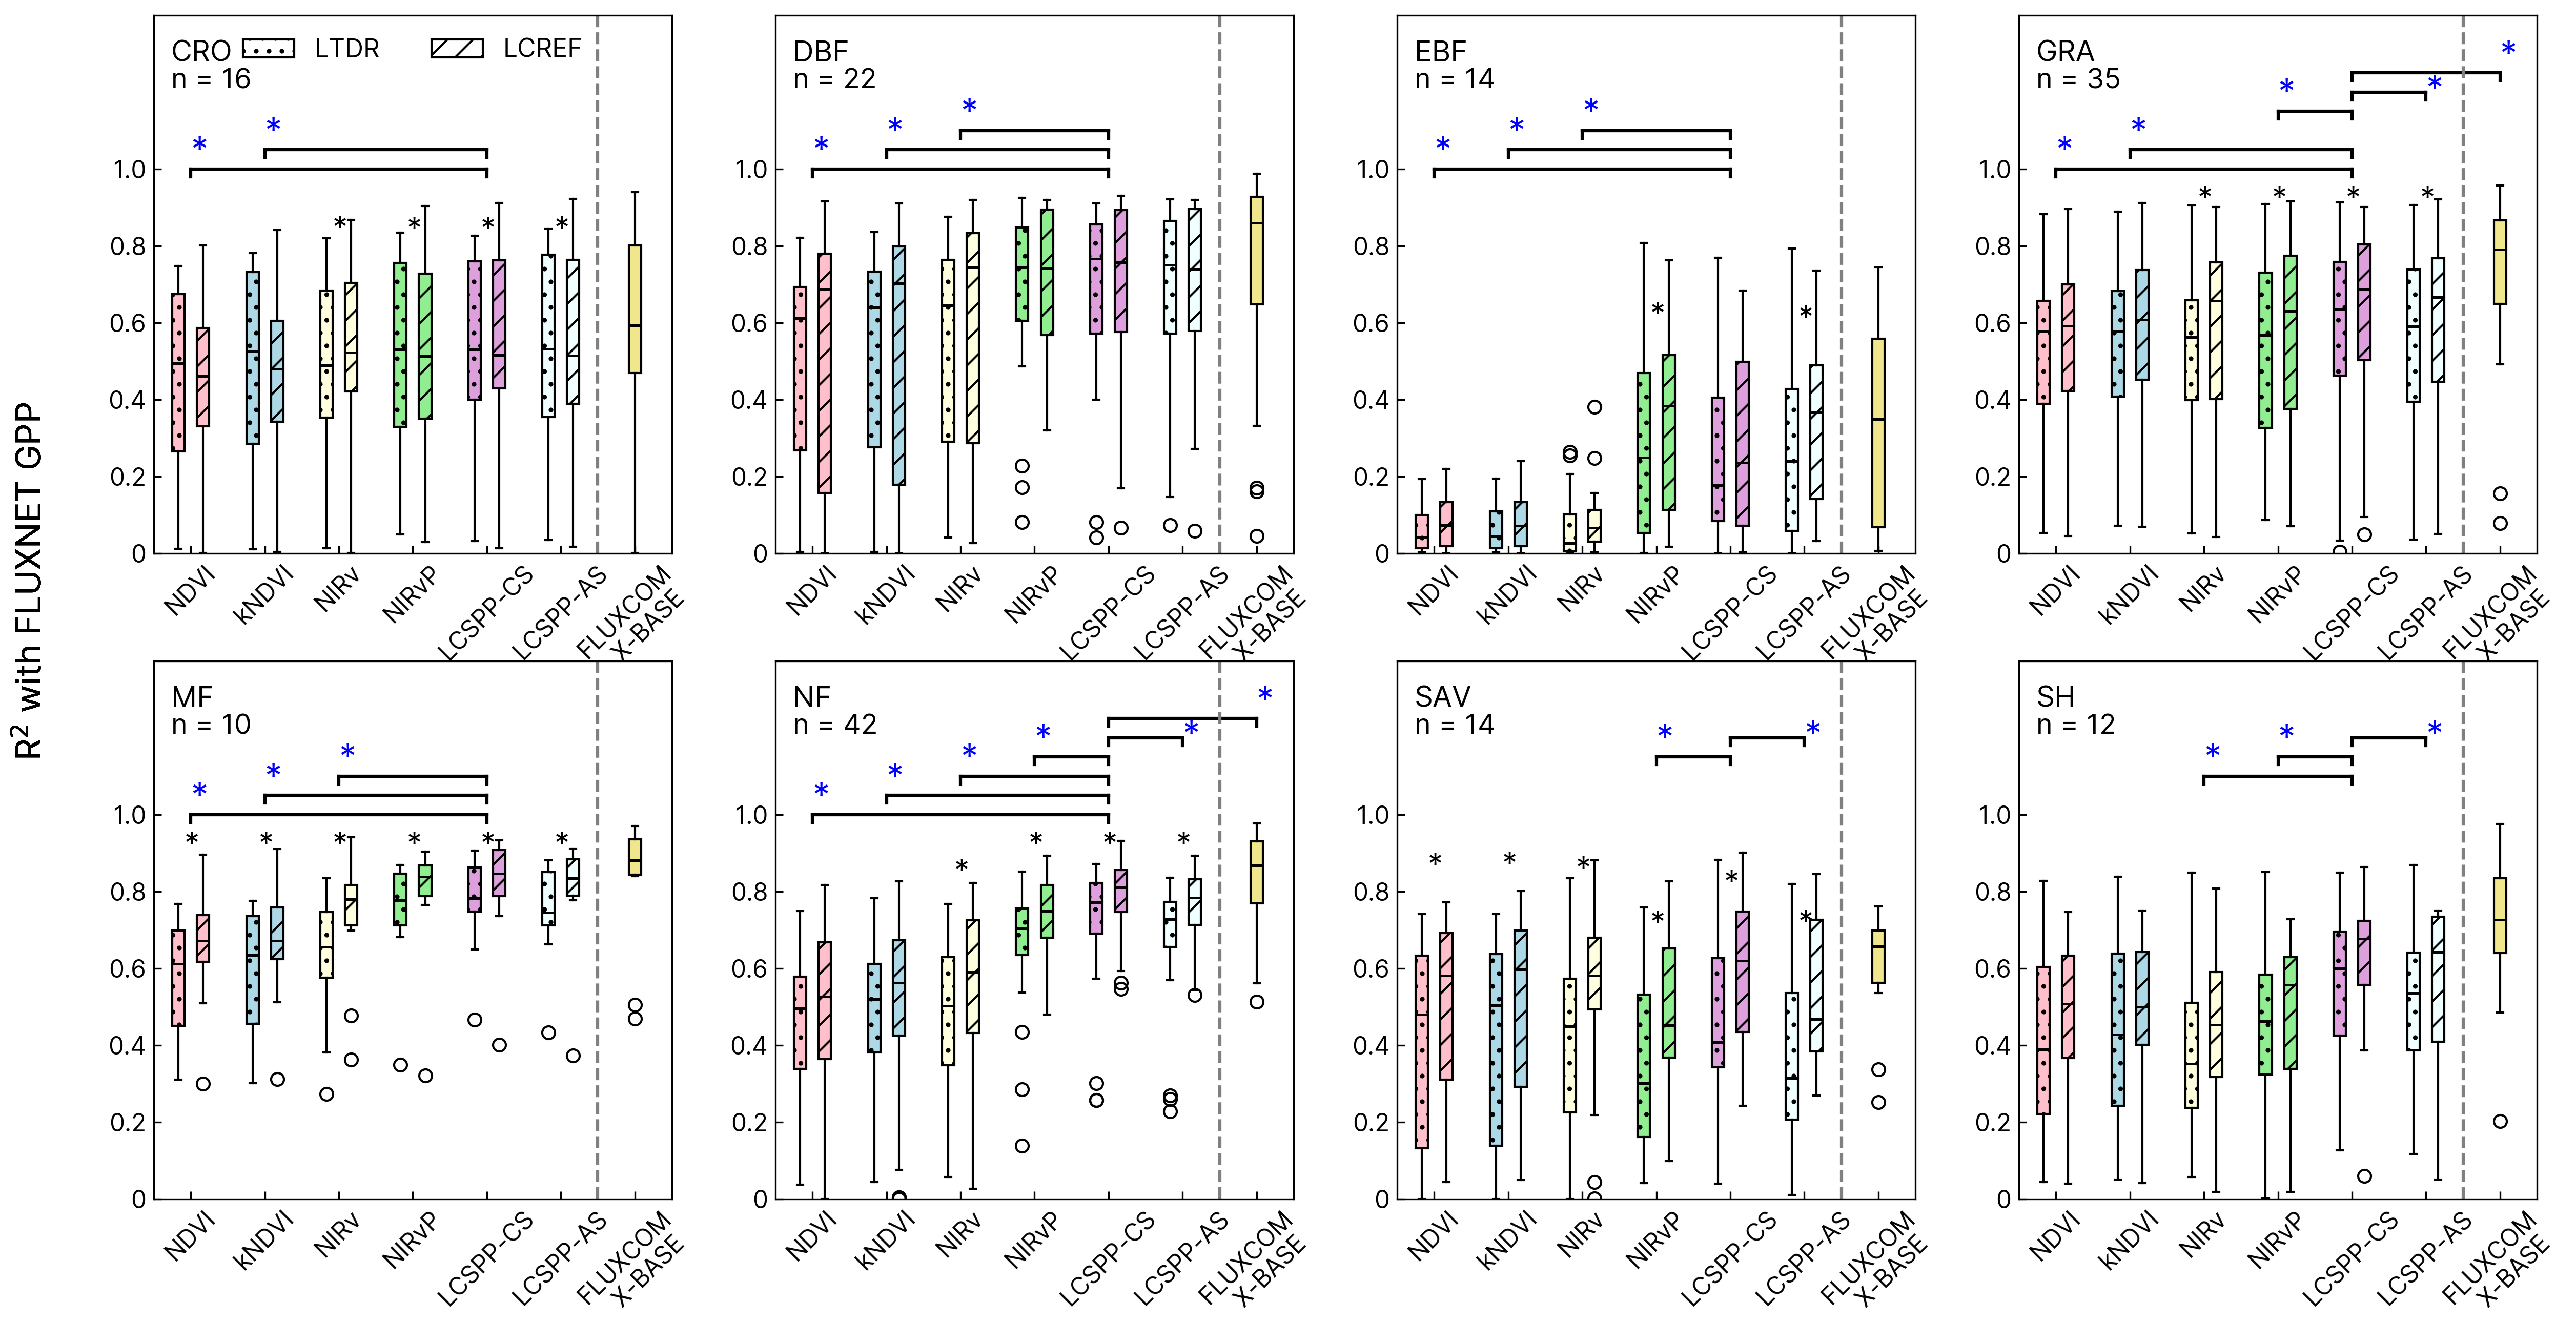

In [52]:
def plot_bar(axis, x1, x2, y_loc):
    axis.plot([x1,x2], [y_loc, y_loc], c="k")
    axis.plot([x1,x1], [y_loc, y_loc-0.02], c="k")
    axis.plot([x2,x2], [y_loc, y_loc-0.02], c="k")
        

from matplotlib.patches import Patch
fig, axs = plt.subplots(2,4, figsize=(20,10), dpi=300)
ax = axs.flatten()
IGBP_types = np.unique(avhrr_ltdr_all_df["IGBP"])
for i in range(len(IGBP_types)):
    p = [1,2,4,5,7,8,10,11,13,14,16,17,19.5,30]
    data=np.vstack([[avhrr_ltdr_all_df[(avhrr_ltdr_all_df["IGBP"]==IGBP_types[i]) 
                             & (avhrr_ltdr_all_df["type"]==t)]["R^2"] for t in ["LCREF_NDVI", "LCREF_KNDVI_TEMPORAL", "LCREF_NIRV", "LCREF_NIRVP", "LCSPP", "LCSPP_ALL", "FLUXCOM_XBASE"]]]).T
    data_rearrange = np.zeros((data.shape[0] // 2, data.shape[1]*2))
    data_rearrange[:, np.arange(data.shape[1]) * 2] = data[:(data.shape[0]// 2), :]
    data_rearrange[:, np.arange(data.shape[1]) * 2 + 1] = data[(data.shape[0]// 2):, :]

    bplot = ax[i].boxplot(data_rearrange, positions=p, patch_artist=True)
    ax[i].set_xlim(0, 21)
    colors = ['pink','pink', 'lightblue','lightblue', 'lightyellow', 'lightyellow',
              'lightgreen',  'lightgreen', 'plum', 'plum', 'azure', 'azure',
              'khaki','khaki']
    hatchs = ['..', '//', '..', '//','..', '//','..', '//','..', '//','..', '//', '', '',]
    xticks_location = [1.5, 4.5, 7.5,10.5, 13.5, 16.5, 19.5]
    ax[i].set_xticks(xticks_location, labels=["NDVI", "kNDVI", "NIRv", "NIRvP", "LCSPP-CS", "LCSPP-AS", "FLUXCOM\n  X-BASE"], fontsize=13.5, rotation=45)
    ax[i].tick_params(axis='both', which='major', labelsize=11.5)

    ax[i].text(0.7, 0.93+0.35, IGBP_types[i], fontsize=13.5)
    ax[i].text(0.7, 0.86+0.35, "n = " + str(len(np.unique(avhrr_ltdr_all_df[avhrr_ltdr_all_df["IGBP"]==IGBP_types[i]]["SITE_ID"]))), fontsize=13)
    ax[i].set_ylim(0, 1.4)
    ax[i].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0], ["0", "0.2", "0.4", "0.6", "0.8", "1.0"])
    
    alpha = 0.05
    if t_test_lcspp_clear_vs_vi_all_df[(t_test_lcspp_clear_vs_vi_all_df["IGBP"]==IGBP_types[i]) & (t_test_lcspp_clear_vs_vi_all_df["LCSPP_clear vs."]=="LCREF_NDVI")]["p"].values.item() < alpha:
        plot_bar(ax[i], xticks_location[0], xticks_location[4], 1.0)
        ax[i].text(xticks_location[0], 1.02, "*", c="blue", fontsize=16)
    if t_test_lcspp_clear_vs_vi_all_df[(t_test_lcspp_clear_vs_vi_all_df["IGBP"]==IGBP_types[i]) & (t_test_lcspp_clear_vs_vi_all_df["LCSPP_clear vs."]=="LCREF_KNDVI_TEMPORAL")]["p"].values.item() < alpha:
        plot_bar(ax[i], xticks_location[1], xticks_location[4], 1.05)
        ax[i].text(xticks_location[1], 1.05+0.02, "*", c="blue", fontsize=16)
    if t_test_lcspp_clear_vs_vi_all_df[(t_test_lcspp_clear_vs_vi_all_df["IGBP"]==IGBP_types[i]) & (t_test_lcspp_clear_vs_vi_all_df["LCSPP_clear vs."]=="LCREF_NIRV")]["p"].values.item() < alpha:
        plot_bar(ax[i], xticks_location[2], xticks_location[4], 1.1)
        ax[i].text(xticks_location[2], 1.1+0.02, "*", c="blue", fontsize=16)
    if t_test_lcspp_clear_vs_vi_all_df[(t_test_lcspp_clear_vs_vi_all_df["IGBP"]==IGBP_types[i]) & (t_test_lcspp_clear_vs_vi_all_df["LCSPP_clear vs."]=="LCREF_NIRVP")]["p"].values.item() < alpha:
        plot_bar(ax[i], xticks_location[3], xticks_location[4], 1.15)
        ax[i].text(xticks_location[3], 1.15+0.02, "*", c="blue", fontsize=16)
    if t_test_lcspp_clear_vs_vi_all_df[(t_test_lcspp_clear_vs_vi_all_df["IGBP"]==IGBP_types[i]) & (t_test_lcspp_clear_vs_vi_all_df["LCSPP_clear vs."]=="LCSPP_ALL")]["p"].values.item() < alpha:
        plot_bar(ax[i], xticks_location[5], xticks_location[4], 1.2)
        ax[i].text(xticks_location[5], 1.18, "*", c="blue", fontsize=16)
    if t_test_lcspp_clear_vs_vi_all_df[(t_test_lcspp_clear_vs_vi_all_df["IGBP"]==IGBP_types[i]) & (t_test_lcspp_clear_vs_vi_all_df["LCSPP_clear vs."]=="FLUXCOM_XBASE")]["p"].values.item() < alpha:
        plot_bar(ax[i], xticks_location[6], xticks_location[4], 1.25)
        ax[i].text(xticks_location[6], 1.25+0.02, "*", c="blue", fontsize=16)
        
    dd_types = ["LCREF_NDVI", "LCREF_KNDVI_TEMPORAL", "LCREF_NIRV", "LCREF_NIRVP", "LCSPP", "LCSPP_ALL", "FLUXCOM_XBASE"]
    for j in range(7):
        if avhrr_ltdr_t_test_all_df[(avhrr_ltdr_t_test_all_df["IGBP"]==IGBP_types[i]) & (avhrr_ltdr_t_test_all_df["variable"]==dd_types[j])]["p"].item() < alpha:
            yloc = np.median(avhrr_ltdr_all_df[(avhrr_ltdr_all_df["IGBP"]==IGBP_types[i]) * (avhrr_ltdr_all_df["type"]==dd_types[j])]["R^2"])
            ax[i].text(xticks_location[j]-0.25, min(yloc + 0.3, 0.9), "*", color="k", fontsize=14)
            
    fig.text(0.08,0.4, "R$^2$ with FLUXNET GPP", rotation=90, fontsize=16)

    for median in bplot['medians']:
        median.set(color ='black',
                   linewidth = 1.2)
    
    for patch, color, hatch in zip(bplot['boxes'], colors, hatchs):
        patch.set_facecolor(color)
        patch.set_hatch(hatch)
        
    if i == 0:
        legend_elements = [Patch(facecolor='white', edgecolor='black', hatch="..",
                             label='LTDR'),
                       Patch(facecolor='white', edgecolor='black', hatch="//",
                             label='LCREF')]
        ax[i].legend(handles=legend_elements, loc='upper center', ncol=2, frameon=False)
        
    ax[i].plot([18,18], [0,2], "--", c="grey")
#plt.savefig("./figs/FLUXNET_MODIS_PERIOD_ALL_nirvp_all_compared_with_all_sky.png", dpi=300)

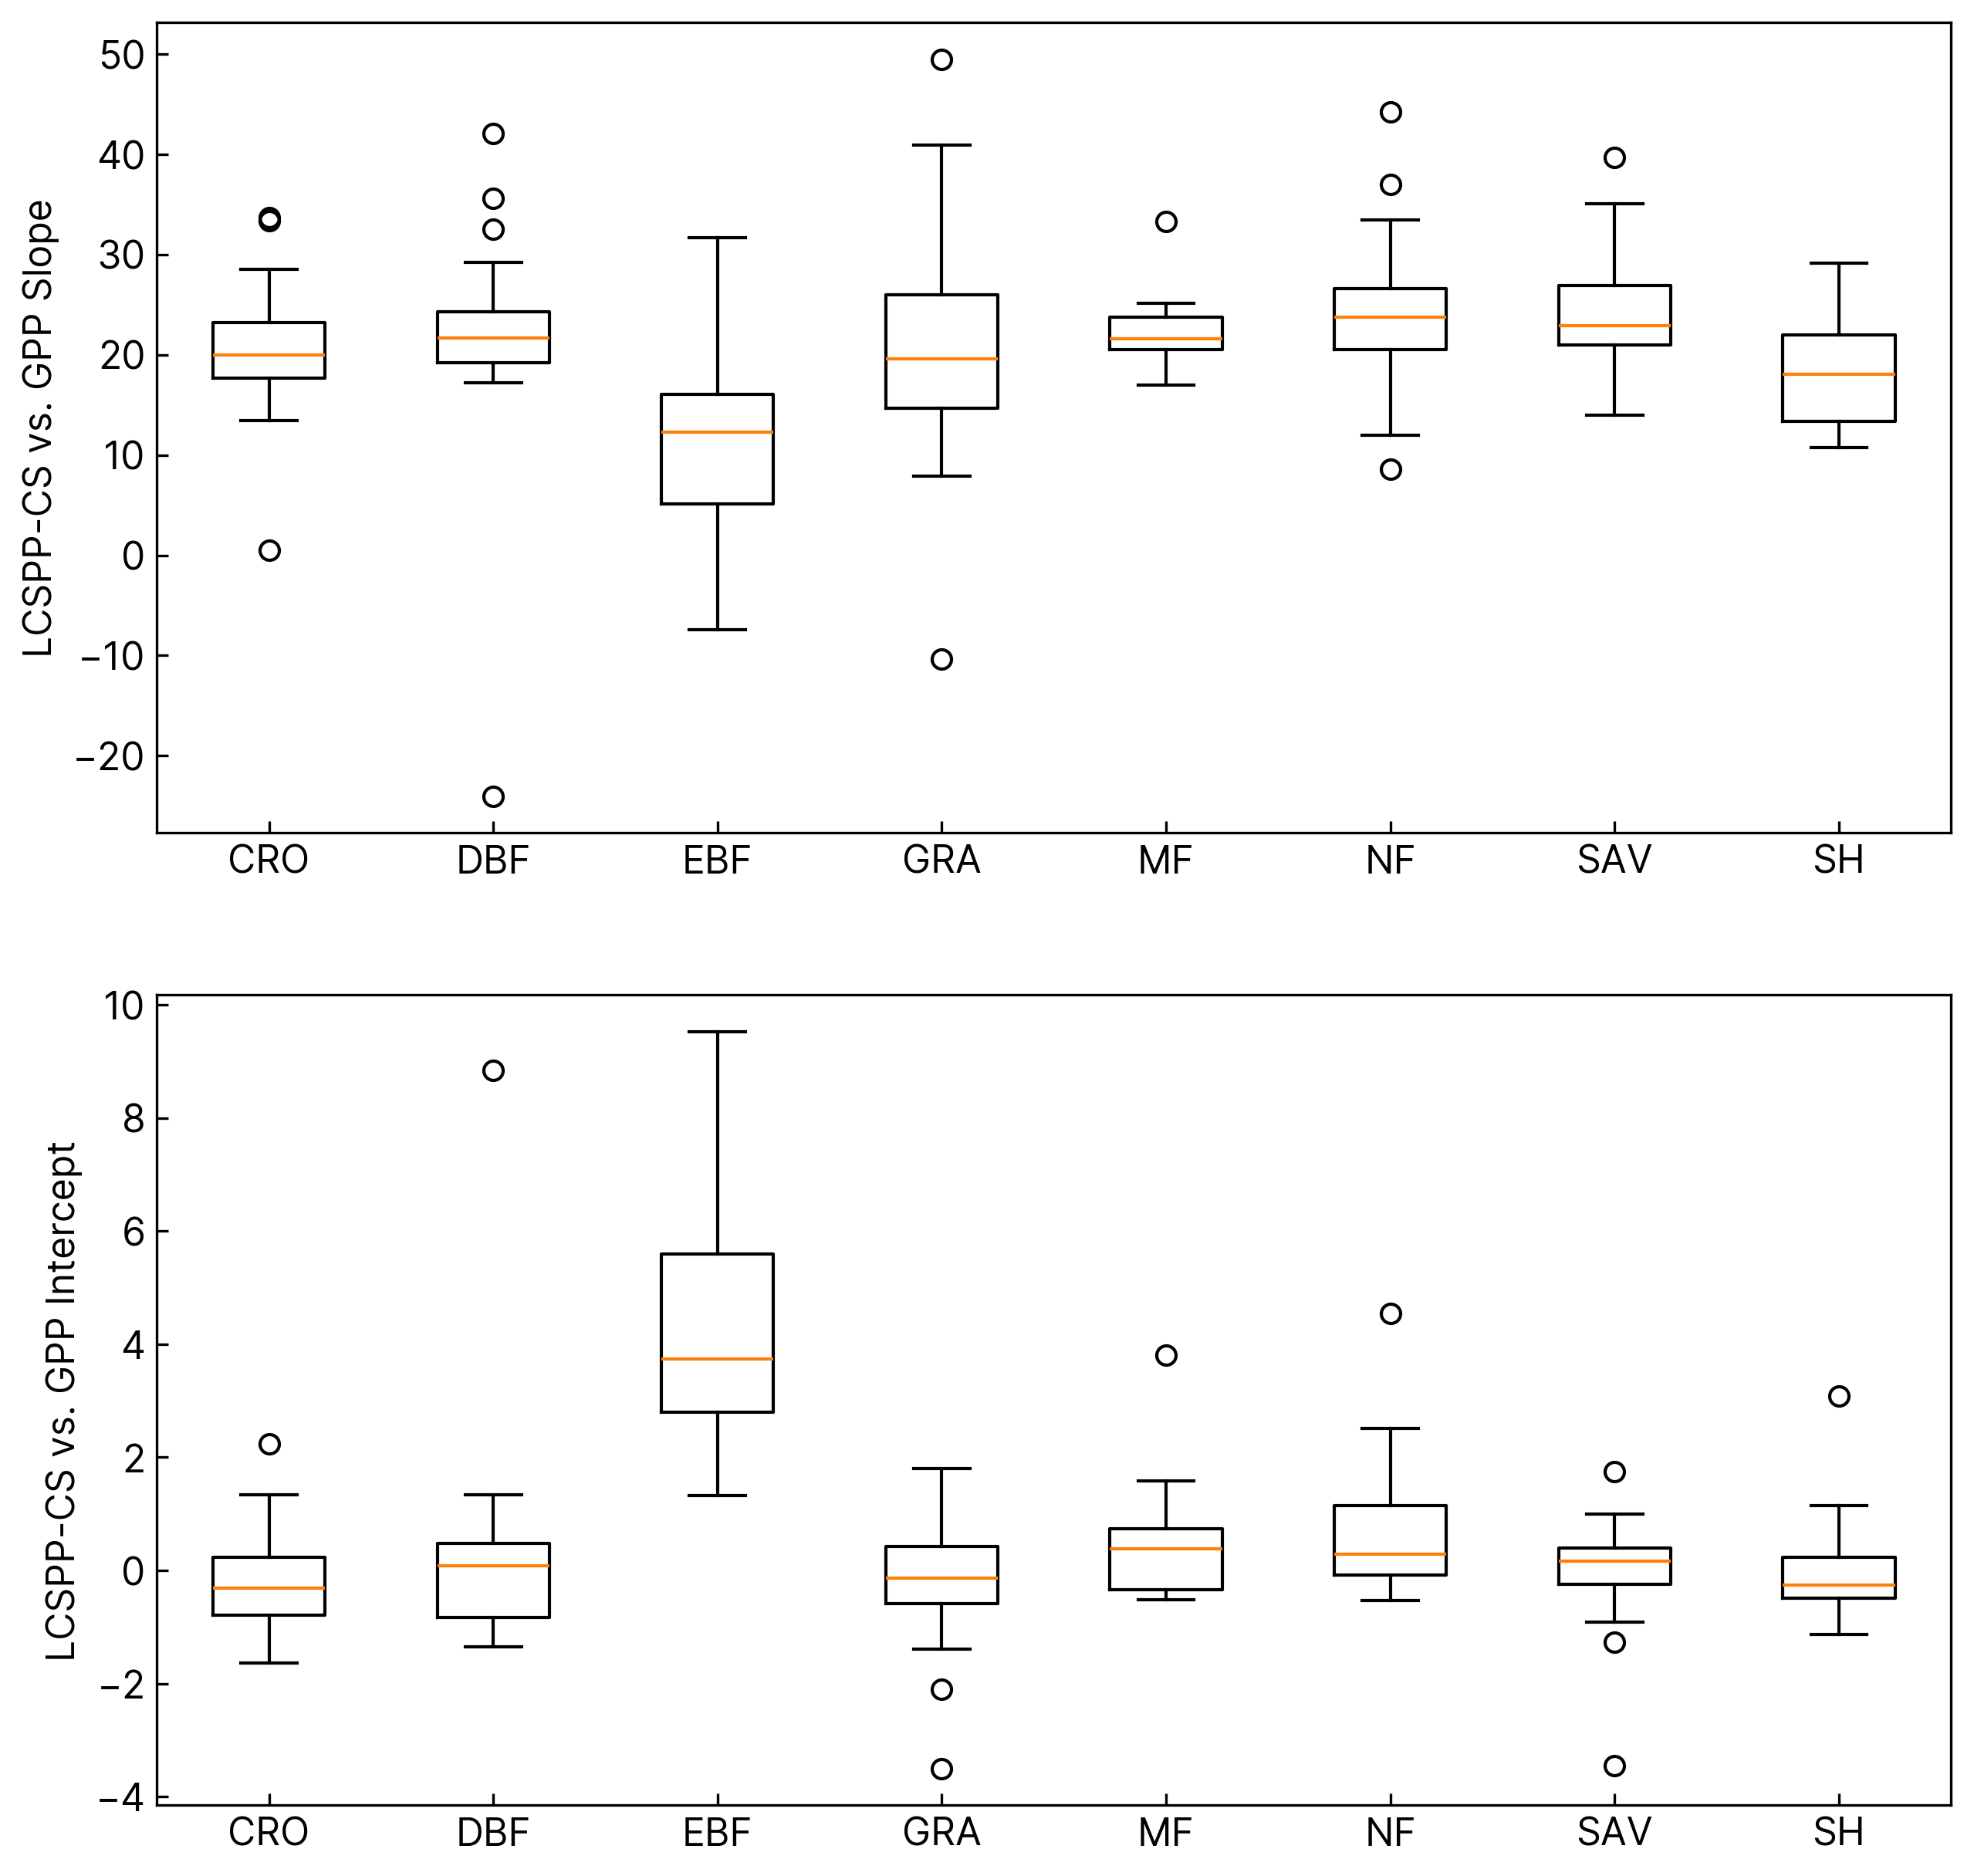

In [53]:
fig, axs = plt.subplots(2,1, figsize=(10,10), dpi=300)
ax = axs.flatten()

ax[0].boxplot([result_all_df[(result_all_df["type"]=="LCSPP") 
                           & (result_all_df["IGBP"] == pft)]["slope"].values for pft in IGBP_types])
ax[0].set_xticks(np.arange(len(IGBP_types)) + 1, IGBP_types)
ax[0].set_ylabel("LCSPP-CS vs. GPP Slope")


ax[1].boxplot([result_all_df[(result_all_df["type"]=="LCSPP") 
                           & (result_all_df["IGBP"] == pft)]["intercept"].values for pft in IGBP_types])
ax[1].set_xticks(np.arange(len(IGBP_types)) + 1, IGBP_types)
ax[1].set_ylabel("LCSPP-CS vs. GPP Intercept")
plt.show("./figs/LCSPP-CS_vs_GPP_Slope_and_Intercept.png")

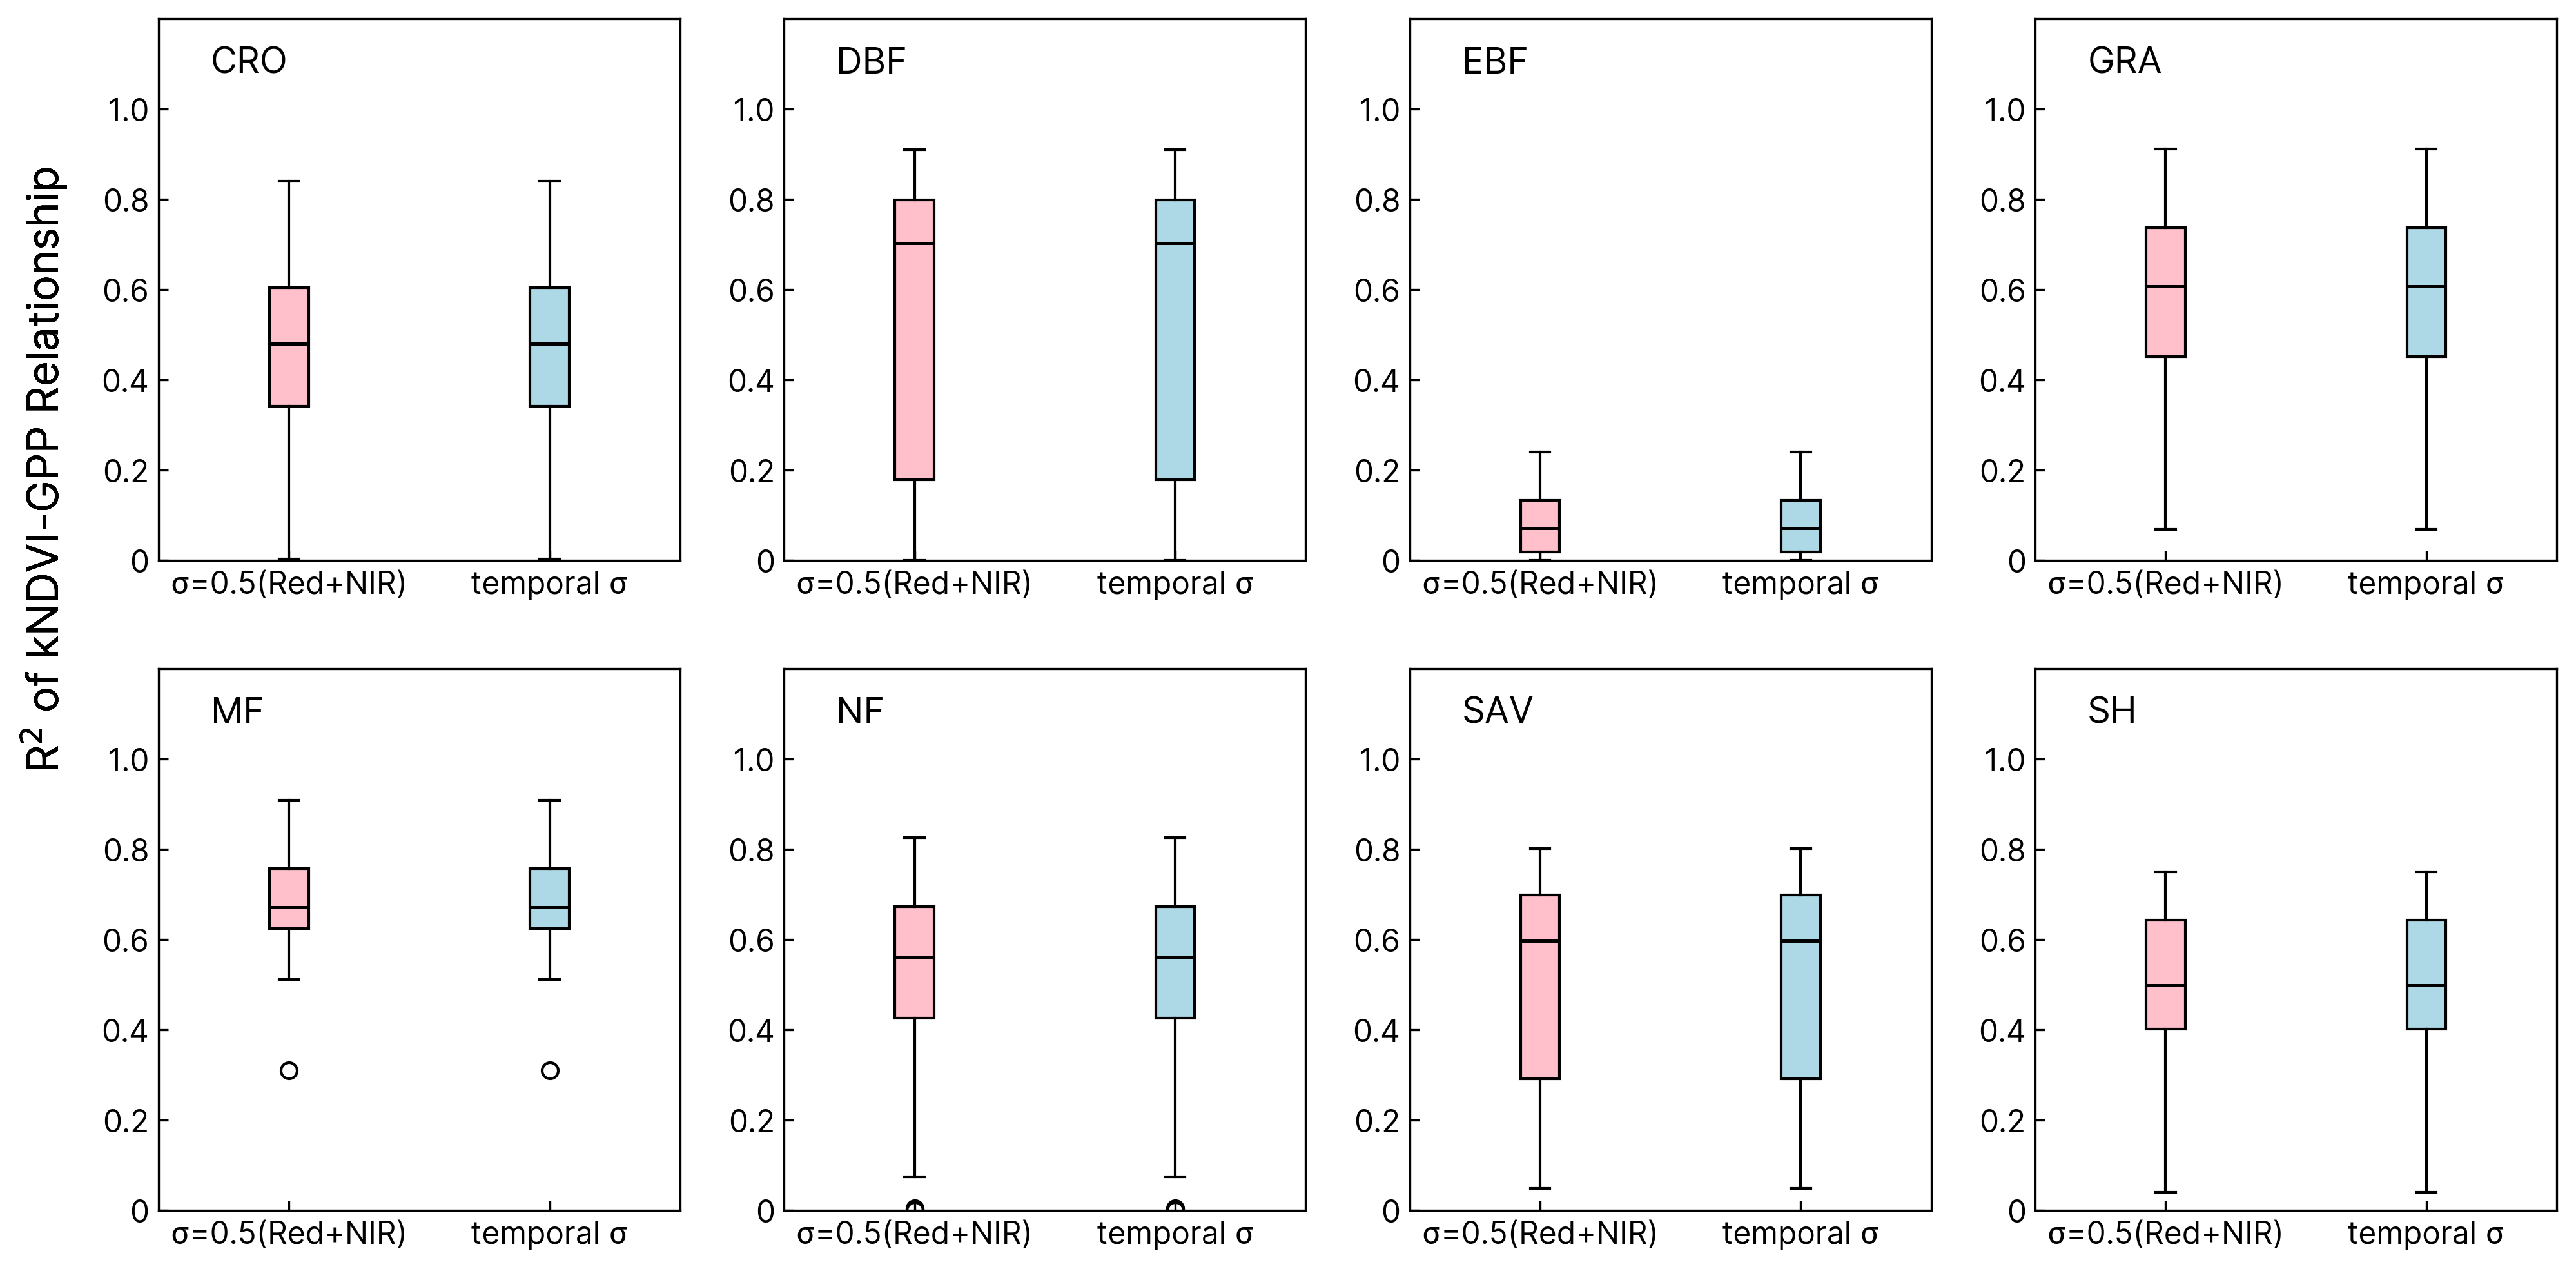

In [54]:
def plot_bar(axis, x1, x2, y_loc):
    axis.plot([x1,x2], [y_loc, y_loc], c="k")
    axis.plot([x1,x1], [y_loc, y_loc-0.02], c="k")
    axis.plot([x2,x2], [y_loc, y_loc-0.02], c="k")
        

from matplotlib.patches import Patch
fig, axs = plt.subplots(2,4, figsize=(16,8), dpi=300)
ax = axs.flatten()
IGBP_types = np.unique(avhrr_ltdr_all_df["IGBP"])
for i in range(len(IGBP_types)):
    p = [1,2]
    data=np.vstack([[avhrr_ltdr_all_df[(avhrr_ltdr_all_df["IGBP"]==IGBP_types[i]) 
                             & (avhrr_ltdr_all_df["type"]==t) & (avhrr_ltdr_all_df["sensor"]=="AVHRR")]["R^2"] for t in ["LCREF_KNDVI", "LCREF_KNDVI_TEMPORAL"]]]).T
    #data_rearrange = np.zeros((data.shape[0] // 2, data.shape[1]*2))
    #data_rearrange[:, np.arange(data.shape[1]) * 2] = data[:(data.shape[0]// 2), :]
    #data_rearrange[:, np.arange(data.shape[1]) * 2 + 1] = data[(data.shape[0]// 2):, :]
    
    bplot = ax[i].boxplot(data, positions=p, patch_artist=True)
    #ax[i].set_xlim(0, 21)
    colors = ['pink','lightblue']
    xticks_location = [1, 2]
    ax[i].set_xticks(xticks_location, labels=["σ=0.5(Red+NIR)", "temporal σ"], fontsize=15)
    ax[i].tick_params(axis='both', which='major', labelsize=11.5)

    ax[i].text(0.7, 0.93+0.15, IGBP_types[i], fontsize=13.5)
    #ax[i].text(0.7, 0.86+0.35, "n = " + str(len(np.unique(avhrr_ltdr_all_df[avhrr_ltdr_all_df["IGBP"]==IGBP_types[i]]["SITE_ID"]))), fontsize=13)
    ax[i].set_ylim(0, 1.2)
    ax[i].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0], ["0", "0.2", "0.4", "0.6", "0.8", "1.0"])
    """
    alpha = 0.05
    if t_test_lcspp_clear_vs_vi_all_df[(t_test_lcspp_clear_vs_vi_all_df["IGBP"]==IGBP_types[i]) & (t_test_lcspp_clear_vs_vi_all_df["LCSPP_clear vs."]=="LCREF_NDVI")]["p"].values.item() < alpha:
        plot_bar(ax[i], xticks_location[0], xticks_location[4], 1.0)
        ax[i].text(xticks_location[0], 1.02, "*", c="blue", fontsize=16)
    if t_test_lcspp_clear_vs_vi_all_df[(t_test_lcspp_clear_vs_vi_all_df["IGBP"]==IGBP_types[i]) & (t_test_lcspp_clear_vs_vi_all_df["LCSPP_clear vs."]=="LCREF_KNDVI_TEMPORAL")]["p"].values.item() < alpha:
        plot_bar(ax[i], xticks_location[1], xticks_location[4], 1.05)
        ax[i].text(xticks_location[1], 1.05+0.02, "*", c="blue", fontsize=16)
    if t_test_lcspp_clear_vs_vi_all_df[(t_test_lcspp_clear_vs_vi_all_df["IGBP"]==IGBP_types[i]) & (t_test_lcspp_clear_vs_vi_all_df["LCSPP_clear vs."]=="LCREF_NIRV")]["p"].values.item() < alpha:
        plot_bar(ax[i], xticks_location[2], xticks_location[4], 1.1)
        ax[i].text(xticks_location[2], 1.1+0.02, "*", c="blue", fontsize=16)
    if t_test_lcspp_clear_vs_vi_all_df[(t_test_lcspp_clear_vs_vi_all_df["IGBP"]==IGBP_types[i]) & (t_test_lcspp_clear_vs_vi_all_df["LCSPP_clear vs."]=="LCREF_NIRVP")]["p"].values.item() < alpha:
        plot_bar(ax[i], xticks_location[3], xticks_location[4], 1.15)
        ax[i].text(xticks_location[3], 1.15+0.02, "*", c="blue", fontsize=16)
    if t_test_lcspp_clear_vs_vi_all_df[(t_test_lcspp_clear_vs_vi_all_df["IGBP"]==IGBP_types[i]) & (t_test_lcspp_clear_vs_vi_all_df["LCSPP_clear vs."]=="LCSPP_ALL")]["p"].values.item() < alpha:
        plot_bar(ax[i], xticks_location[5], xticks_location[4], 1.2)
        ax[i].text(xticks_location[5], 1.18, "*", c="blue", fontsize=16)
    if t_test_lcspp_clear_vs_vi_all_df[(t_test_lcspp_clear_vs_vi_all_df["IGBP"]==IGBP_types[i]) & (t_test_lcspp_clear_vs_vi_all_df["LCSPP_clear vs."]=="FLUXCOM_XBASE")]["p"].values.item() < alpha:
        plot_bar(ax[i], xticks_location[6], xticks_location[4], 1.25)
        ax[i].text(xticks_location[6], 1.25+0.02, "*", c="blue", fontsize=16)
        
    dd_types = ["LCREF_NDVI", "LCREF_KNDVI_TEMPORAL", "LCREF_NIRV", "LCREF_NIRVP", "LCSPP", "LCSPP_ALL", "FLUXCOM_XBASE"]
    for j in range(7):
        if avhrr_ltdr_t_test_all_df[(avhrr_ltdr_t_test_all_df["IGBP"]==IGBP_types[i]) & (avhrr_ltdr_t_test_all_df["variable"]==dd_types[j])]["p"].item() < alpha:
            yloc = np.median(avhrr_ltdr_all_df[(avhrr_ltdr_all_df["IGBP"]==IGBP_types[i]) * (avhrr_ltdr_all_df["type"]==dd_types[j])]["R^2"])
            ax[i].text(xticks_location[j]-0.25, min(yloc + 0.3, 0.9), "*", color="k", fontsize=14)
    """
    fig.text(0.08,0.4, "R$^2$ of kNDVI-GPP Relationship", rotation=90, fontsize=16)

    for median in bplot['medians']:
        median.set(color ='black',
                   linewidth = 1.2)
    
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
        
    #ax[i].plot([18,18], [0,2], "--", c="grey")
#plt.savefig("./figs/FLUXNET_MODIS_PERIOD_ALL_nirvp_all_compared_with_all_sky.png", dpi=300)


In [55]:
avhrr_ltdr_all_df[(avhrr_ltdr_all_df["IGBP"]==IGBP_types[i]) 
                             & (avhrr_ltdr_all_df["type"]=="LCREF_KNDVI") & (avhrr_ltdr_all_df["sensor"]=="AVHRR")]

,SITE_ID,sensor,type,R^2,slope,intercept,LAT,LON,IGBP
338,CA-NS6,AVHRR,LCREF_KNDVI,0.445311,10.819340,-2.642898,55.916670,-98.964440,SH
347,CA-NS7,AVHRR,LCREF_KNDVI,0.270696,12.358636,-3.420611,56.635830,-99.948330,SH
401,CA-SF3,AVHRR,LCREF_KNDVI,0.615232,10.224086,-1.812797,54.091560,-106.005260,SH
770,ES-Amo,AVHRR,LCREF_KNDVI,0.469446,18.997341,-1.162170,36.833610,-2.252320,SH
779,ES-LgS,AVHRR,LCREF_KNDVI,0.049126,6.971320,-0.058594,37.097940,-2.965830,SH
788,ES-LJu,AVHRR,LCREF_KNDVI,0.726437,22.399723,-2.503709,36.926590,-2.752120,SH
1022,IT-Noe,AVHRR,LCREF_KNDVI,0.040721,4.420477,1.589195,40.606180,8.151690,SH
1148,RU-Cok,AVHRR,LCREF_KNDVI,0.562296,14.517686,-2.504440,70.829140,147.494280,SH
1337,US-KS2,AVHRR,LCREF_KNDVI,0.522193,18.103142,-2.215516,28.608600,-80.671500,SH
1508,US-Sta,AVHRR,LCREF_KNDVI,0.477301,16.650122,-0.131648,41.396600,-106.802400,SH


In [56]:
modis_t_test_lcspp_all_vs_vi_all_df[modis_t_test_lcspp_all_vs_vi_all_df["LCSPP_all vs."]=="FLUXCOM_XBASE"]

,IGBP,LCSPP_all vs.,df,t,p
5,CRO,FLUXCOM_XBASE,15,1.482351,0.158950
12,DBF,FLUXCOM_XBASE,21,0.546583,0.590426
19,EBF,FLUXCOM_XBASE,13,-0.748036,0.467756
26,GRA,FLUXCOM_XBASE,34,3.174246,0.003184
33,MF,FLUXCOM_XBASE,9,-0.016318,0.987337
40,NF,FLUXCOM_XBASE,41,4.623381,0.000037
47,SAV,FLUXCOM_XBASE,13,0.280787,0.783293
54,SH,FLUXCOM_XBASE,11,1.148660,0.275061


In [57]:
modis_t_test_lcspp_all_vs_vi_all_df[modis_t_test_lcspp_all_vs_vi_all_df["LCSPP_all vs."]=="FLUXCOM_XBASE"]

,IGBP,LCSPP_all vs.,df,t,p
5,CRO,FLUXCOM_XBASE,15,1.482351,0.158950
12,DBF,FLUXCOM_XBASE,21,0.546583,0.590426
19,EBF,FLUXCOM_XBASE,13,-0.748036,0.467756
26,GRA,FLUXCOM_XBASE,34,3.174246,0.003184
33,MF,FLUXCOM_XBASE,9,-0.016318,0.987337
40,NF,FLUXCOM_XBASE,41,4.623381,0.000037
47,SAV,FLUXCOM_XBASE,13,0.280787,0.783293
54,SH,FLUXCOM_XBASE,11,1.148660,0.275061
